# Co-binding Motif Analysis

In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/home/jenhan/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


## Generate Score Files

### Convert motif files

In [75]:
# # convert MEME motif database text file into individual motifs
# converted_motifs_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'
# currentLines = []
# with open('JASPAR_CORE_2016_vertebrates.meme') as f:
#     data = f.readlines()
    
# currentLines = [data[9]]
# for line in data[9:]:
#     if 'MOTIF' in line:
#         motifName = currentLines[0].strip().split()[-1]
#         outFile = open(converted_motifs_dir + '/' + motifName + '.fimo', 'w')
#         outFile.write('MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n\nBackground letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000 ')
#         for cl in currentLines:
#             outFile.write(cl)
#         outFile.close()
#         currentLines = [line]
#     else:
#         currentLines.append(line)

In [76]:
# convert MEME motif file to homer compatible format
outFile = open('jaspar.motif', 'w')


currentLines = []
with open('JASPAR_CORE_2016_vertebrates.meme') as f:
    data = f.readlines()
    
currentLines = []
for line in data[9:]:
    if 'MOTIF' in line and len(currentLines) > 0:
        motifName = currentLines[0].strip().split()[-1]
        outFile.write('>' + motifName + '\t' + motifName + '\n')
        for cl in currentLines[3:]:
            if not 'URL' in cl:
                outFile.write('\t'.join(cl.strip().split()) + '\n')
        currentLines = [line]
    else:
        currentLines.append(line)
        
outFile.close()



In [77]:
### convert homer motif files into a MEME compatible format
# homer motifs should come from the Homer motif database
homerMotifDir = '/home/jenhan/analysis/cobinding_motif_analysis/jaspar_2016_curated_homerFormat'
outDir = '/home/jenhan/analysis/cobinding_motif_analysis/homer_motifs_converted'


for f in os.listdir(homerMotifDir):
    if os.path.isfile(homerMotifDir + '/' +f):
        out_file = open(outDir + '/' + f.replace('motif','fimo'), 'w')
        with open(homerMotifDir + '/' + f) as i:
            data = i.readlines()
        out_file.write('MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n\n' +
                       'Background letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000\n' +
                       'MOTIF '+ f.split('.')[0] + ' ' +data[0].split()[1] + '\n')
        out_file.write('letter-probability matrix: nsites= 20 alength= 4 w= '+str(len(data)-1)+' E= 0 \n')
        for line in data[1:]:
            out_file.write('  ' + line)
        out_file.write('\n')
        out_file.close()
    

### Create group summary file

In [81]:
# %%capture
# create group summary file
# !bash /home/jenhan/code/seq_merge_pipe/makeSummaryFile.sh /home/jenhan/analysis/cobinding_motif_analysis/peak_files/* > /home/jenhan/analysis/cobinding_motif_analysis/group_summary.tsv
# ! mv merged.tsv /home/jenhan/analysis/cobinding_motif_analysis/group/merged_peaks.tsv
! mergePeaks -d given -venn venn.txt ./peak_files/* > /home/jenhan/analysis/cobinding_motif_analysis/group/merged_peaks.tsv
! makeSummaryFile.py /home/jenhan/analysis/cobinding_motif_analysis/group/merged_peaks.tsv /home/jenhan/analysis/cobinding_motif_analysis/group_summary.tsv /home/jenhan/analysis/cobinding_motif_analysis/peak_files/*


	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./peak_files/balbc_cjun_kla_peaks.tsv (29800 total) and ./peak_files/balbc_cjun_kla_peaks.tsv (29800 total)
	Comparing ./peak_files/balbc_cjun_kla_peaks.tsv (29800 total) and ./peak_files/balbc_cjun_veh_peaks.tsv (17969 total)
	Comparing ./peak_files/balbc_cjun_kla_peaks.tsv (29800 total) and ./peak_files/balbc_fos_kla_peaks.tsv (44787 total)
	Comparing ./peak_files/balbc_cjun_kla_peaks.tsv (29800 total) and ./peak_files/balbc_fos_veh_peaks.tsv (3167 total)
	Comparing ./peak_files/balbc_cjun_kla_peaks.tsv (29800 total) and ./peak_files/balbc_junb_kla_peaks.tsv (28543 total)
	Comparing ./peak_files/balbc_cjun_kla_peaks.tsv (29800 total) and ./peak_files/balbc_junb_veh_peaks.tsv (3213 total)
	Comparing ./peak_files/balbc_cjun_kla_peaks.tsv (29800 total) and ./peak_files/balbc_jund_kla_peaks.tsv (24877 total)
	Comparing ./peak_files/balbc_cjun_kla_peaks.tsv (29800 total) and ./peak_files/balbc_jund_ve

### Annotate with Enhancer Marks

In [82]:
%%bash
annotatePeaks.pl ./group/merged_peaks.tsv mm10 -size 1000 -strand + -d ./tag_directories_enhancerMarks/* > merged_annotated_peaks_sense.tsv &
annotatePeaks.pl ./group/merged_peaks.tsv mm10 -size 1000 -strand - -d ./tag_directories_enhancerMarks/* > merged_annotated_peaks_antisense.tsv &
annotatePeaks.pl ./group/merged_peaks.tsv mm10 -hist 20 -size 1000 -strand both -d ./tag_directories_enhancerMarks/* > hist.tsv &




	Peak file = ./group/merged_peaks.tsv
	Genome = mm10
	Organism = mouse
	-----------------------------------------------------
	Histogram mode activated (bin size = 20 bp)
	-----------------------------------------------------
	Peak Region set to 1000
	Will count tags on strand: both
	Tag Directories:
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_5GRO_KLA_12-03-09
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_5GRO_Veh_12-03-09
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_KLA_mk_11-06-08
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_KLA_mk_11-08-26
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_Veh_mk_11-06-08
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_Veh_mk_11-08-26
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_H3K27Ac_KLA_CR_12-07-06
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_H3K27Ac_KLA_DGO_14-08-18
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_H3K27Ac_Veh_CR_12-07-06
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_H3K27Ac_Veh_DGO_14

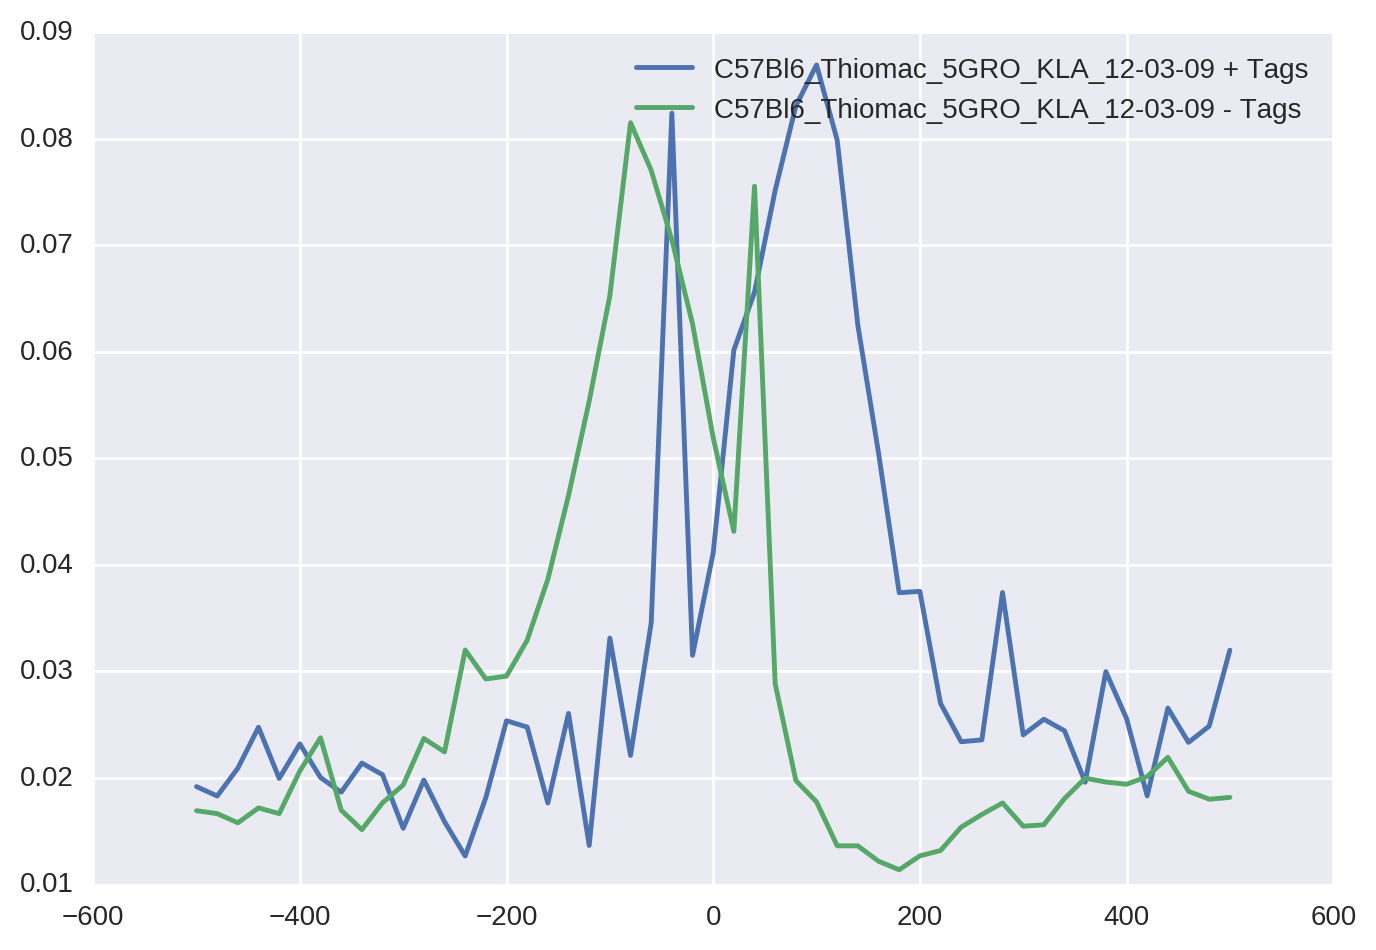

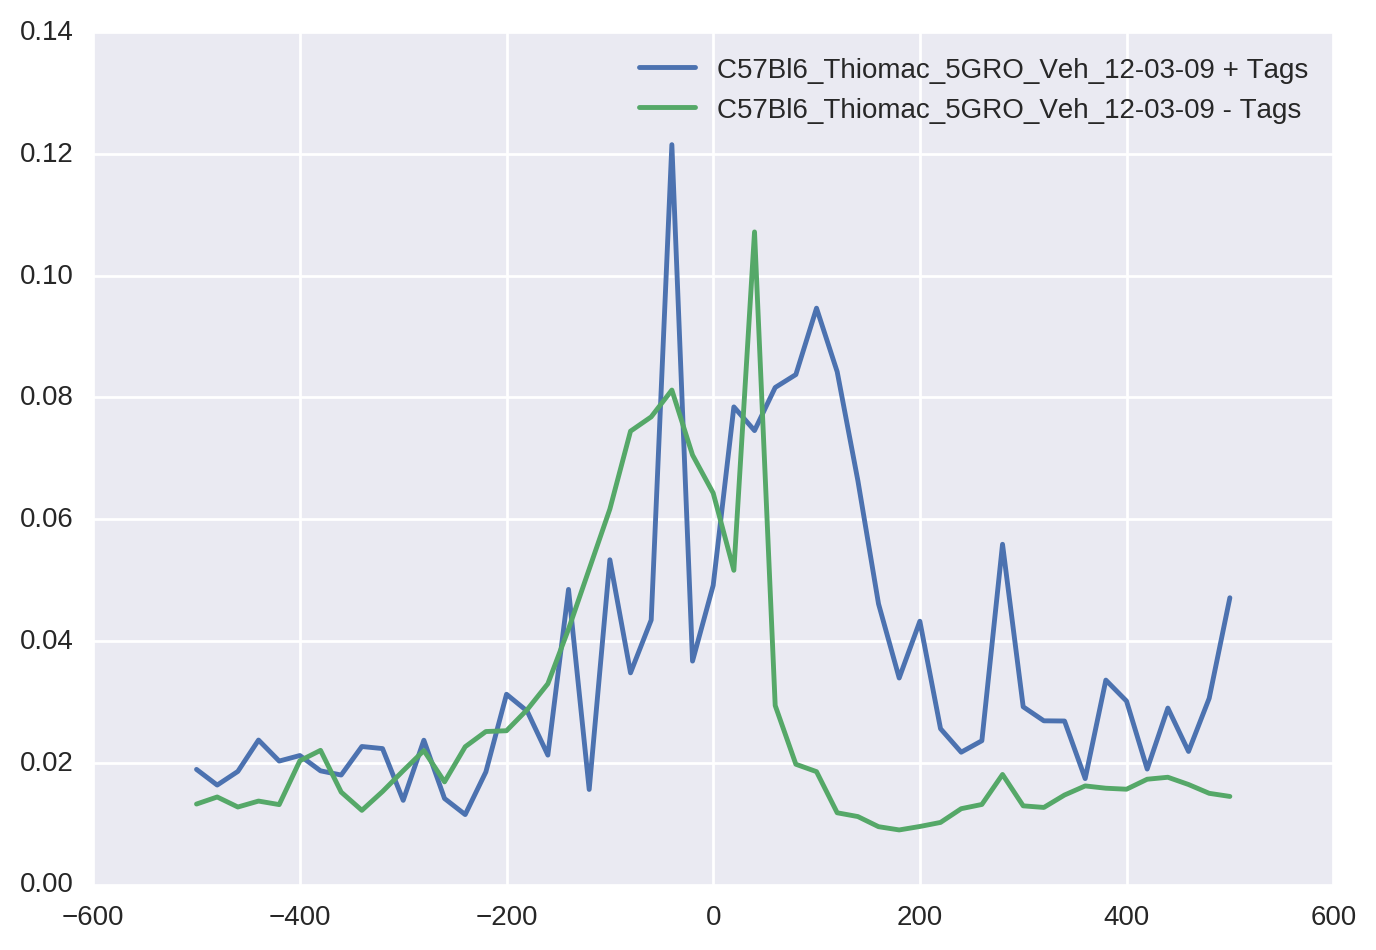

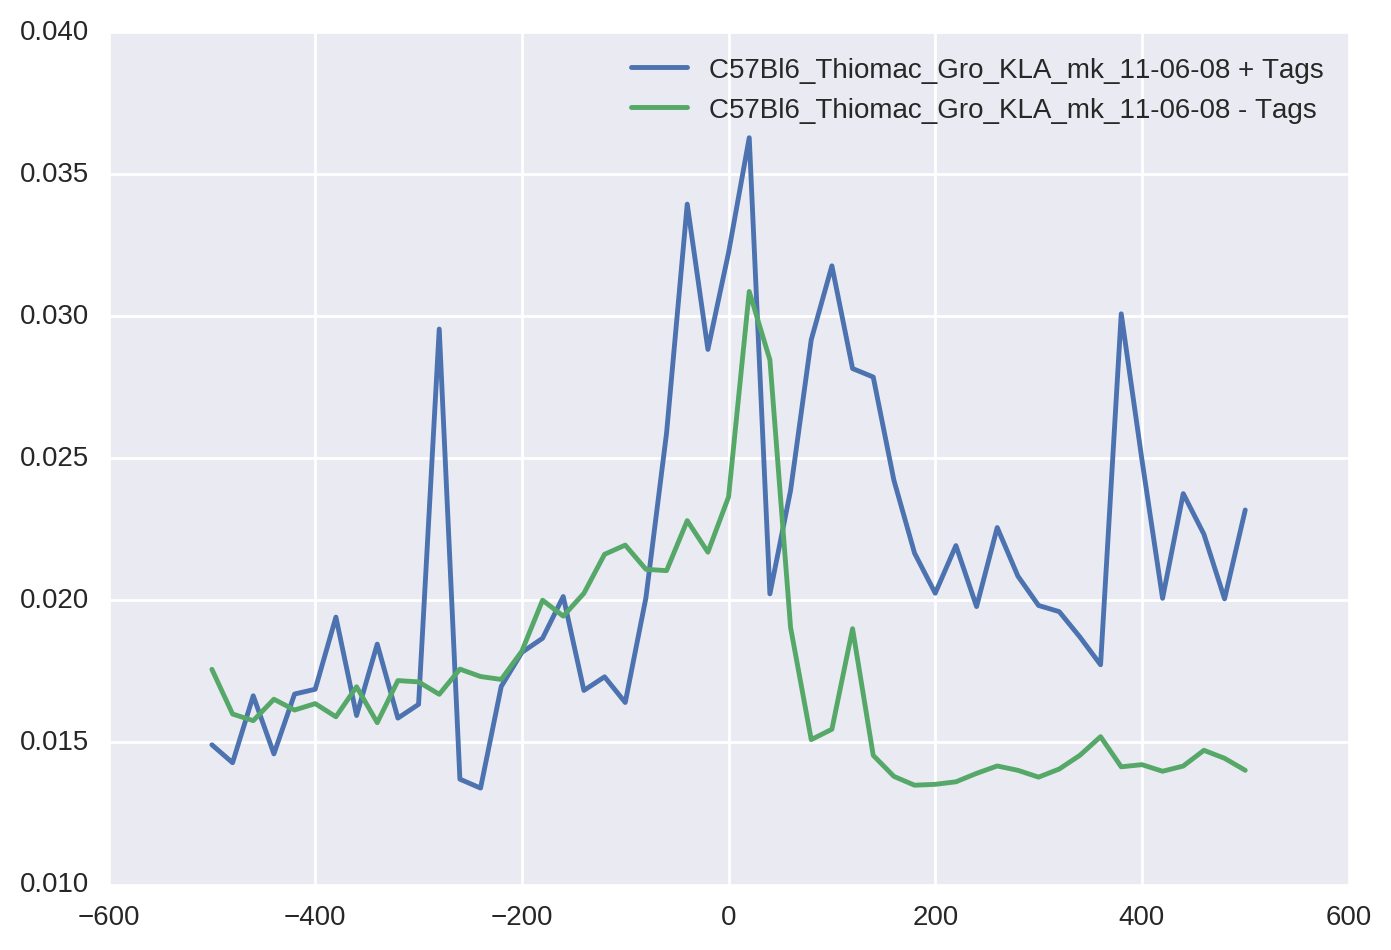

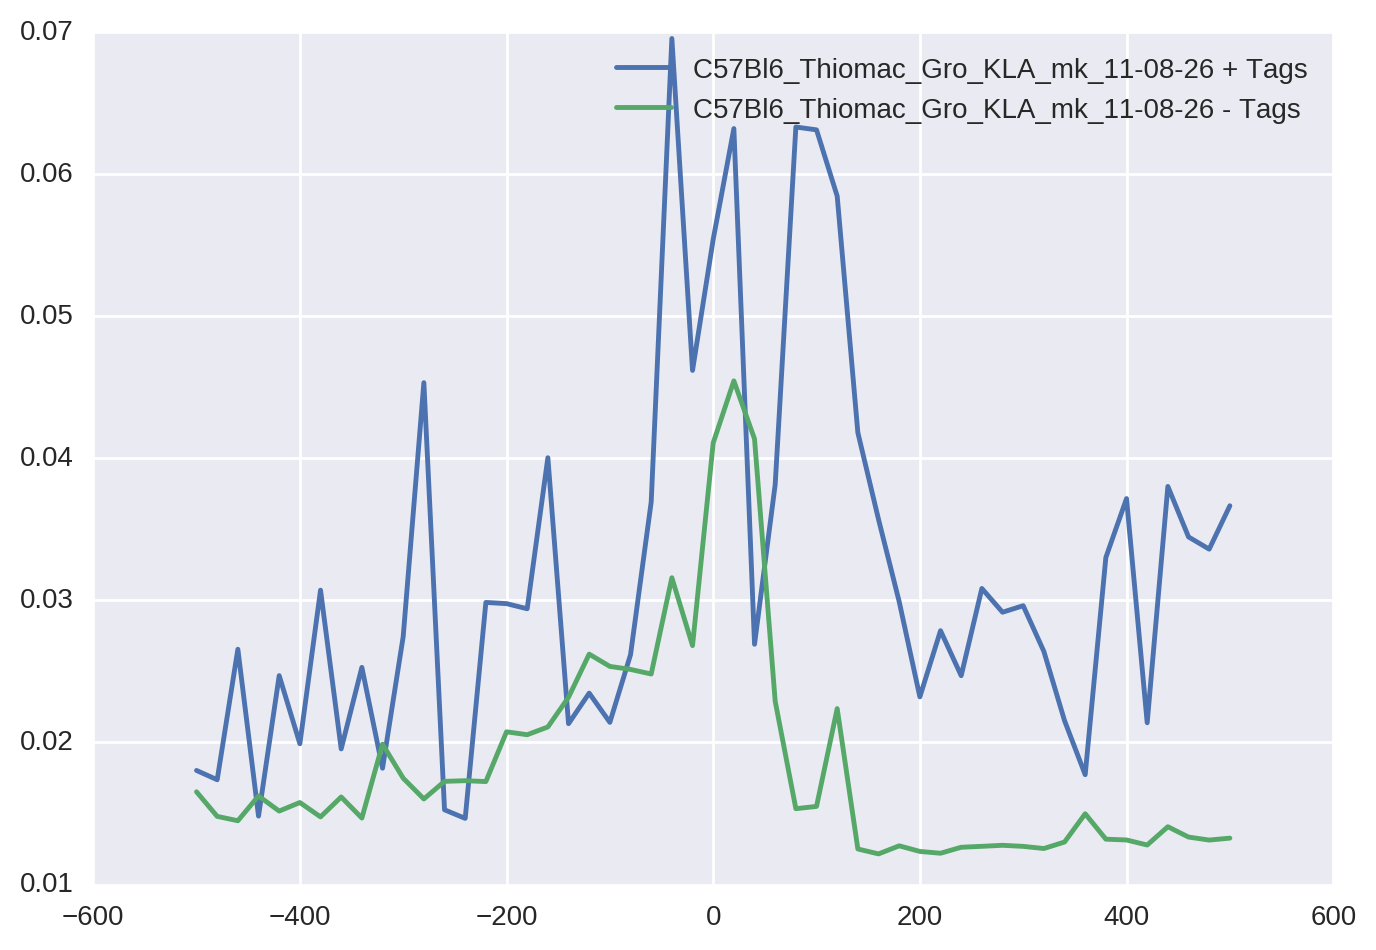

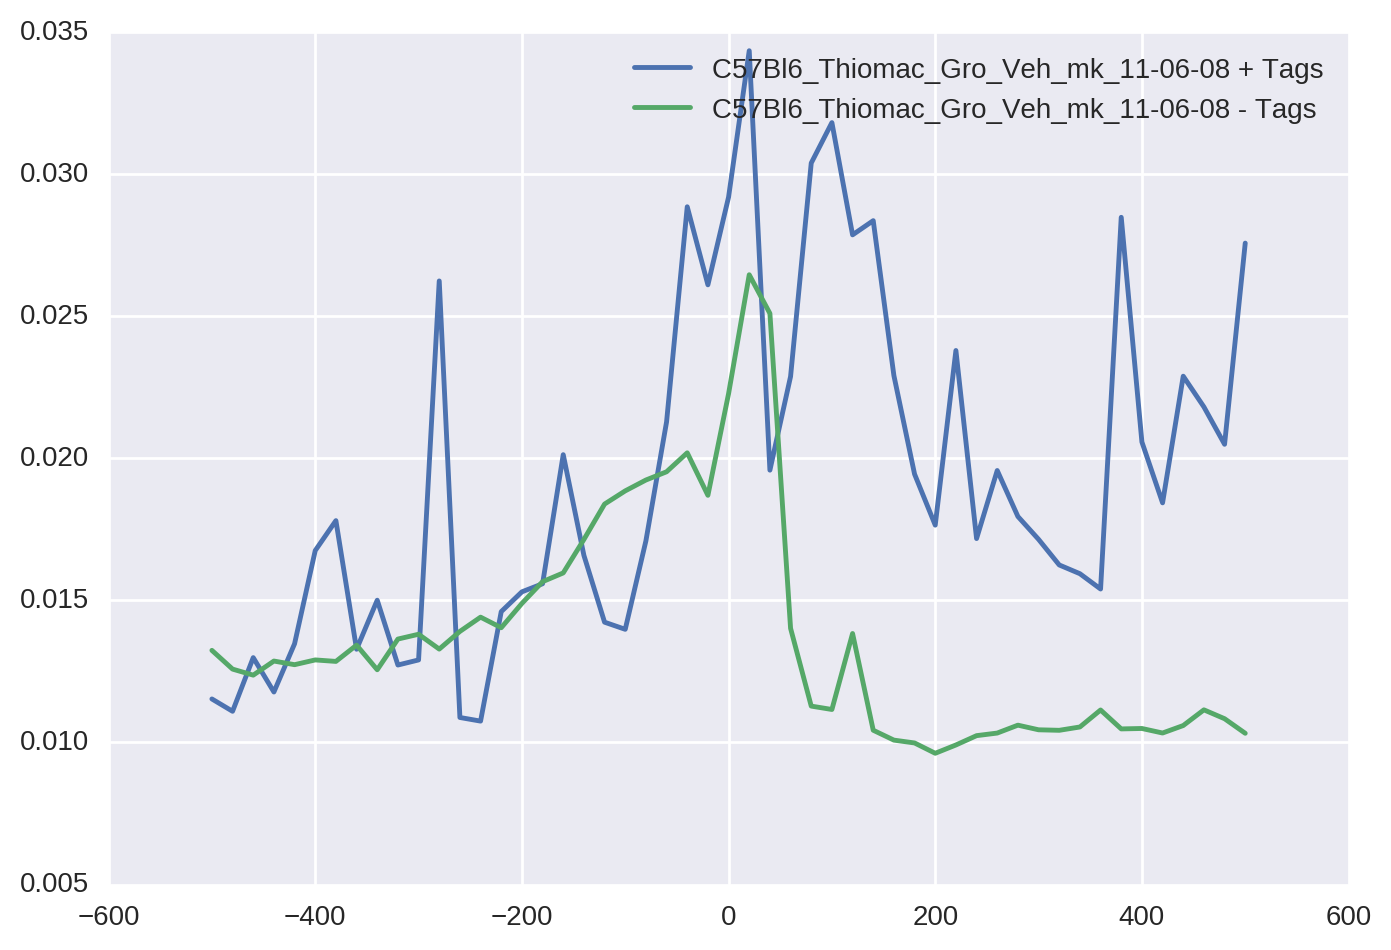

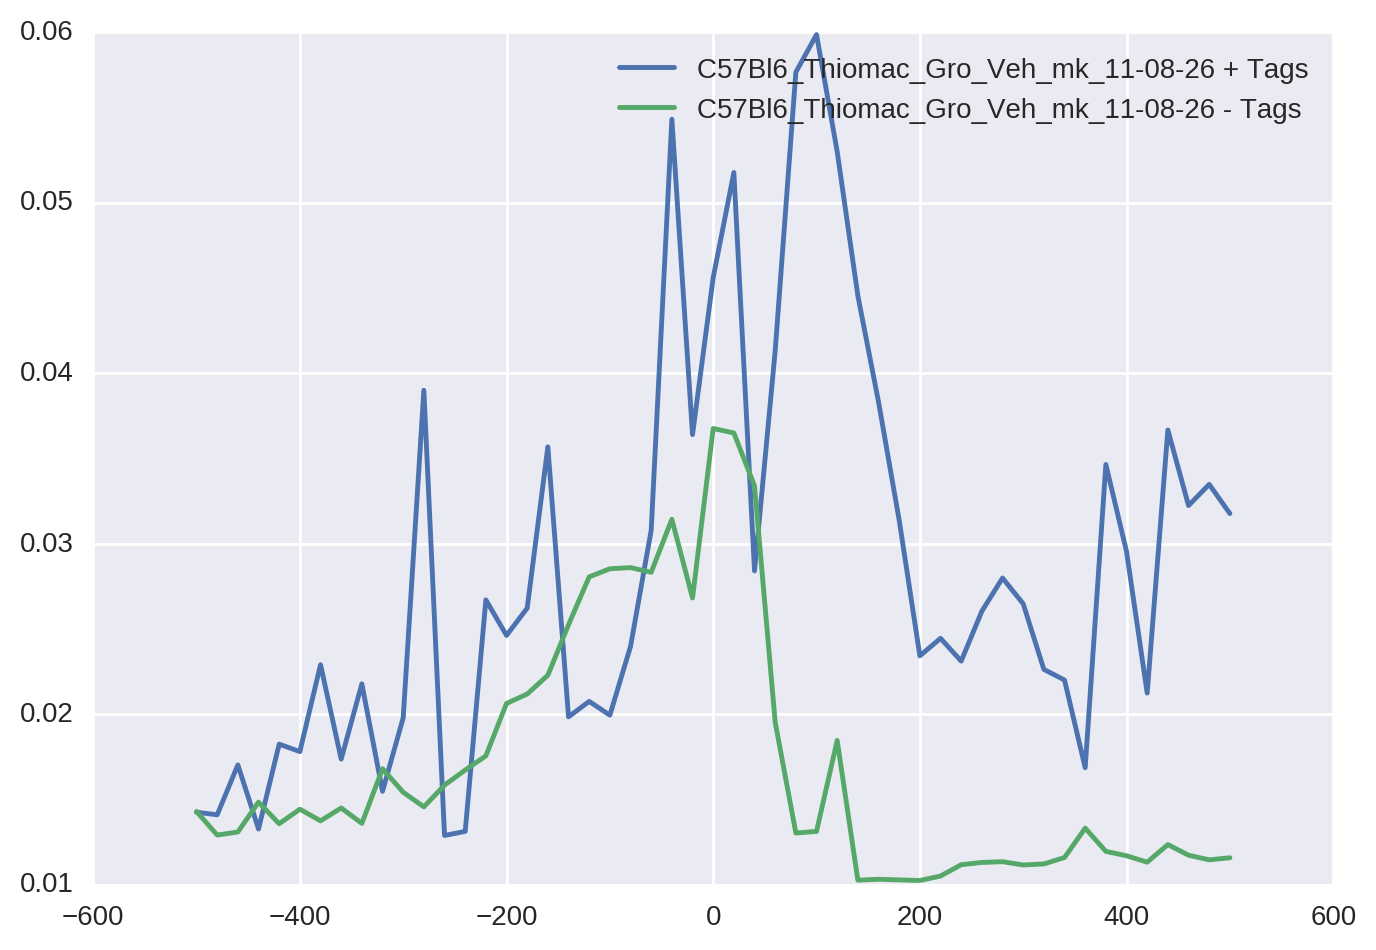

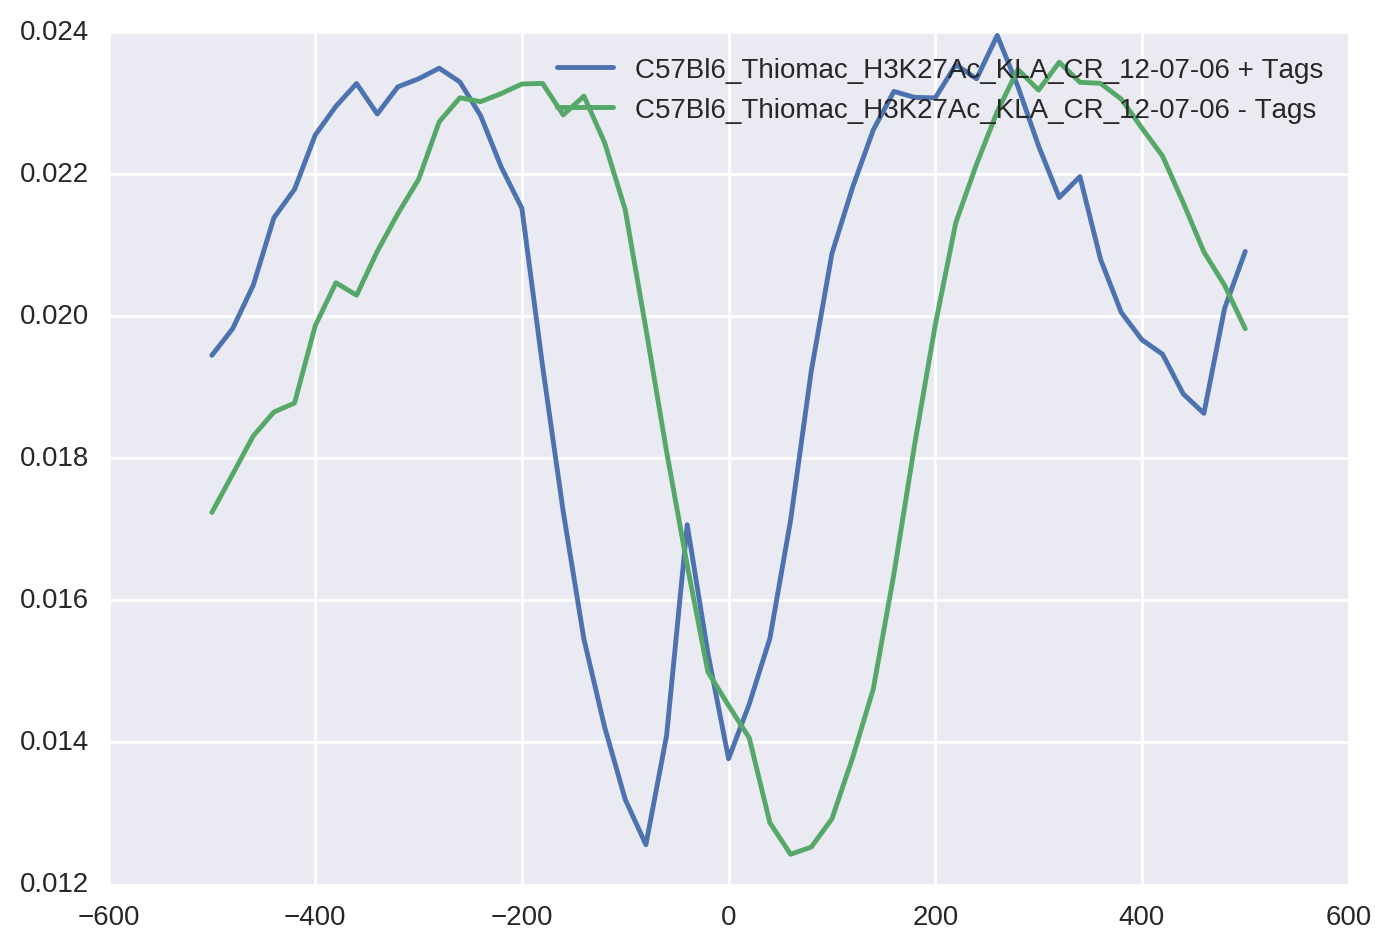

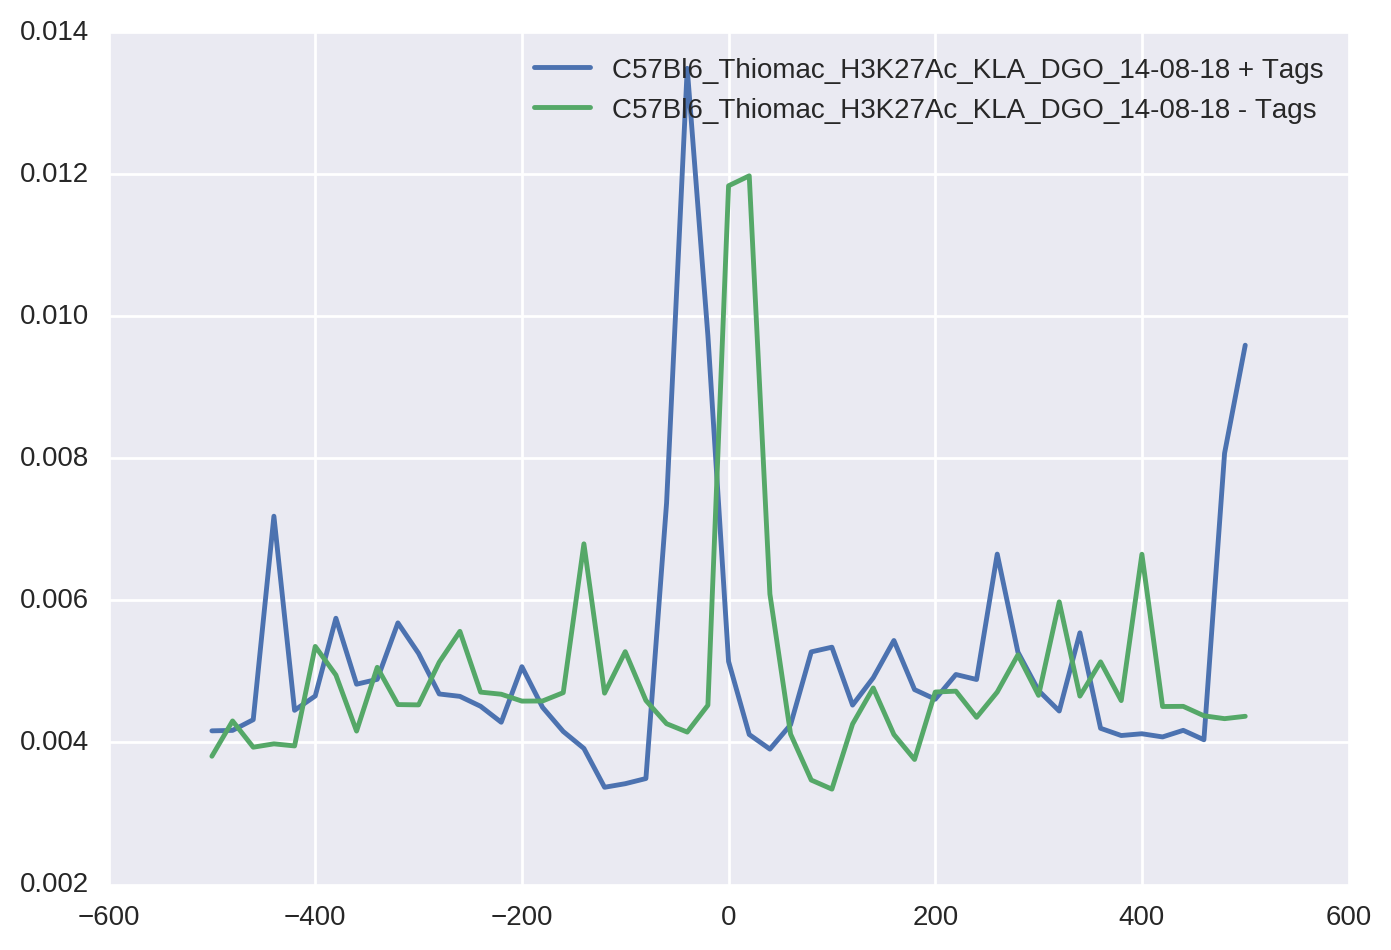

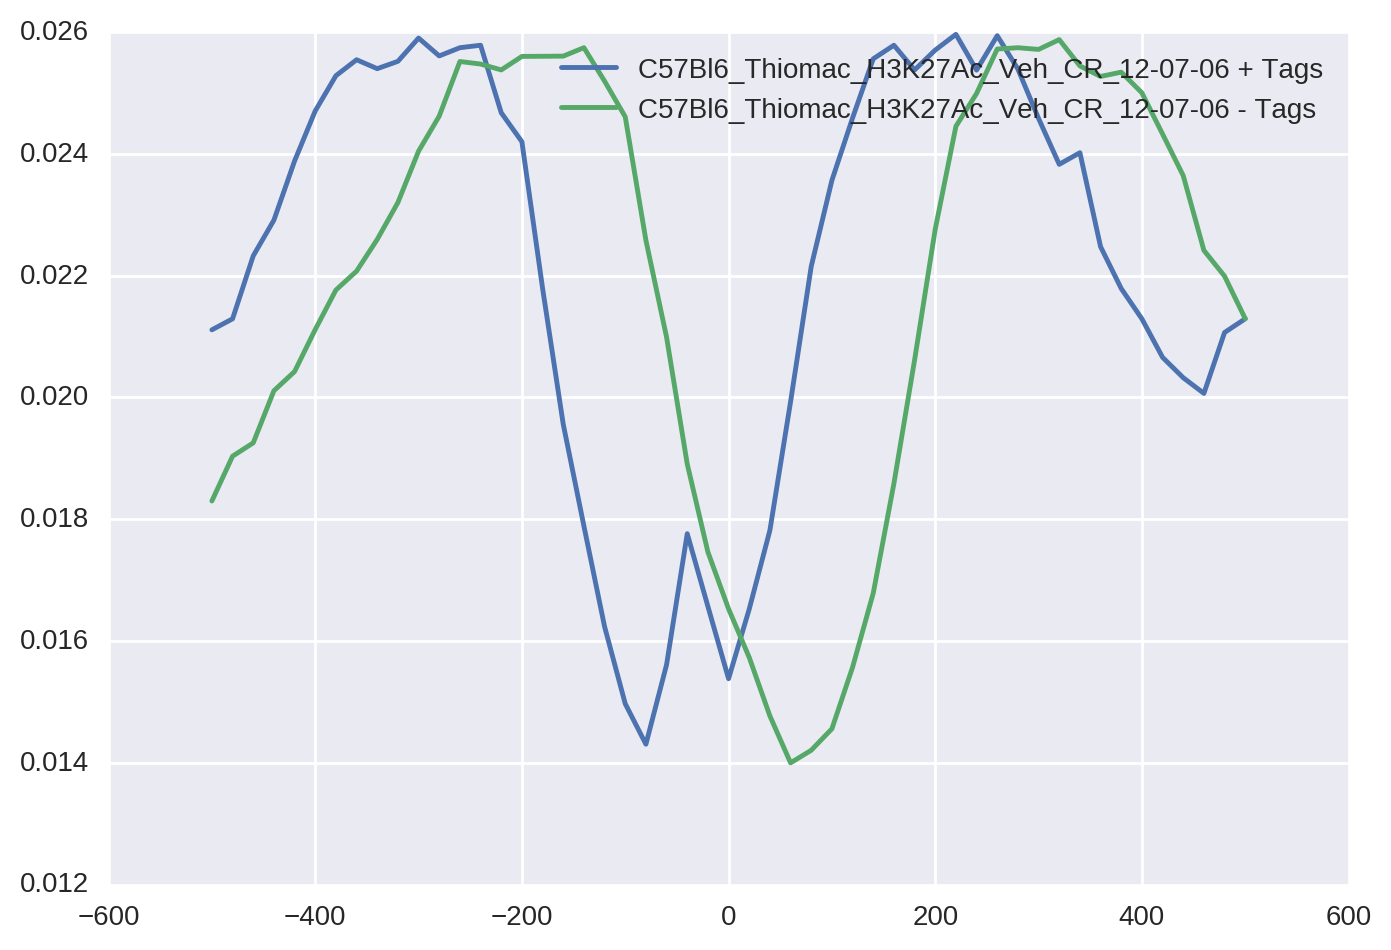

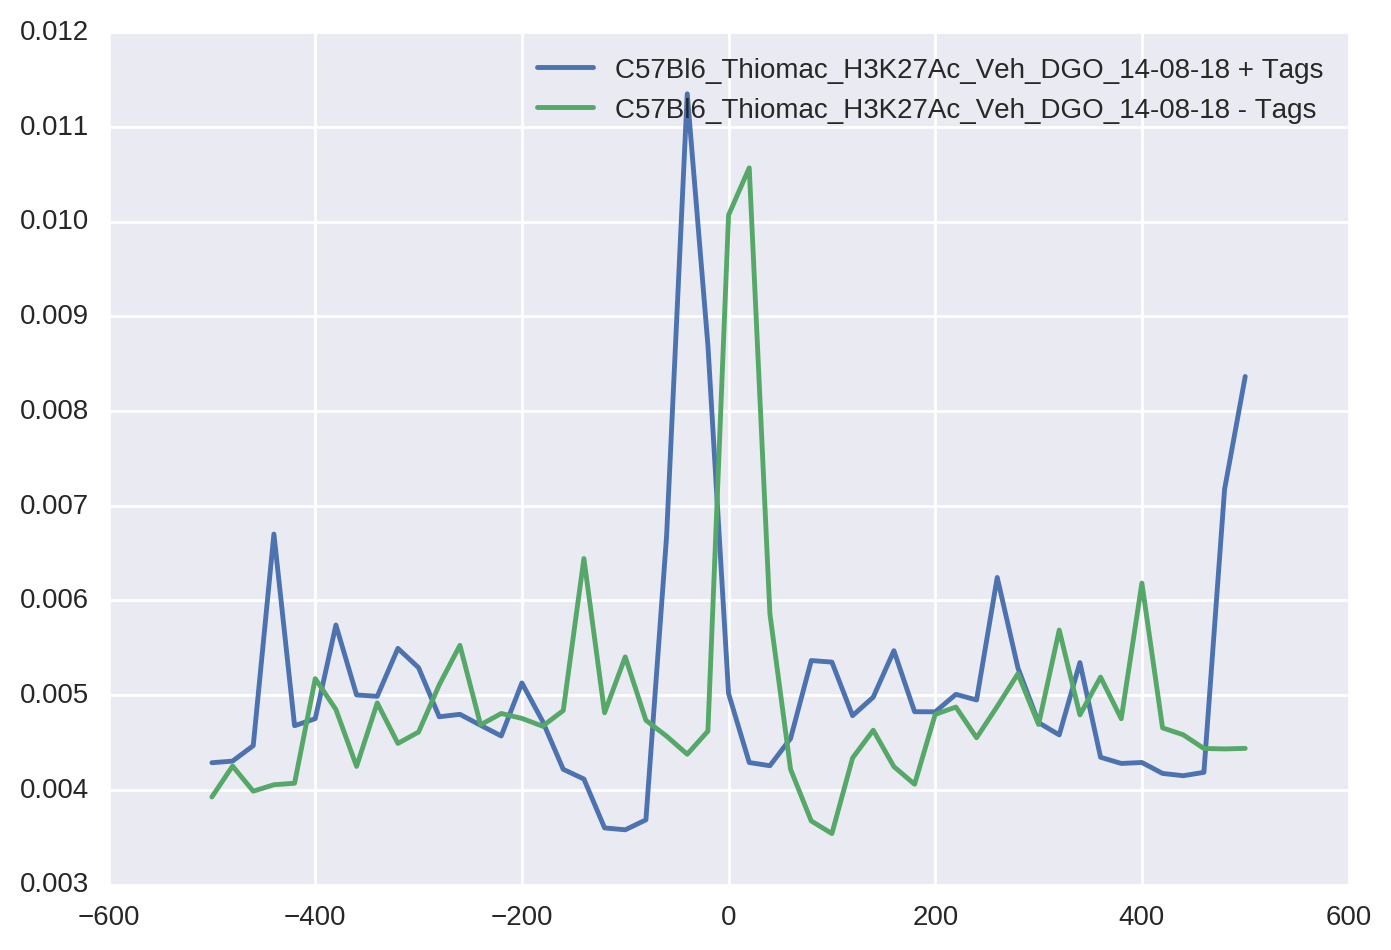

In [83]:
frame =pd.read_csv('hist.tsv',sep='\t')
columns = frame.columns.values
for i in range(int((frame.shape[1]-1)/3)):
    plt.plot(frame.ix[:,0],frame[columns[3*i+2]])
    plt.plot(frame.ix[:,0],frame[columns[3*i+3]])
    plt.legend([columns[3*i+2].split('/')[-1], columns[3*i+3].split('/')[-1]])
    plt.show()

### Retrieve sequences under peaks for finding motifs

In [84]:
# %%capture
# get sequences to scan for motifs
!/home/jenhan/code/motif_tools/getTargetSequencesWrapper.sh /home/jenhan/analysis/cobinding_motif_analysis/group/ /home/jenhan/analysis/cobinding_motif_analysis/group 0

python extendPeaks.py /home/jenhan/analysis/cobinding_motif_analysis/group//merged_peaks.tsv /home/jenhan/analysis/cobinding_motif_analysis/group//merged_extPeaks.tsv 0
homerTools extract /home/jenhan/analysis/cobinding_motif_analysis/group//merged_extPeaks.tsv /bioinformatics/homer/data/genomes/mm10 -fa > /home/jenhan/analysis/cobinding_motif_analysis/group/merged.fa

	Extracting sequences from directory: /bioinformatics/homer/data/genomes/mm10
	Extracting 9122 sequences from chr1
	Extracting 10666 sequences from chr2
	Extracting 6806 sequences from chr3
	Extracting 7351 sequences from chr4
	Extracting 7536 sequences from chr5
	Extracting 7296 sequences from chr6
	Extracting 7256 sequences from chr7
	Extracting 5910 sequences from chr8
	Extracting 6476 sequences from chr9
	Extracting 7338 sequences from chr10
	Extracting 9064 sequences from chr11
	Extracting 5176 sequences from chr12
	Extracting 5994 sequences from chr13
	Extracting 4868 sequences from chr14
	Extracting 5351 sequences

In [85]:
### read in sequences as dictionary {peakID: sequence}
with open('./group/merged.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()
        

### Scan for motifs using FIMO

In [120]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jenhan/analysis/cobinding_motif_analysis/fimo_out/ ]; then mkdir /home/jenhan/analysis/cobinding_motif_analysis/fimo_out/; fi
! rm -rf fimo_out/*
! rm -rf fimo_result/*
pthresh = 0.01
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_results'
p='/home/jenhan/analysis/cobinding_motif_analysis/group/merged.fa'
count = 0
scriptFile = open('scanMotifs.sh','w')
for m in os.listdir(motif_dir):
    if 'fimo' in m:
        fimo_out_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_out/' + m.replace('.fimo','')
        outPath = fimo_results_dir + '/merged_'+ m.replace('.fimo','') +'.txt'
    #     !echo fimo --max-stored-scores 2000000 --output-pthresh $pthresh --oc $fimo_out_dir $motif_dir/$m /home/jenhan/analysis/cobinding_motif_analysis/group/merged.fa   
        scriptFile.write(
#             '(sleep ' + str(15 * count) + 
            '(sleep ' + str(0 * count) + 
            's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
            str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
            motif_dir + '/' + m + ' /home/jenhan/analysis/cobinding_motif_analysis/group/merged.fa '+
            '> ' + outPath + ' ) & \n')
        count+=1
scriptFile.close()



In [87]:
%%bash
chmod a+x ./scanMotifs.sh
./scanMotifs.sh

Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Using motif +nr2e1 of width 9.
Using motif -nr2e1 of width 9.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Using motif +t of width 16.
Using motif -t of width 16.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Using motif +rfx of width 16.
Using motif -rfx of width 16.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Re

## Read in Score Files

### Generate main dictionaries from pickles

In [3]:
motif_score_frame=pd.read_pickle('motif_score_frame.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame.pickle')
motif_count_frame = pd.read_pickle('motif_count_frame.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
scaler = preprocessing.MinMaxScaler()
normed_summary_frame = pd.DataFrame(scaler.fit_transform(summary_frame.ix[:,5:]))
normed_summary_frame.columns = summary_frame.columns.values[5:]
normed_summary_frame.index = summary_frame.index.values

scaled_motif_frame = pd.DataFrame()
for m in motif_score_frame.columns[3:]:
    scaled_motif_frame[m] = motif_score_frame[m]/(2*motif_sequence_frame[m].str.len().max())
    
    
# motif_interaction_frame = pd.DataFrame(
#     sklearn.preprocessing.PolynomialFeatures(
#         degree=2, interaction_only=True).fit_transform(motif_score_frame.ix[:,3:])
# ).ix[:,1:]
# motifs = motif_score_frame.columns.values[3:]
# interaction_term_columns = list(motifs)
# for i in range(len(motifs)-1):
#     for j in range(i+1,len(motifs)):
#         interaction_term_columns.append(motifs[i]+'::'+motifs[j])
# motif_interaction_frame.columns = interaction_term_columns
# motif_interaction_frame.index = motif_score_frame.index.values

# significant_motifs_dict = pickle.load( open( "significant_motifs_dict.pickle", "rb" ) )
# motif_difference_dict = pickle.load( open( "motif_difference_dict.pickle", "rb" ) )



### read in sequences as dictionary {peakID: sequence}
with open('./group/merged.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [ ]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
intergenic_motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
intergenic_scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
# motif_interaction_frame = motif_interaction_frame[motif_interaction_frame.index.isin(intergenic_ids)]
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]


### Read in Peak scores as floating point values

In [88]:
# read in peak data data
summary_frame = pd.read_csv('/home/jenhan/analysis/cobinding_motif_analysis/group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]


_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
summary_frame.to_pickle('summary_frame.pickle')
scaler = sklearn.preprocessing.MinMaxScaler()
normed_summary_frame = pd.DataFrame(scaler.fit_transform(summary_frame.ix[:,5:]))
normed_summary_frame.columns = summary_frame.columns.values[5:]
normed_summary_frame.index = summary_frame.index.values

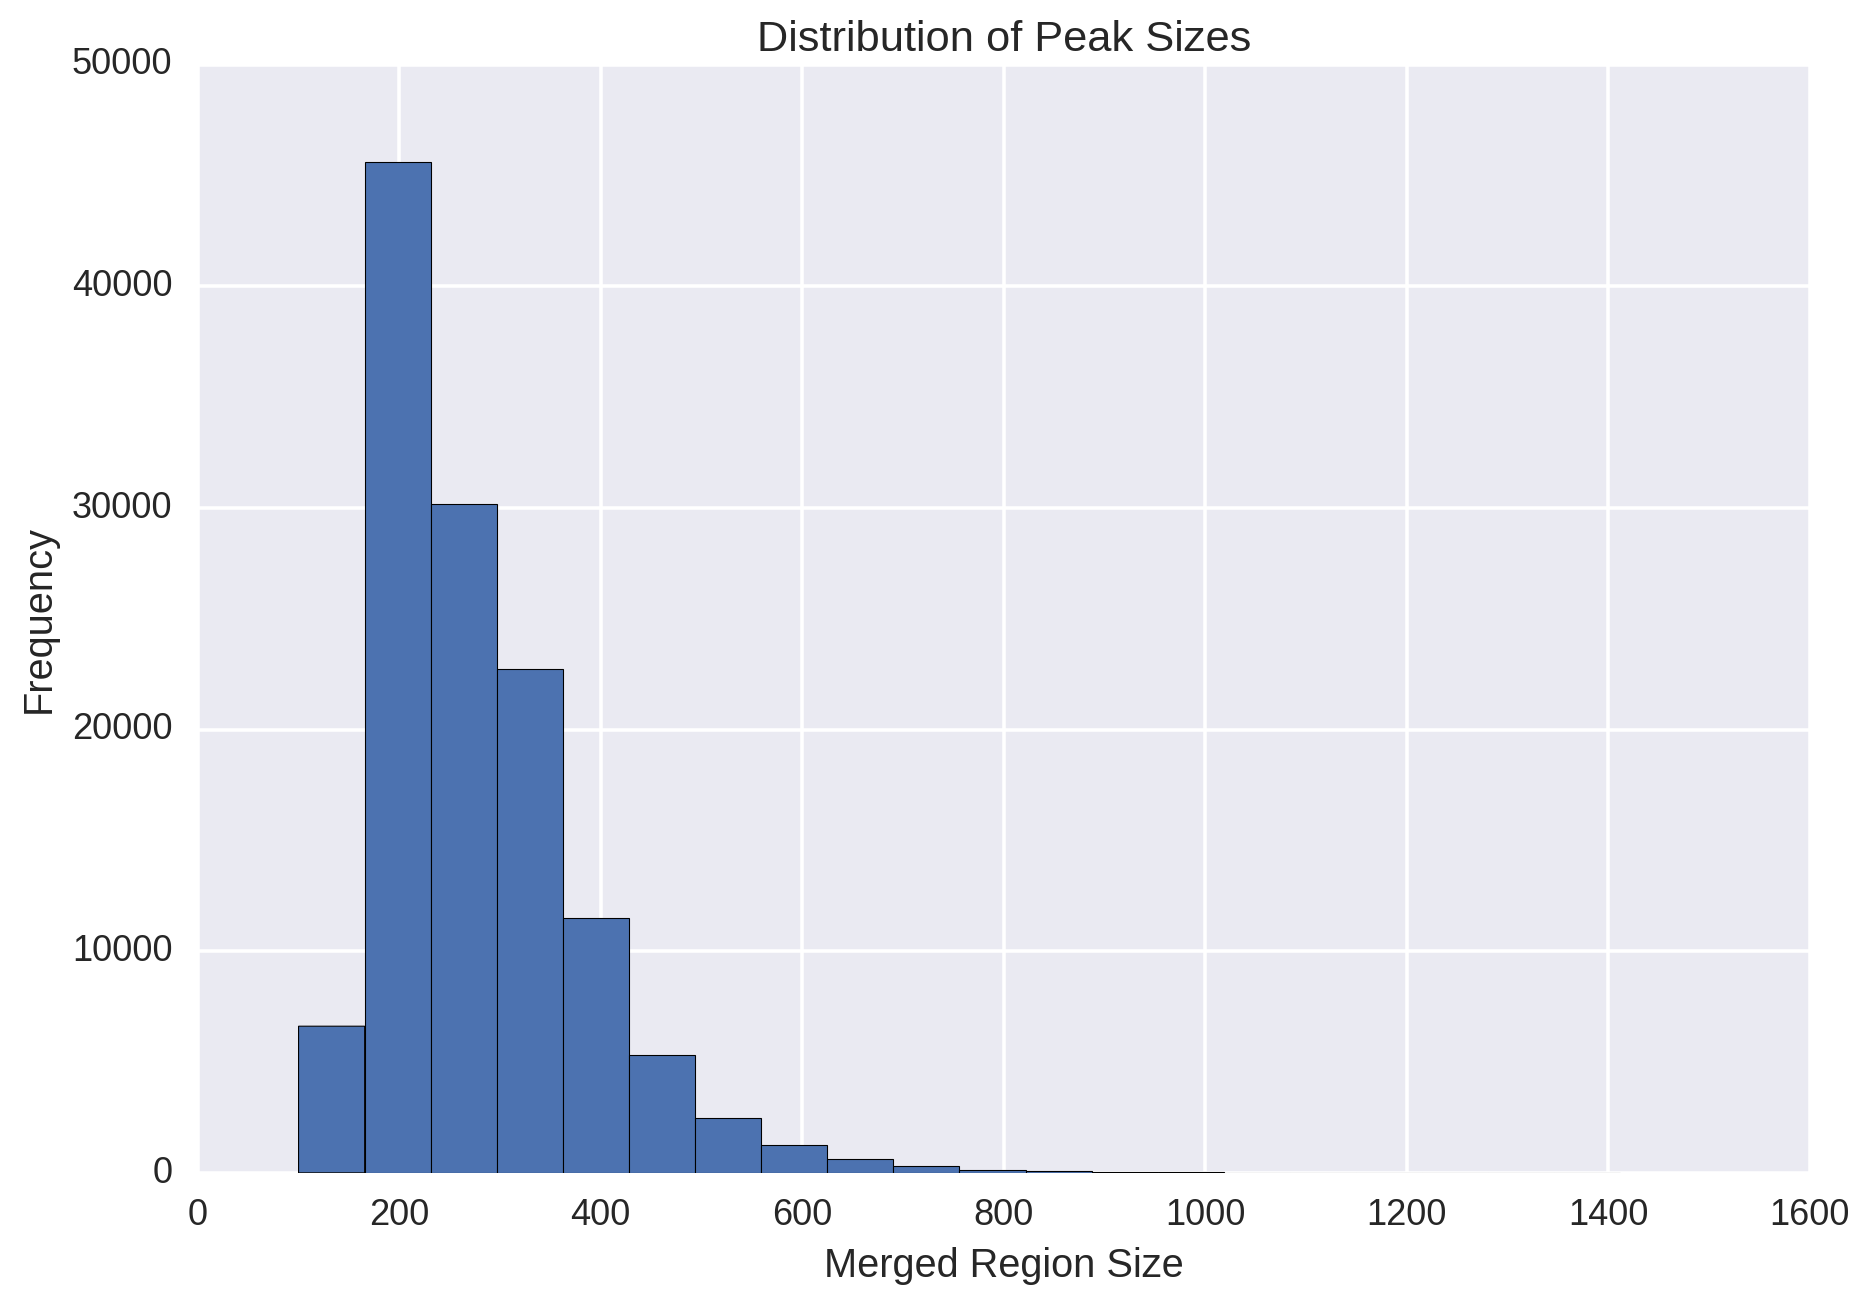

In [173]:

# plot motif positions to make sure that nothing went wrong with the merging
sizes = summary_frame['end'] - summary_frame['start']
plt.hist(sizes, bins = 20);
plt.xlabel('Merged Region Size')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Sizes')

### Read in Enhancer Marks

5GRO_KLA
5GRO_Veh
Gro_KLA
Gro_Veh
H3K27Ac_KLA
H3K27Ac_Veh


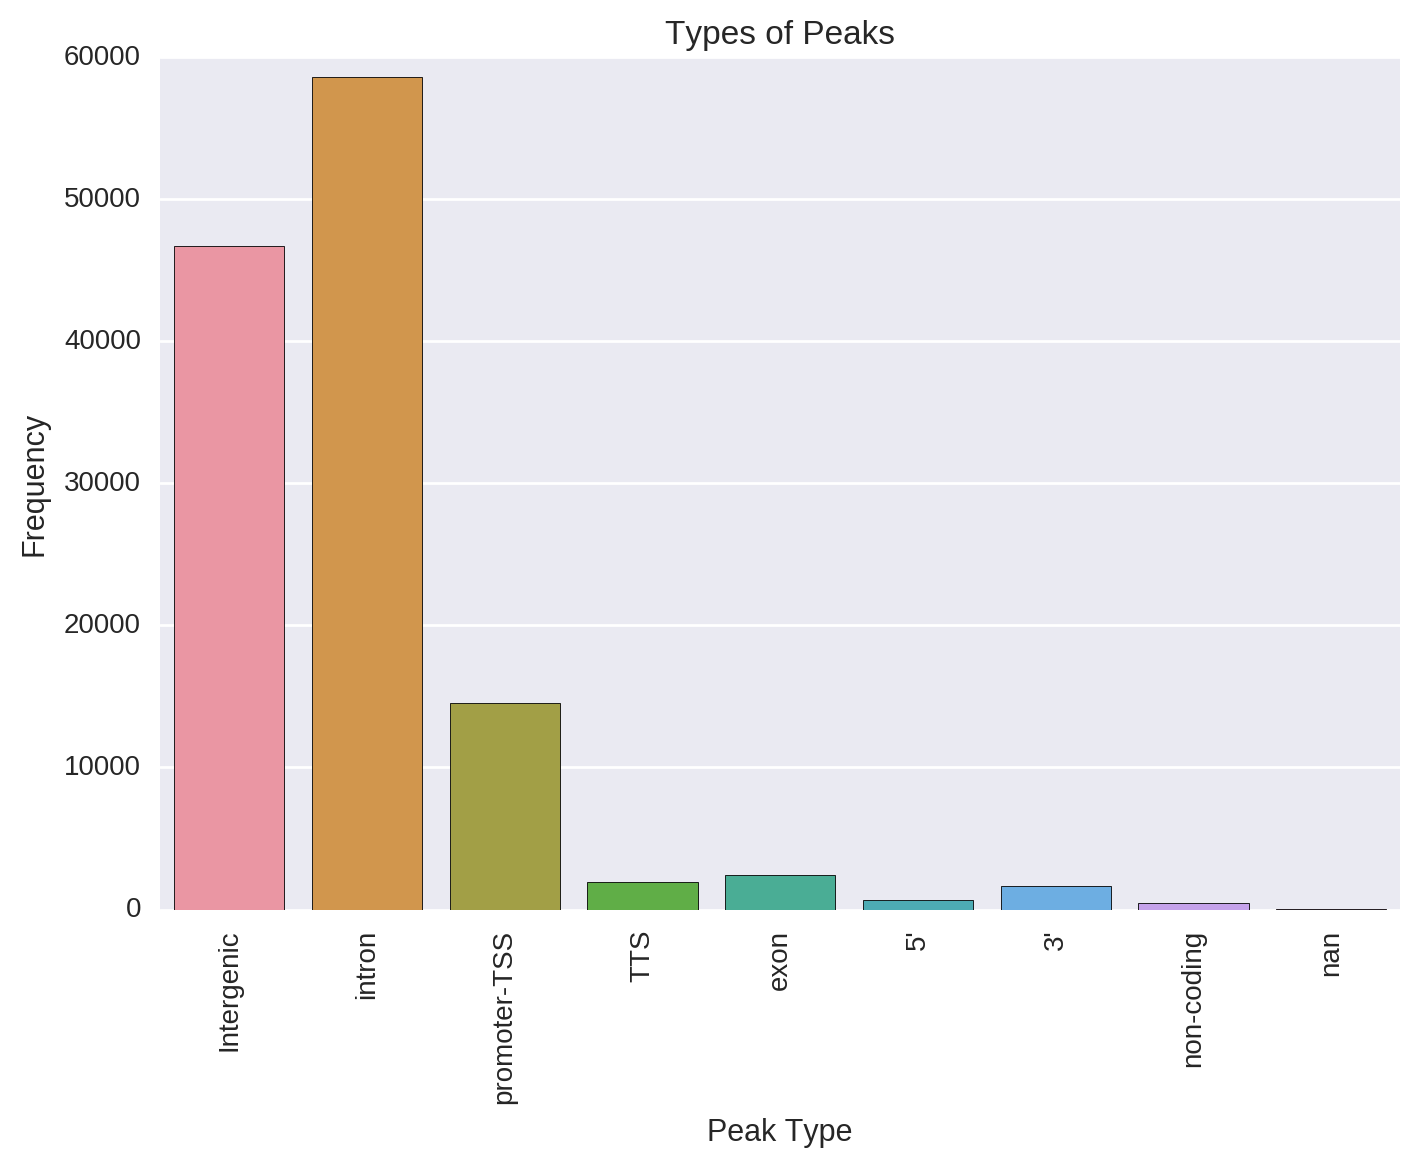

In [ ]:
### read in GRO and H3K27Ac scores

sense_frame = pd.read_csv('merged_annotated_peaks_sense.tsv', sep='\t')

antisense_frame = pd.read_csv('merged_annotated_peaks_antisense.tsv', sep='\t')

sense_frame.index=sense_frame.ix[:,0].values
columns = sense_frame.columns.values
columns[0] = 'ID'
columns = [x.split('/')[-1].split()[0] if '/' in x else x for x in columns]
sense_frame.columns = columns

antisense_frame.index=antisense_frame.ix[:,0].values
columns = antisense_frame.columns.values
columns[0] = 'ID'
columns = [x.split('/')[-1].split()[0] if '/' in x else x for x in columns]
antisense_frame.columns = columns

tagDirectories = sense_frame.columns[19:].values
experiment_tagDir_dict = {}
for td in tagDirectories:
    tokens = td.split('_')
    experiment = '_'.join(tokens[2:4])
    if experiment in experiment_tagDir_dict:
        experiment_tagDir_dict[experiment].append(td)
    else:
        experiment_tagDir_dict[experiment] = [td]

_enhancerMarks = sorted(experiment_tagDir_dict.keys())

annotation_frame = sense_frame[['Chr', 'Start', 'End', 'Strand']]
annotation_frame['Annotation'] = [str(x).split()[0] for x in sense_frame['Annotation'].values]

for experiment in _enhancerMarks:
    current_sense_frame = sense_frame[experiment_tagDir_dict[experiment]]
    current_antisense_frame = antisense_frame[experiment_tagDir_dict[experiment]]


    annotation_frame[experiment + ' +'] = np.mean(current_sense_frame, axis=1)
    annotation_frame[experiment + ' -'] = np.mean(current_antisense_frame, axis=1)
    print(experiment)

#     log_frame = np.log2(current_sense_frame+1)
#     log_frame.columns = [x + ' +' for x in log_frame.columns.values]
#     sns.pairplot(log_frame, size=7, kind= 'reg')
#     plt.savefig(experiment+'_sense_pairplot.png')
#     plt.close()
# #     plt.show()
    
#     log_frame = np.log2(current_antisense_frame+1)
#     log_frame.columns = [x + ' -' for x in log_frame.columns.values]
#     sns.pairplot(log_frame, size=7, kind= 'reg')
#     plt.savefig(experiment+'_antisense_pairplot.png')
#     plt.close()
# #     plt.show()
    


nonStrandSpecificExperiments = ['H3K27Ac_KLA', 'H3K27Ac_Veh']
for experiment in nonStrandSpecificExperiments:
    annotation_frame[experiment] = annotation_frame[experiment + ' +'] + annotation_frame[experiment + ' -']
    annotation_frame.drop(experiment + ' +', axis=1, inplace=True)
    annotation_frame.drop(experiment + ' -', axis=1, inplace=True)
    
# remove outlier GRO-seq values
# annotation_frame.loc[annotation_frame['Gro_Veh +'] > 10000, 'Gro_Veh +' ] = 0
# annotation_frame.loc[annotation_frame['Gro_KLA +'] > 10000, 'Gro_KLA +' ] = 0
# annotation_frame.loc[annotation_frame['Gro_Veh -'] > 10000, 'Gro_Veh -' ] = 0
# annotation_frame.loc[annotation_frame['Gro_KLA -'] > 10000, 'Gro_KLA -' ] = 0


sns.countplot(annotation_frame['Annotation'])
plt.title('Types of Peaks')
plt.xlabel('Peak Type')
plt.ylabel('Frequency')
plt.xticks(rotation=90);

annotation_frame.to_pickle('annotation_frame.pickle')


In [90]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



## Classifying Enhancers

In [ ]:
sns.distplot(np.log2(annotation_frame['Gro_Veh -']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['Gro_Veh +']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['Gro_KLA -']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['Gro_KLA +']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['H3K27Ac_KLA']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['H3K27Ac_Veh']+1))
plt.show()

In [ ]:
numClusters = 3
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'KLA' in x and not 'Active' in x]]
features = features[features.index.isin(intergenic_ids)]
scaler = preprocessing.MinMaxScaler()
normed_features = pd.DataFrame(scaler.fit_transform(np.log2(features + 1)))
normed_features.columns = features.columns
colorDict = dict(zip(range(numClusters+1),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))

cg = sns.clustermap(normed_features,yticklabels=False, col_cluster=False)
plt.close()
row_linkage = cg.dendrogram_row.linkage
            
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numClusters, criterion="maxclust")
            
row_colors = [colorDict[row_flatCluster[i]] for i in range(len(cg.data.index))]
sns.clustermap(normed_features,
             row_linkage = row_linkage,
             row_colors = row_colors,
             col_cluster=False,
             cmap="Blues",
             yticklabels = False
             )

In [ ]:
numClusters = 3
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'Veh' in x and not 'Active' in x]]
features = features[features.index.isin(intergenic_ids)]
scaler = preprocessing.MinMaxScaler()
normed_features = pd.DataFrame(scaler.fit_transform(np.log2(features + 1)))
normed_features.columns = features.columns
colorDict = dict(zip(range(numClusters+1),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))

cg = sns.clustermap(normed_features,yticklabels=False, col_cluster=False)
plt.close()
row_linkage = cg.dendrogram_row.linkage
            
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numClusters, criterion="maxclust")
            
row_colors = [colorDict[row_flatCluster[i]] for i in range(len(cg.data.index))]
sns.clustermap(normed_features,
             row_linkage = row_linkage,
             row_colors = row_colors,
             col_cluster=False,
             cmap="Blues",
             yticklabels = False
             )

In [ ]:
### Assign active versus inactive for KLA enhancers ###
numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))

# calculate k-means cluster for use in coloring
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'KLA ' in x]]
features = features[features.index.isin(intergenic_ids)]
normed_features = np.log2(features + 1)

print(features.shape)
# normed_features = sklearn.preprocessing.normalize(features, axis=1)
est = KMeans(n_clusters=2, n_jobs=4)
est.fit(normed_features)
colors = [colorDict[x] for x in est.labels_]

sns.jointplot(normed_features['Gro_KLA +'],
           normed_features['Gro_KLA -'],
           alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_KLA +'],
#            normed_features['H3K27Ac_KLA'],
#            alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_KLA -'],
#            normed_features['H3K27Ac_KLA'],
#            alpha=0.4, c=colors)


clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_features.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_kla_sense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values)
    gro_kla_antisense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values)
    h3k27ac_kla = list(annotation_frame[annotation_frame.index.isin(current_indices)]['H3K27Ac_KLA'].values)
   
        
    reads = reads + gro_kla_sense
    treatments = treatments + len(current_indices) * ['Gro +'] 
        
    reads = reads + gro_kla_antisense
        
    treatments = treatments + len(current_indices) * ['Gro -'] 
        
    reads = reads + h3k27ac_kla

    treatments = treatments + len(current_indices) * ['H3K27Ac']

    clusters = clusters + 3 * len(current_indices) * [str(cluster)]
        
reads = np.log2(np.array(reads) + 1)
data_frame = pd.DataFrame({'reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})
print('cluster 0:',np.sum(data_frame['cluster']=='0')/3,
     'cluster 1:',np.sum(data_frame['cluster']=='1')/3)
sns.factorplot(x='cluster',y='reads', hue='treatment', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.4,
                whis=1,
                showfliers=False)
# plt.ylim([0,12])
plt.show()

### assign activity according to the mean H3K27Ac value of each cluster ###
cluster_mean_0 = np.mean(data_frame[(data_frame['cluster']=='0') & (data_frame['treatment']=='H3K27Ac')]['reads'])
cluster_mean_1 = np.mean(data_frame[(data_frame['cluster']=='1') & (data_frame['treatment']=='H3K27Ac')]['reads'])
if cluster_mean_0 < cluster_mean_1:
    # cluster 1 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values,
                                     [True if x == 1 else False for x in est.labels_]))
else:
    # cluster 0 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values,
                                     [True if x == 0 else False for x in est.labels_]))
annotation_frame['Active Enhancer KLA'] = [index_activity_dict[x] for x in annotation_frame.index.values]


In [ ]:
### Assign active versus inactive for VEH enhancers ###
numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))

# calculate k-means cluster for use in coloring
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'Veh ' in x]]
features = features[features.index.isin(intergenic_ids)]
normed_features = np.log2(features + 1)

print(features.shape)
# normed_features = sklearn.preprocessing.normalize(features, axis=1)
est = KMeans(n_clusters=2, n_jobs=4)
est.fit(normed_features)
colors = [colorDict[x] for x in est.labels_]

sns.jointplot(normed_features['Gro_Veh +'],
           normed_features['Gro_Veh -'],
           alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_Veh +'],
#            normed_features['H3K27Ac_Veh'],
#            alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_Veh -'],
#            normed_features['H3K27Ac_Veh'],
#            alpha=0.4, c=colors)


clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_features.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh_sense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values)
    gro_veh_antisense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values)
    h3k27ac_veh = list(annotation_frame[annotation_frame.index.isin(current_indices)]['H3K27Ac_Veh'].values)
   
    
    reads = reads + gro_veh_sense
    treatments = treatments + len(current_indices) * ['Gro +']
    
    reads = reads + gro_veh_antisense
        
    treatments = treatments + len(current_indices) * ['Gro -']
    
    reads = reads + h3k27ac_veh

    treatments = treatments + len(current_indices) * ['H3K27Ac']

    clusters = clusters + 3 * len(current_indices) * [str(cluster)]
    
reads = np.log2(np.array(reads) + 1)
data_frame = pd.DataFrame({'reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})
print('cluster 0:',np.sum(data_frame['cluster']=='0')/3,
     'cluster 1:',np.sum(data_frame['cluster']=='1')/3)
sns.factorplot(x='cluster',y='reads', hue='treatment', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.4,
                whis=1,
                showfliers=False)
# plt.ylim([0,12])
plt.show()

### assign activity according to the mean H3K27Ac value of each cluster ###
cluster_mean_0 = np.mean(data_frame[(data_frame['cluster']=='0') & (data_frame['treatment']=='H3K27Ac')]['reads'])
cluster_mean_1 = np.mean(data_frame[(data_frame['cluster']=='1') & (data_frame['treatment']=='H3K27Ac')]['reads'])
if cluster_mean_0 < cluster_mean_1:
    # cluster 1 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values, 
                                     [True if x == 1 else False for x in est.labels_]))
else:
    # cluster 0 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values, 
                                     [True if x == 0 else False for x in est.labels_]))
annotation_frame['Active Enhancer Veh'] = [index_activity_dict[x] for x in annotation_frame.index.values]

### Read in motif scores

In [ ]:
motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs/'
# motif_dir = '/home/jenhan/analysis/cobinding_motif_analysis/fimo_motifs_jaspar_2014/'

peak_start_dict = dict(zip(summary_frame['ID'].values, summary_frame['start'].values))

motif_score_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_score_frame.index=motif_score_frame['ID'].values

motif_sequence_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_sequence_frame.index=motif_score_frame['ID'].values

motif_strand_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_strand_frame.index=motif_score_frame['ID'].values

motif_start_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_start_frame.index=motif_score_frame['ID'].values

motif_end_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_end_frame.index=motif_score_frame['ID'].values

motif_count_frame = summary_frame[['ID', 'Factors', 'chr']]
motif_count_frame.index = motif_count_frame['ID'].values

counter=0
for m in sorted(os.listdir(motif_dir)):
    counter+=1
    if '.fimo' in m:
        print(counter,m)
        motif_results = './fimo_results//merged_' + m.replace('.fimo','') +'.txt'
        fimo_result_frame=pd.read_csv(motif_results, 
                                      skiprows=1,
                                      names=['motif_name', 
                                             'peak_id', 
                                             'start', 
                                             'stop', 
                                             'strand', 
                                             'score', 
                                             'pvalue', 
                                             'sequence'],
                                      sep='\t')
        motif_name = m.replace('.fimo','')
        id_score_dict = {}
        id_strand_dict = {}
        id_sequence_dict = {}
        id_start_dict = {}
        id_end_dict = {}
        id_count_dict = {}
        
        ids = fimo_result_frame['peak_id'].values
        scores = fimo_result_frame['score'].values
        strands = fimo_result_frame['strand'].values
        sequences = fimo_result_frame['sequence']
        starts = fimo_result_frame['start']
        ends = fimo_result_frame['stop']
        
        for i in range(len(ids)):
            currentScore = float(scores[i])
            currentSequence = sequences[i]
            currentStrand = strands[i]
            currentStart = int(starts[i])
            currentEnd = int(ends[i])
            if currentScore < 0.0:
                currentScore = 0.0
            if ids[i] in id_score_dict:
                if currentScore > id_score_dict[ids[i]]:
                    id_score_dict[ids[i]] = currentScore
                    id_sequence_dict[ids[i]] = currentSequence
                    id_strand_dict[ids[i]] = currentStrand
                    id_start_dict[ids[i]] = currentStart
                    id_end_dict[ids[i]] = currentEnd
                    id_count_dict[ids[i]] += 1
            else:
                id_score_dict[ids[i]] = currentScore
                id_sequence_dict[ids[i]] = currentSequence
                id_strand_dict[ids[i]] = currentStrand
                id_start_dict[ids[i]] = currentStart
                id_end_dict[ids[i]] = currentEnd
                id_count_dict[ids[i]] = 0
                
        motif_score_frame[motif_name] = [id_score_dict[x] if x in id_score_dict else 0 for x in motif_score_frame['ID'].values]
        motif_sequence_frame[motif_name] = [id_sequence_dict[x] if x in id_sequence_dict else '?' for x in motif_sequence_frame['ID'].values]
        motif_strand_frame[motif_name] = [id_strand_dict[x] if x in id_score_dict else '' for x in motif_strand_frame['ID'].values]
        motif_start_frame[motif_name] = [id_start_dict[x] + peak_start_dict[x] if x in id_start_dict else -1 for x in motif_start_frame['ID'].values]
        motif_end_frame[motif_name] = [id_end_dict[x] + peak_start_dict[x] if x in id_end_dict else -1 for x in motif_end_frame['ID'].values]
        motif_count_frame[motif_name] = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_count_frame['ID'].values]

        
motif_score_frame.to_pickle('motif_score_frame.pickle')
motif_score_frame.to_csv('motif_scores.tsv', sep='\t', index=False)

motif_sequence_frame.to_pickle('motif_sequence_frame.pickle')
motif_sequence_frame.to_csv('motif_sequence.tsv', sep='\t', index=False)

motif_strand_frame.to_pickle('motif_strand_frame.pickle')
motif_strand_frame.to_csv('motif_strand.tsv', sep='\t', index=False)

motif_start_frame.to_pickle('motif_start_frame.pickle')
motif_start_frame.to_csv('motif_start_frame.tsv', sep='\t', index=False)

motif_end_frame.to_pickle('motif_end_frame.pickle')
motif_end_frame.to_csv('motif_end_frame.tsv', sep='\t', index=False)

motif_count_frame.to_pickle('motif_count_frame.pickle')
motif_count_frame.to_csv('motif_count_frame.tsv', sep='\t', index=False)

scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

scaled_motif_frame = pd.DataFrame()
for m in motif_score_frame.columns[3:]:
    scaled_motif_frame[m] = motif_score_frame[m]/(2*motif_sequence_frame[m].str.len().max())
    
    
# motif_interaction_frame = pd.DataFrame(
#     sklearn.preprocessing.PolynomialFeatures(
#         degree=2, interaction_only=True).fit_transform(motif_score_frame.ix[:,3:])
# ).ix[:,1:]
# motifs = motif_score_frame.columns.values[3:]
# interaction_term_columns = list(motifs)
# for i in range(len(motifs)-1):
#     for j in range(i+1,len(motifs)):
#         interaction_term_columns.append(motifs[i]+'::'+motifs[j])
# motif_interaction_frame.columns = interaction_term_columns
# motif_interaction_frame.index = motif_score_frame.index.values

1 alx1_alx4_arx.fimo
2 ap-1.fimo
3 ar_nr3c1_nr3c2.fimo
4 arid3a.fimo
5 arid3b.fimo
6 arid5a.fimo
7

In [157]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
intergenic_motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
intergenic_scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
# motif_interaction_frame = motif_interaction_frame[motif_interaction_frame.index.isin(intergenic_ids)]
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]




## Analysis of motif scores

In [ ]:
sns.distplot(motif_score_frame.ix[:,3:].max(axis=0))
plt.title('Distribution of max un-normalized motif score')
plt.xlabel('Un-normalized motif score')

In [ ]:
### test motif scores for normality - which justifies the use of standardization
for motif in motif_score_frame.columns.values[3:]:
    w, pval = scipy.stats.mstats.normaltest(motif_score_frame[motif].values)
    if pval > 0.01:
        print(motif, pval)
    

In [ ]:
### plot variance of motif scores

sns.distplot(motif_score_frame.ix[:,3:].var())
plt.title('Un-normalized motif score variance')
plt.show()



In [ ]:
### plot variance of motif scores

sns.distplot(normed_motif_frame.var())
plt.title('Normalized motif score variance')
plt.xlim(-0.2, 0.2)
plt.show()




### Plot Distributions of motif scores

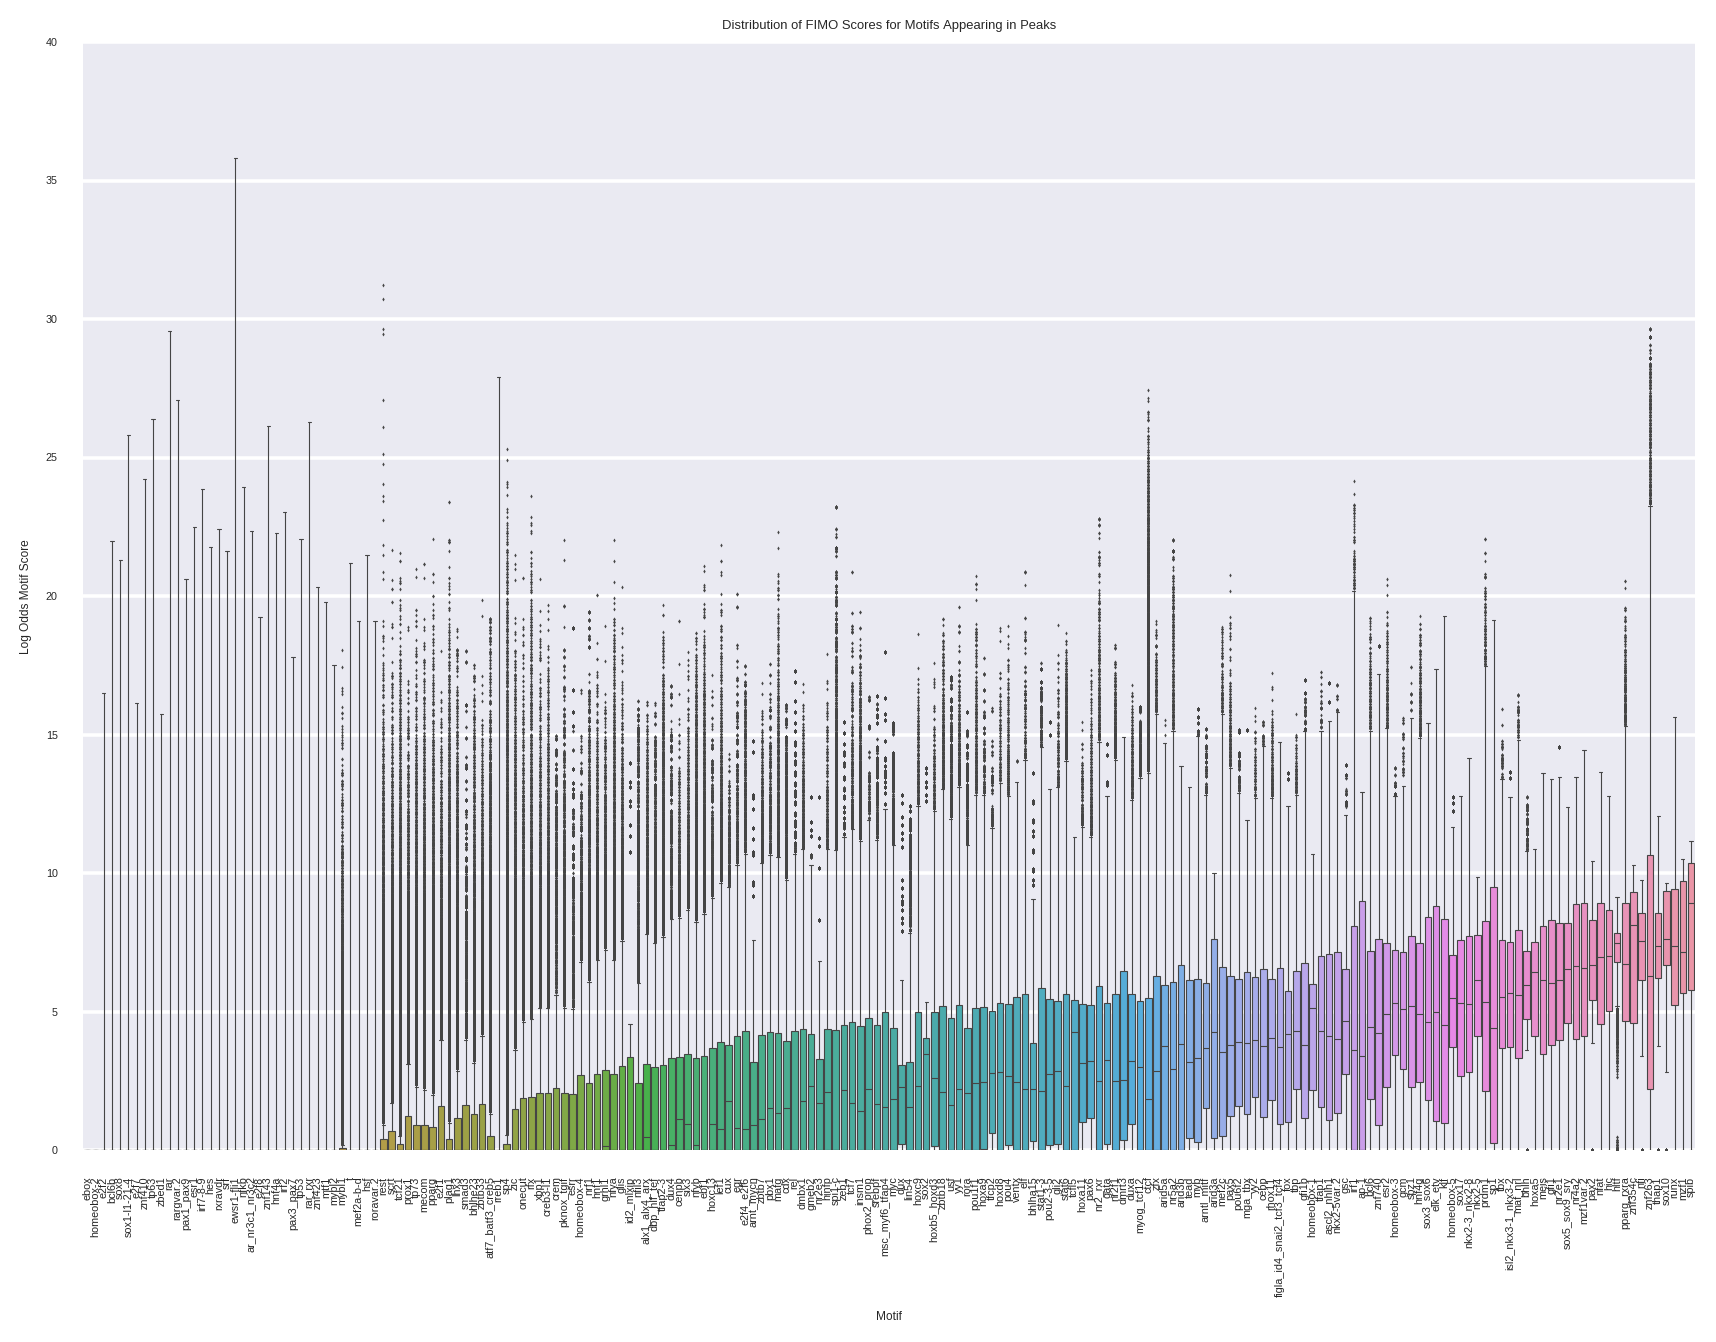

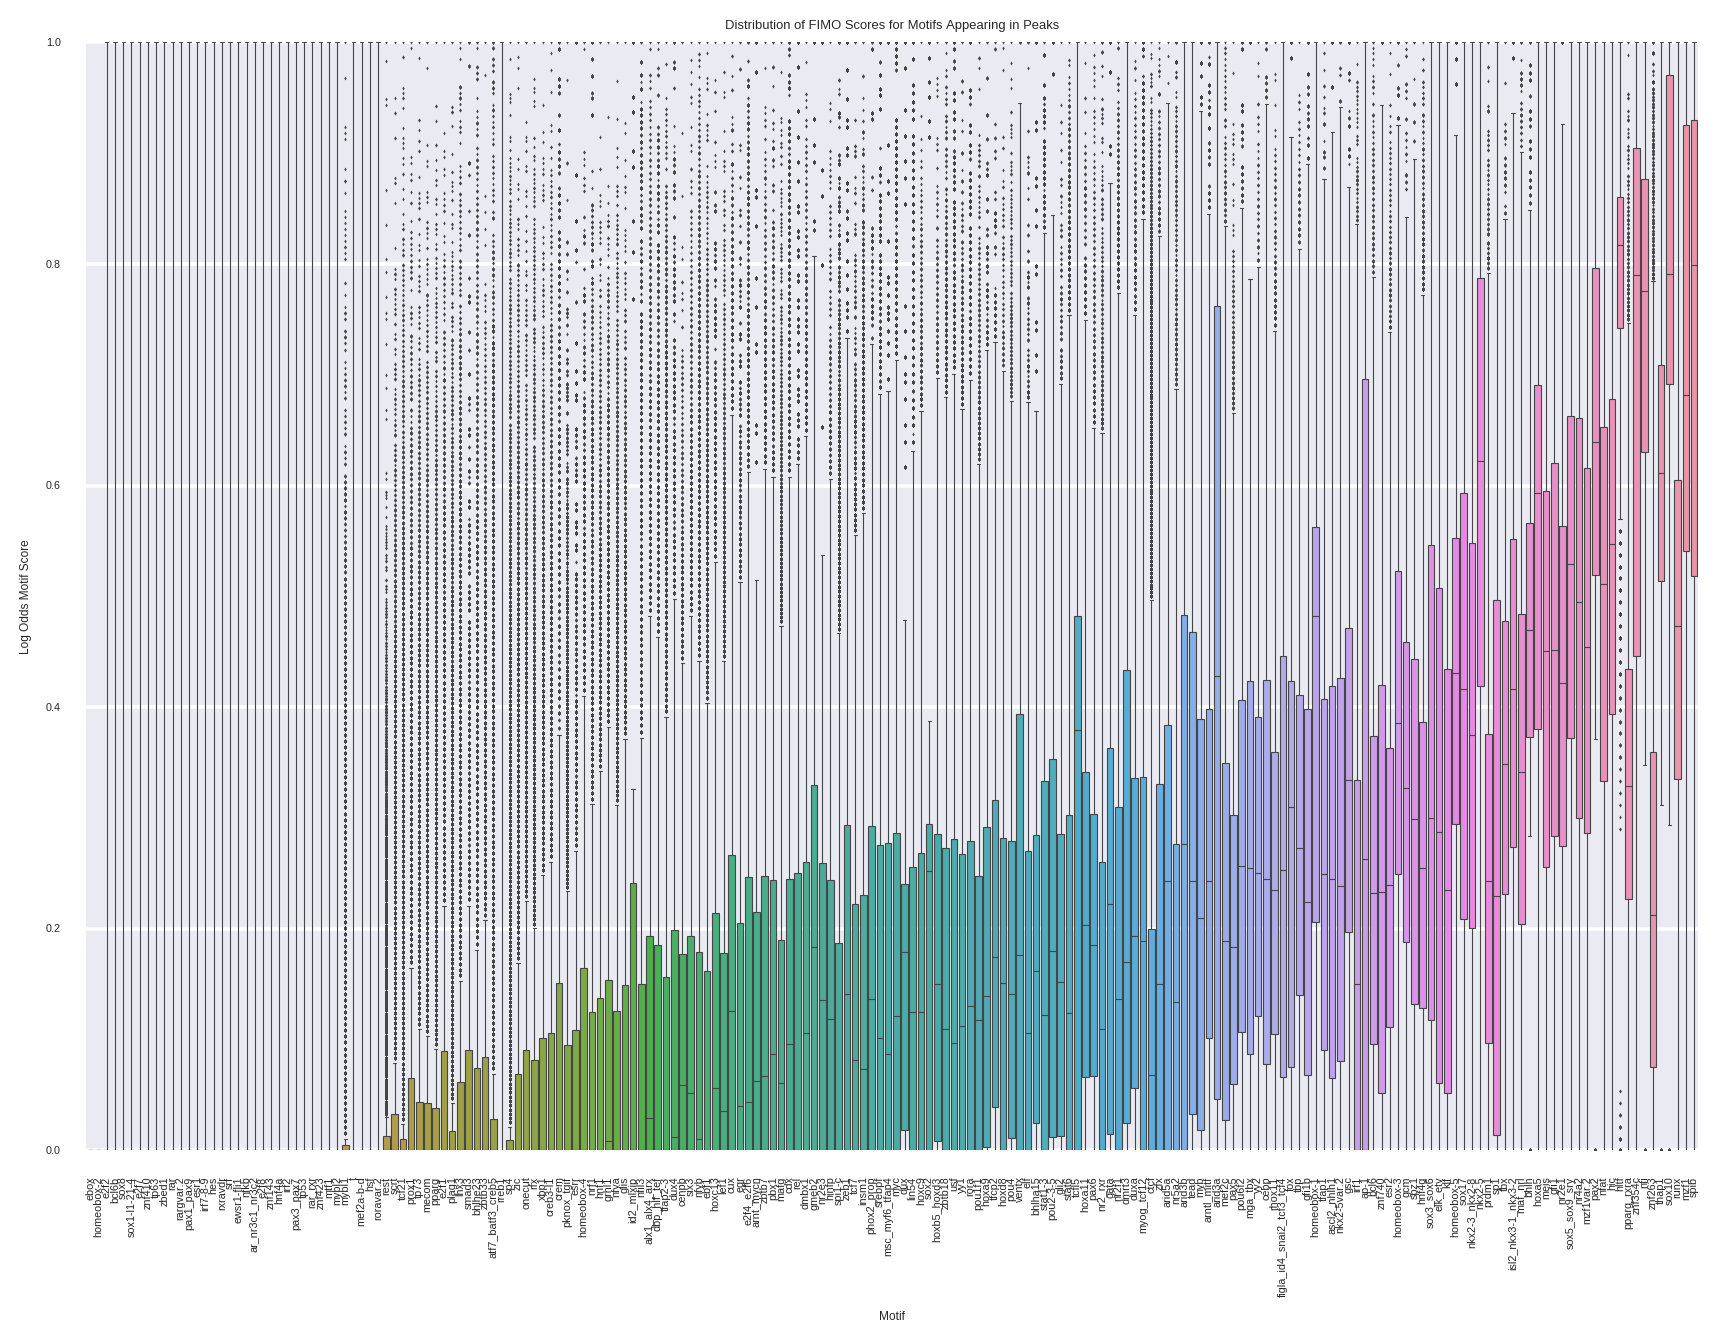

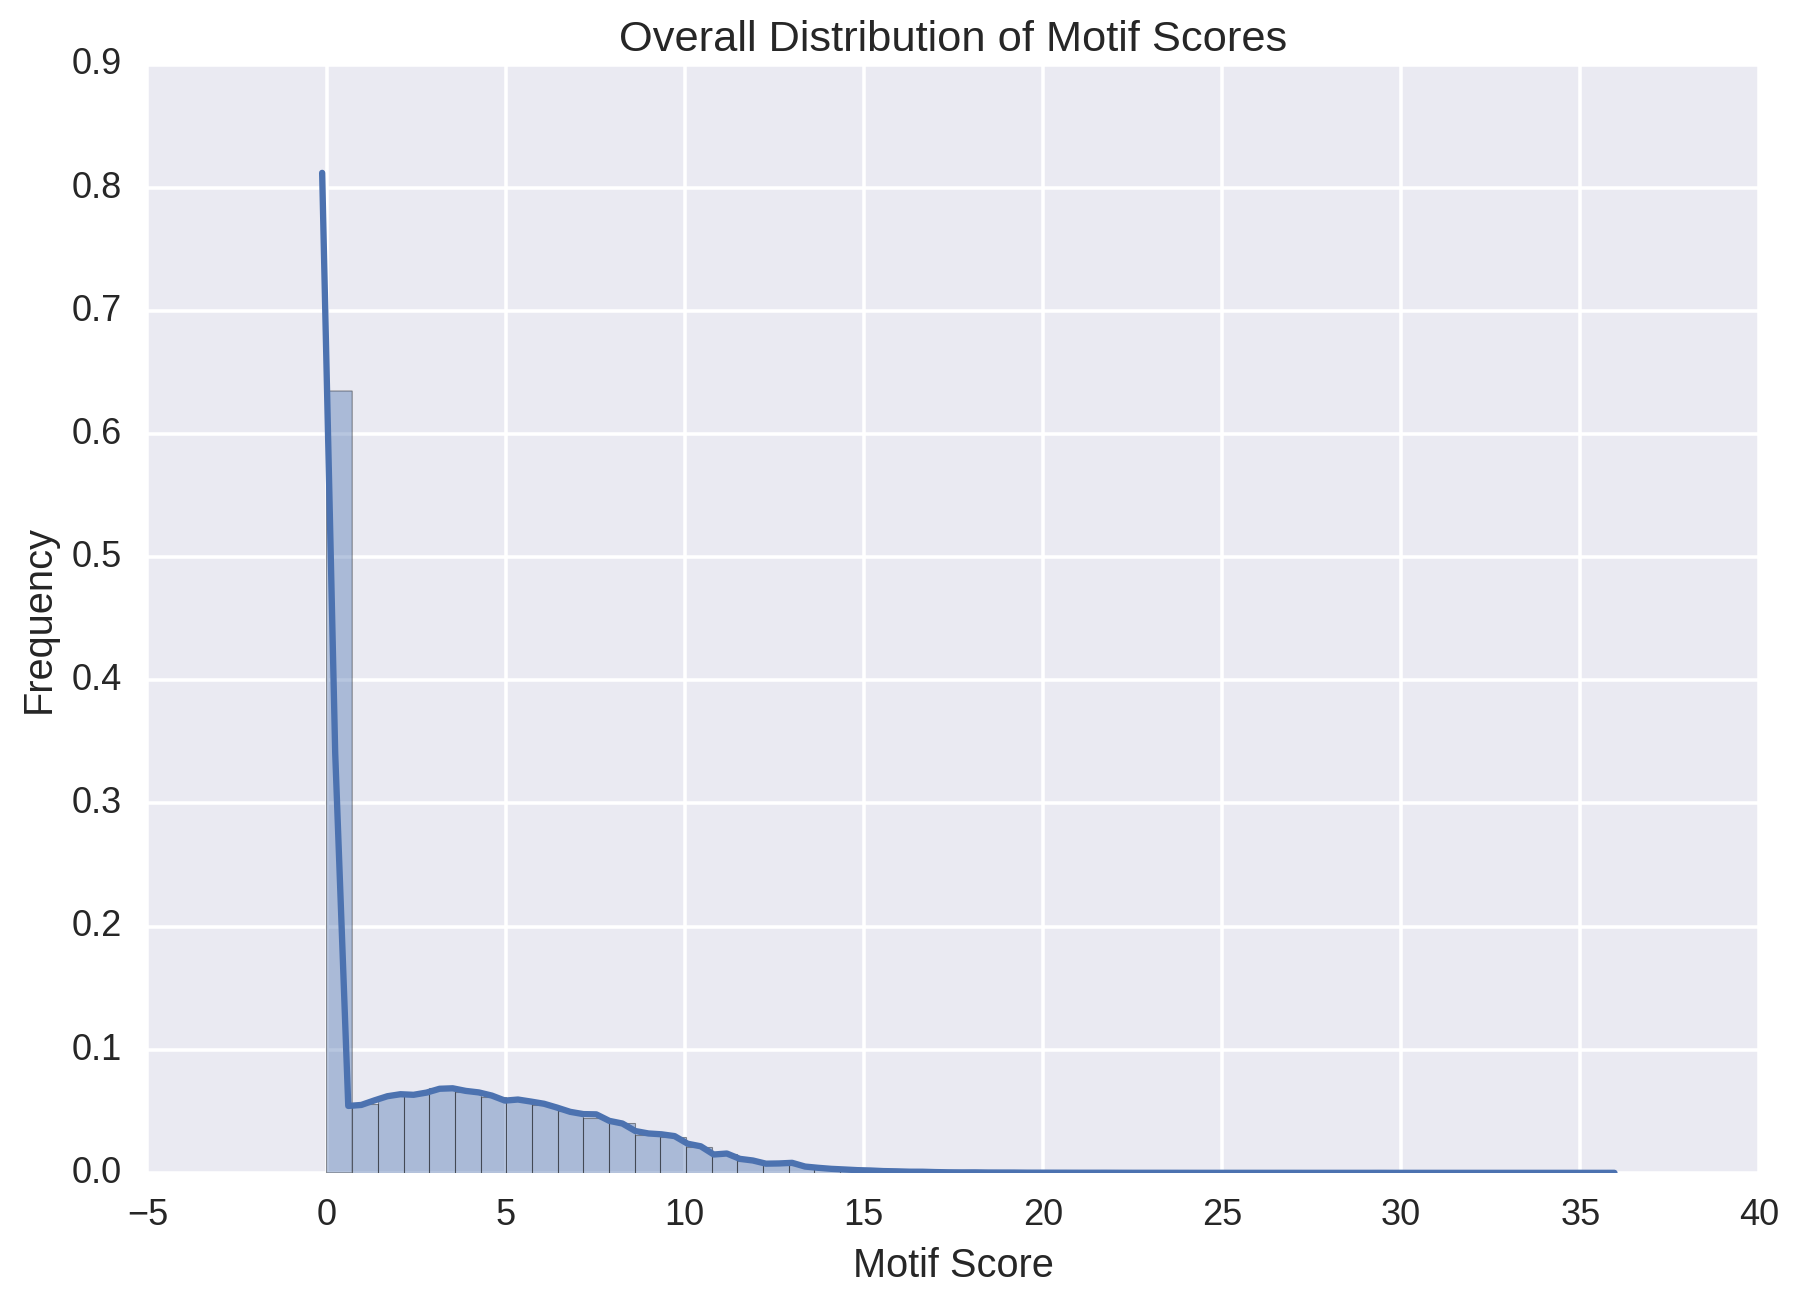

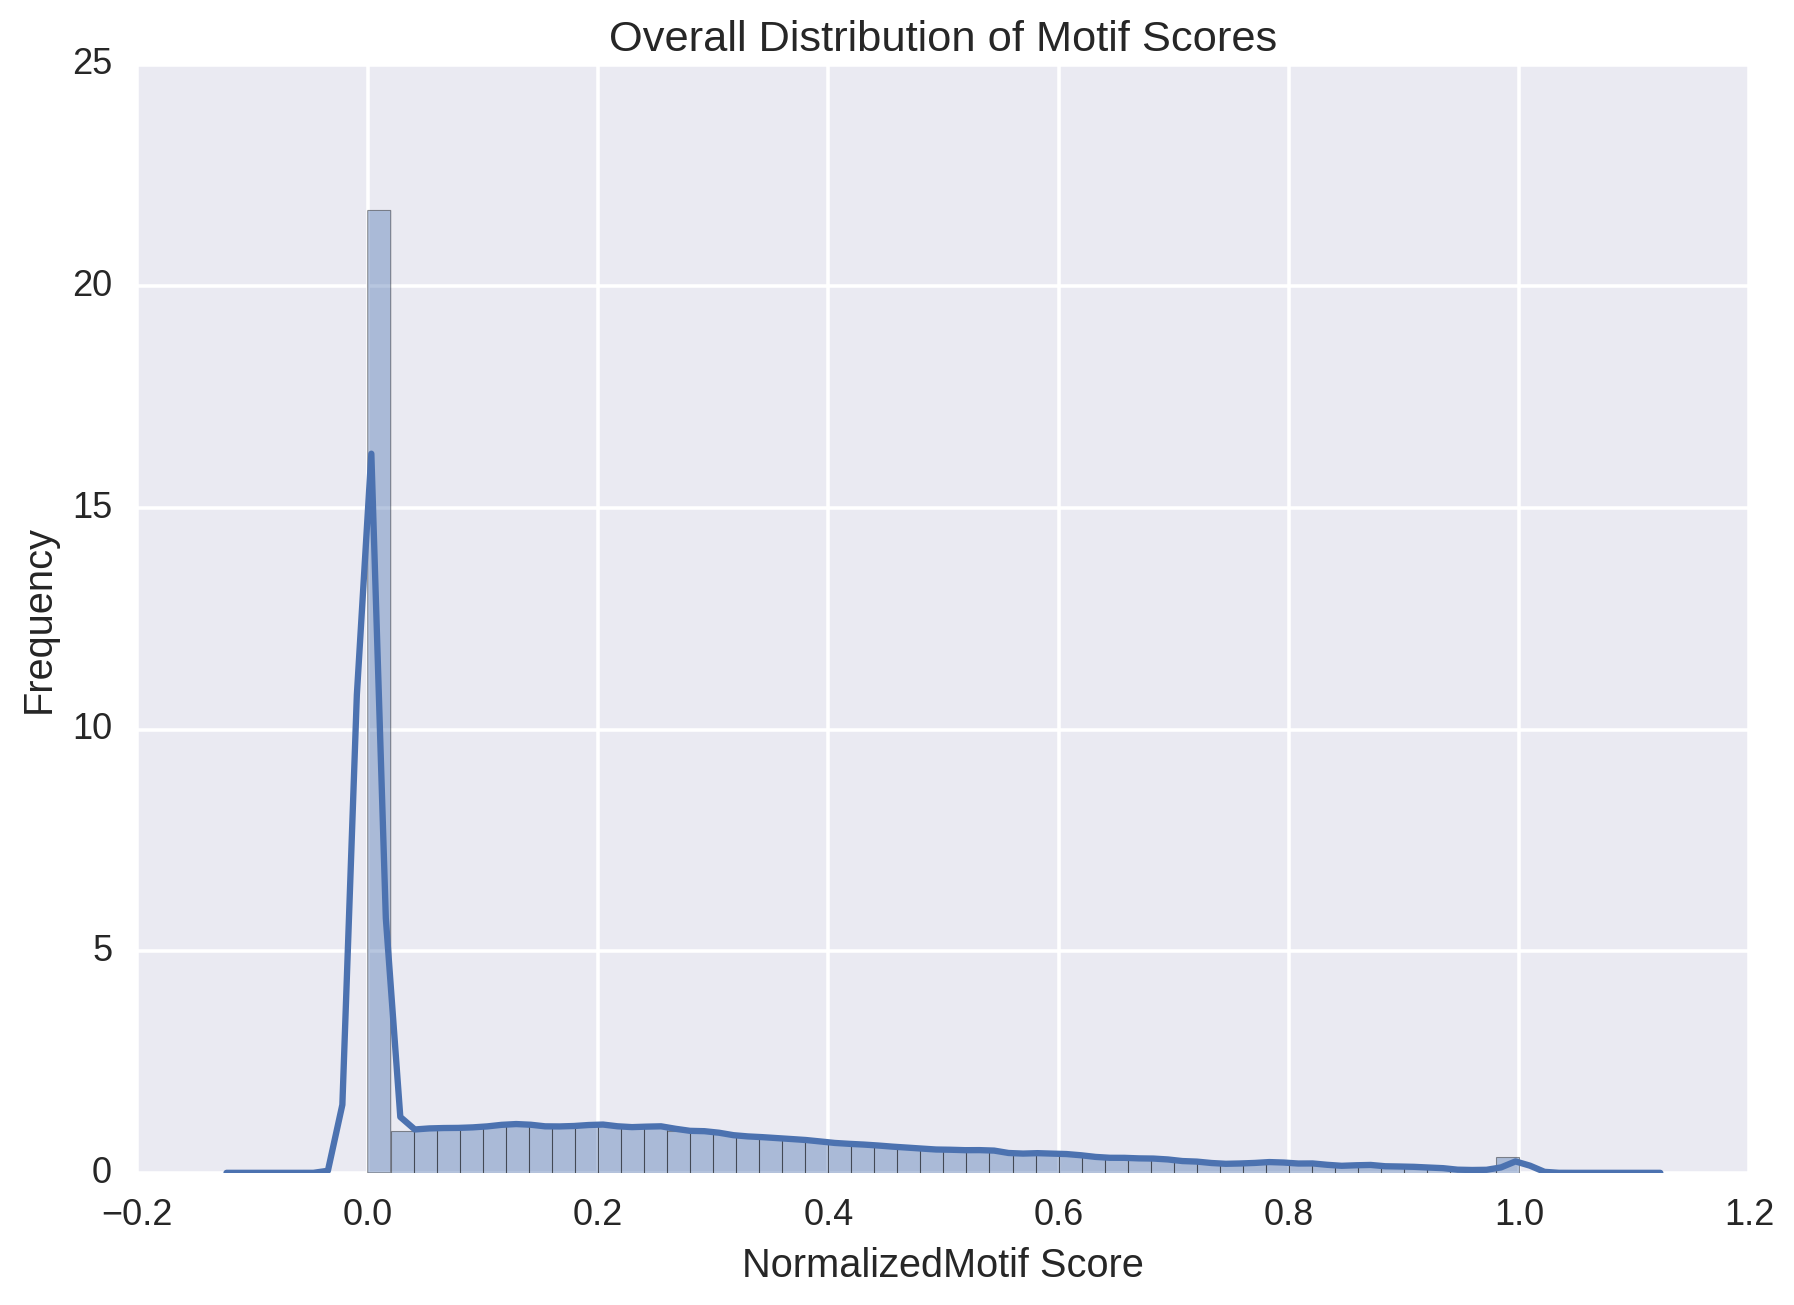

In [153]:
# plot distribution of motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in motif_score_frame.columns[3:]:
    data_dict[col] = motif_score_frame[col].values
    sort_list.append((col, np.mean(motif_score_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.4,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
plt.show()
del data_dict
sns.set_context('talk', font_scale=1.0)

# plot distribution of normed motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in normed_motif_frame.columns:
    data_dict[col] = normed_motif_frame[col].values
    sort_list.append((col, np.mean(motif_score_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.4,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
del data_dict
plt.show()
sns.set_context('talk', font_scale=1.0)

sns.distplot(motif_score_frame.ix[:,3:].values.flatten())
plt.title('Overall Distribution of Motif Scores')
plt.xlabel('Motif Score')
plt.ylabel('Frequency')
plt.show()
sns.distplot(normed_motif_frame.ix[:,3:].values.flatten())
# plt.xlim(-0.05, 0.05)
plt.title('Overall Distribution of Motif Scores')
plt.xlabel('NormalizedMotif Score')
plt.ylabel('Frequency')

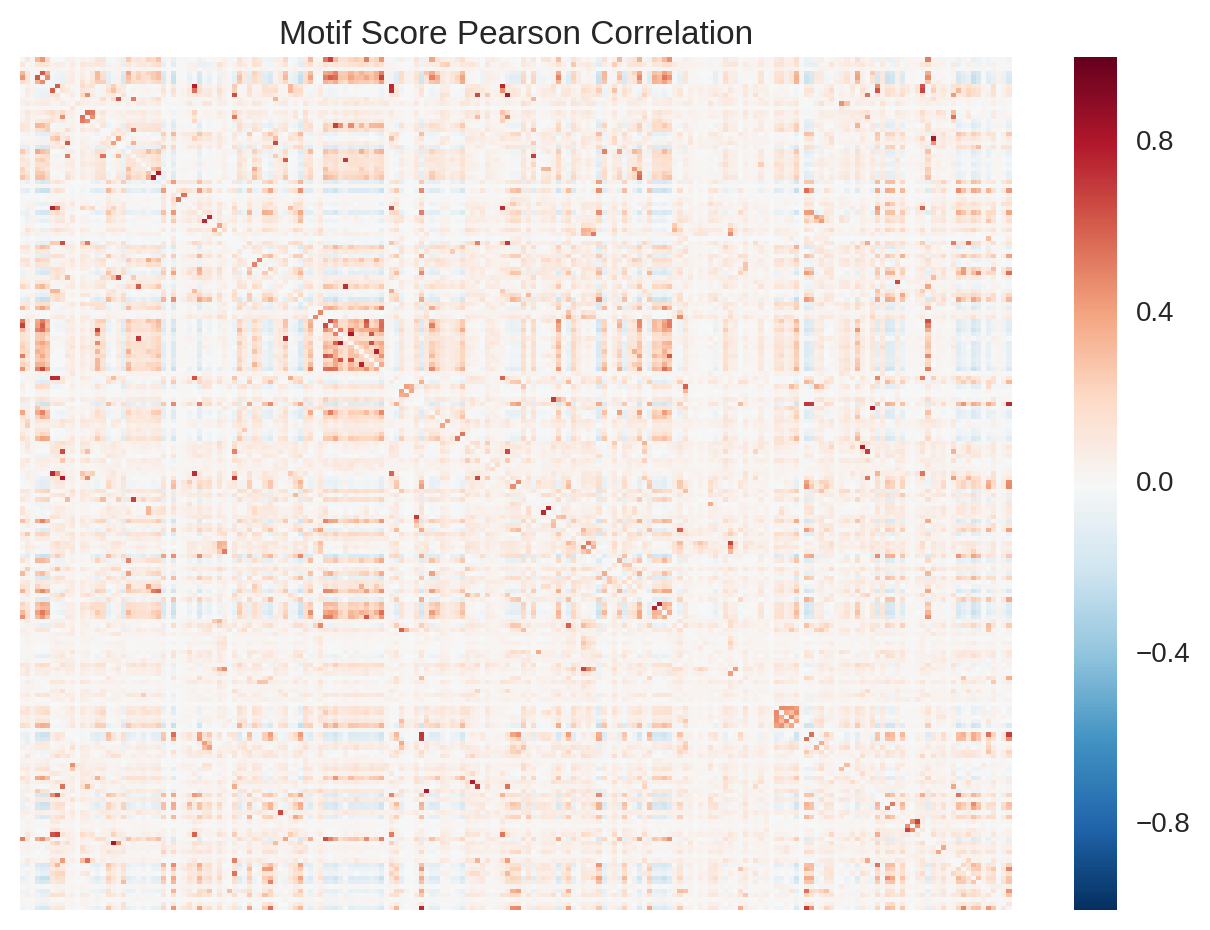

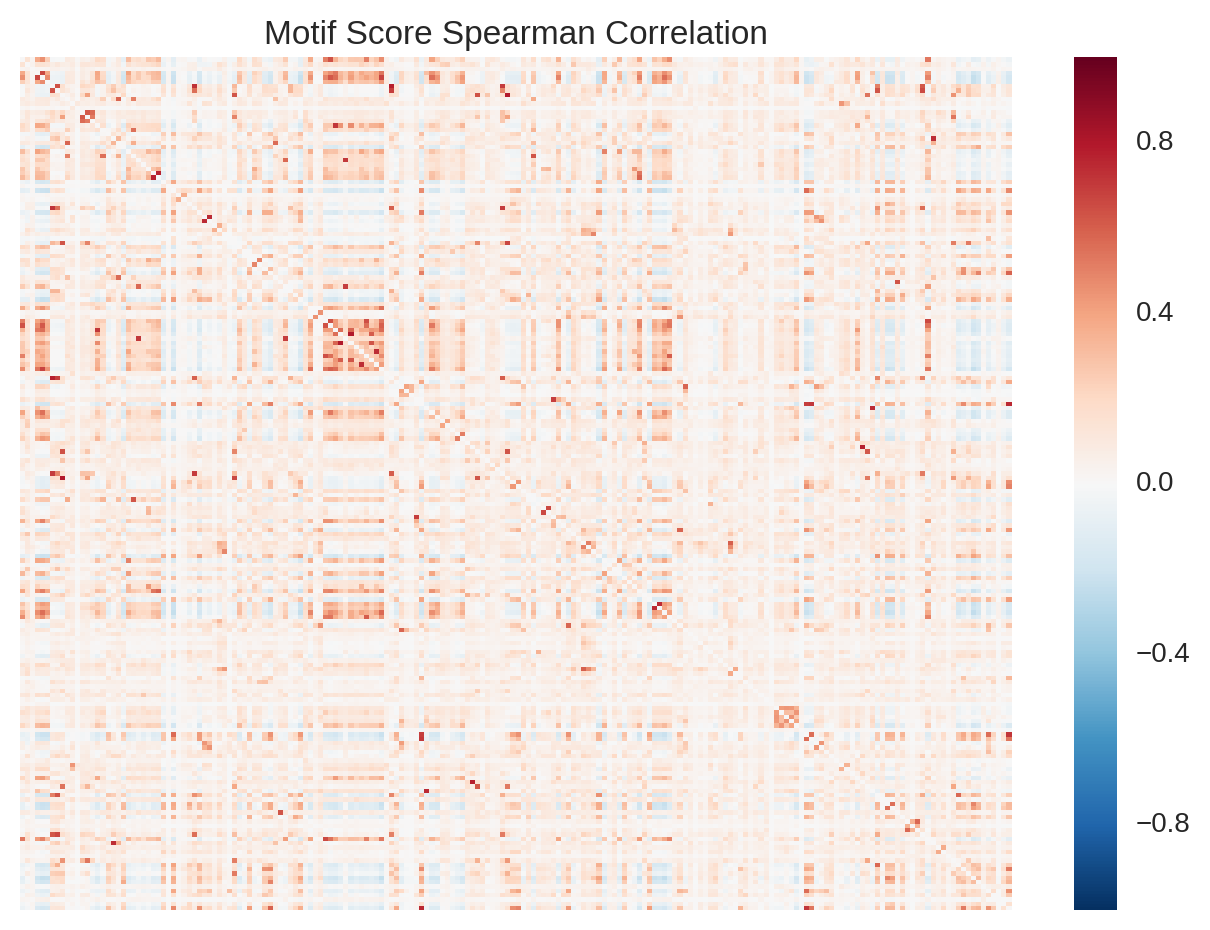

In [93]:
# Show how motif scores correlate to one another
# plot distribution of motif scores
data_dict = {}
count = 0
sort_list = []
motifs = motif_score_frame.columns[3:]
motif_corr_pearson_matrix = np.zeros((len(motifs), len(motifs)))
motif_corr_spearman_matrix = np.zeros((len(motifs), len(motifs)))
# for every pair of motifs
for i in range(len(motifs) -1 ):
    for j in range(i+1, len(motifs)):
        motif1 = motifs[i]
        motif2 = motifs[j]
        # get relevant motif scores
        motifScores1 = motif_score_frame[motif1].values
        motifScores2 = motif_score_frame[motif2].values
        # calculate spearman and peason correlation
        r, p_val_pearson = scipy.stats.pearsonr(motifScores1, motifScores2)
        rho, p_val_spearman = scipy.stats.spearmanr(motifScores1, motifScores2)
        # fill in position in matrix
        motif_corr_pearson_matrix[i][j] = r
        motif_corr_spearman_matrix[i][j] = rho
        motif_corr_pearson_matrix[j][i] = r
        motif_corr_spearman_matrix[j][i] = rho


# create data frames
motif_corr_pearson_frame = pd.DataFrame(motif_corr_pearson_matrix)
motif_corr_spearman_frame = pd.DataFrame(motif_corr_spearman_matrix)

motif_corr_pearson_frame = motif_corr_pearson_frame.fillna(0)
motif_corr_pearson_frame.columns = motifs
motif_corr_pearson_frame.index = motifs

motif_corr_spearman_frame = motif_corr_spearman_frame.fillna(0)
motif_corr_spearman_frame.columns = motifs
motif_corr_spearman_frame.index = motifs

sns.heatmap(motif_corr_pearson_frame,xticklabels = False, yticklabels = False, vmax=1.0)
plt.title('Motif Score Pearson Correlation')
plt.show()

sns.heatmap(motif_corr_spearman_frame,xticklabels = False, yticklabels = False, vmax=1.0)
plt.title('Motif Score Spearman Correlation')
plt.show()

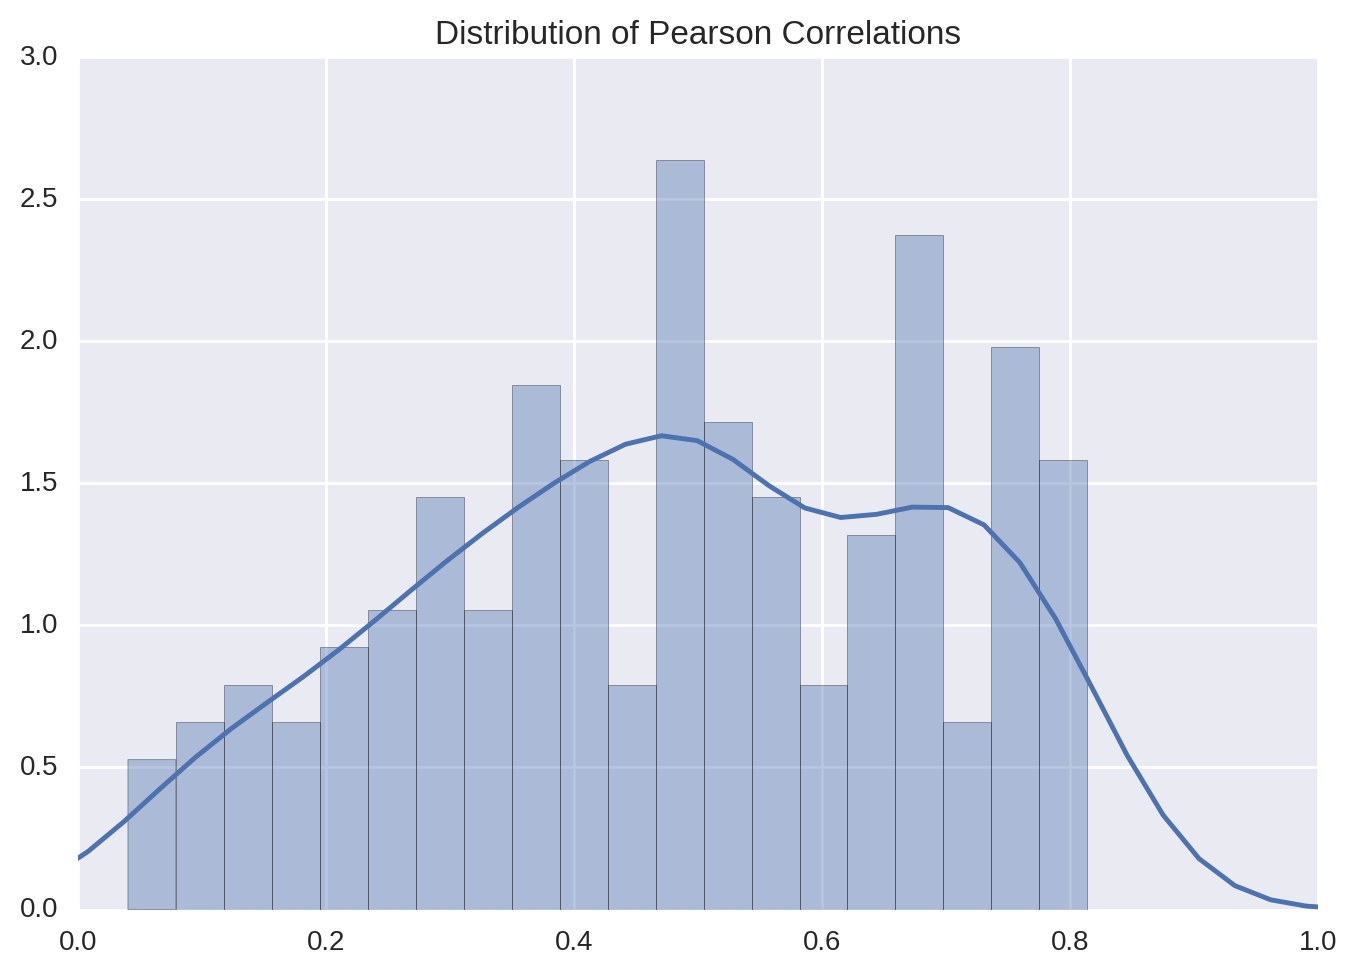

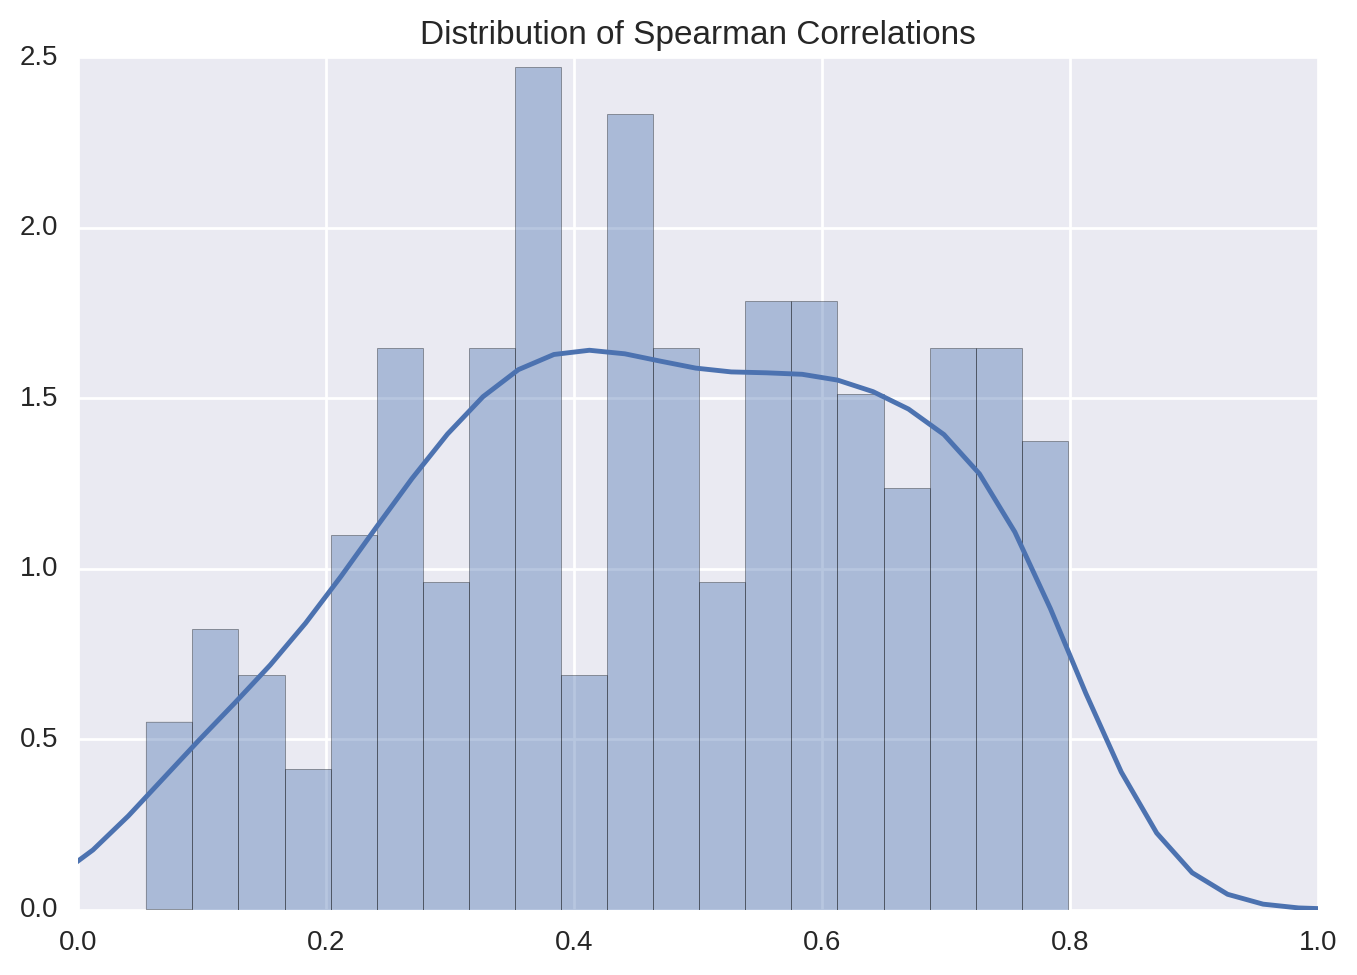

In [94]:
sns.distplot(motif_corr_pearson_frame.max(), bins=20)
plt.xlim(0,1)
plt.title('Distribution of Pearson Correlations')
plt.show()
sns.distplot(motif_corr_spearman_frame.max(), bins=20)
plt.xlim(0,1)
plt.title('Distribution of Spearman Correlations')

## Clustering

In [ ]:
### hierarchically cluster peaks in vehicle conditions and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + 
                     sns.color_palette("Set1") + 
                     sns.color_palette("Set2") + 
                     sns.color_palette("husl") +
                     sns.color_palette("Paired")
                    ))

indices = summary_frame[(summary_frame['Factors'].str.contains('_veh'))].index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if '_veh' in x and not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
logged_data = np.log2(data+1)

est = KMeans(n_clusters=numClusters, n_jobs=4)
est.fit(logged_data.ix[:,4:])
colors = [colorDict[x] for x in est.labels_]

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          cmap='Blues',
          row_colors=colors)


In [ ]:
### hierarchically cluster peaks in KLA condition and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

indices = summary_frame[(summary_frame['Factors'].str.contains('_kla'))].index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if '_kla' in x and not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
logged_data = np.log2(data+1)

est = KMeans(n_clusters=numClusters, n_jobs=4)
est.fit(logged_data.ix[:,4:])
colors = [colorDict[x] for x in est.labels_]

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          cmap='Reds',
          row_colors=colors)





In [ ]:
### hierarchically cluster peaks in all condition and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

indices = summary_frame.index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
logged_data = np.log2(data+1)

est = KMeans(n_clusters=numClusters, n_jobs=4)
est.fit(logged_data.ix[:,4:])
colors = [colorDict[x] for x in est.labels_]

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          col_cluster=False,
          row_colors=colors)





## De Novo Motif Analysis

In [ ]:
if not os.path.isdir('./denovo_motif_analysis'):
    os.mkdir('./denovo_motif_analysis')
else:
    ! rm -rf ./denovo_motif_analysis/*
    
if not os.path.isdir('./denovo_motif_analysis/veh_peaks'):
    os.mkdir('./denovo_motif_analysis/veh_peaks')
else:
    ! rm -rf ./denovo_motif_analysis/veh_peaks*
    
if not os.path.isdir('./denovo_motif_analysis/kla_peaks'):
    os.mkdir('./denovo_motif_analysis/kla_peaks')
else:
    ! rm -rf ./denovo_motif_analysis/kla_peaks*

In [ ]:
### for interesting vehicle groups ###
veh_groups = [
['pu1'],
['pu1', 'cebpa'],
['pu1', 'cebpa', 'cjun'],
['pu1', 'cjun'],
['cjun', 'atf3'],
['cjun'],
['cebpa'],
    ['atf3']
    ]

# get set of factors that appear in interesting groups
factors = set()
for group in veh_groups:
    for f in group:
        factors.add(f)
factors = sorted(list(factors))
index_factors_tuples = tuple(zip(summary_frame.index.values, summary_frame['Factors'].values))

# get summary frame subset with relevant columns and updated factors column
indices_with_targetFactors = []
updated_factors_list = []
for index, factorsAtPeak in index_factors_tuples:
    updated_factors = ','.join(sorted(set([x for x in factorsAtPeak.split(',') if not 'kla' in x and x.split('_')[0] in factors])))
    if updated_factors:
        indices_with_targetFactors.append(index)
        updated_factors_list.append(updated_factors)
index_updatedFactors_dict = dict(zip(indices_with_targetFactors, updated_factors_list))
current_frame = summary_frame[summary_frame.index.isin(indices_with_targetFactors)]\
[['chr', 'Position','ID'] + [x+'_veh' for x in factors]]
current_frame['Factors'] = [index_updatedFactors_dict[x] for x in current_frame['ID'].values]

for factor_group in sorted(set(current_frame['Factors'])):
    current_peak_frame = current_frame[current_frame['Factors']==factor_group]
    current_peak_frame['start'] = [x.split(':')[1].split('-')[0] for x in current_peak_frame['Position'].values]
    current_peak_frame['end'] = [x.split(':')[1].split('-')[1] for x in current_peak_frame['Position'].values]
    current_peak_frame = current_peak_frame.drop('Position', axis=1)
    current_peak_frame = current_peak_frame.drop('Factors', axis=1)
    current_peak_frame['strand'] = '+'
    current_peak_frame = current_peak_frame[['ID', 'chr', 'start', 'end', 'strand'] + [x+'_veh' for x in factors]]
    columns = current_peak_frame.columns.values
    columns[0]='#PeakID'
    current_peak_frame.columns = columns
    if current_peak_frame.shape[0]  > 100:
        print(factor_group.replace('_veh','').replace(',','_'), current_peak_frame.shape)
        current_peak_frame.to_csv('./denovo_motif_analysis/veh_peaks/'+factor_group.replace('_veh','').replace(',','_')
                                  +'_veh_peaks.tsv',
                                 index=False,
                                 sep='\t')
    

In [ ]:
### for interesting KLA groups ###
kla_groups = [
['p65'],
['cebpa'],
['pu1', 'p65'],
['pu1', 'fos', 'p65'],
['pu1'],
['pu1', 'fos'],
['fos'],
['fos', 'cjun', 'junb'],
['fos', 'p65', 'cjun', 'jund', 'junb'],
['pu1', 'fos', 'p65', 'cjun', 'jund', 'junb'],
['pu1', 'fos', 'cjun', 'jund', 'atf3', 'junb'],
['pu1', 'fos', 'cebpa', 'p65', 'jund']
]
# get set of factors that appear in interesting groups
factors = set()
for group in kla_groups:
    for f in group:
        factors.add(f)
factors = sorted(list(factors))
index_factors_tuples = tuple(zip(summary_frame.index.values, summary_frame['Factors'].values))

# get summary frame subset with relevant columns and updated factors column
indices_with_targetFactors = []
updated_factors_list = []
for index, factorsAtPeak in index_factors_tuples:
    updated_factors = ','.join(sorted(set([x for x in factorsAtPeak.split(',') if not 'veh' in x and x.split('_')[0] in factors])))
    if updated_factors:
        indices_with_targetFactors.append(index)
        updated_factors_list.append(updated_factors)
index_updatedFactors_dict = dict(zip(indices_with_targetFactors, updated_factors_list))
current_frame = summary_frame[summary_frame.index.isin(indices_with_targetFactors)]\
[['chr', 'Position','ID'] + [x+'_kla' for x in factors]]
current_frame['Factors'] = [index_updatedFactors_dict[x] for x in current_frame['ID'].values]

for factor_group in sorted(set(current_frame['Factors'])):
    current_peak_frame = current_frame[current_frame['Factors']==factor_group]
    current_peak_frame['start'] = [x.split(':')[1].split('-')[0] for x in current_peak_frame['Position'].values]
    current_peak_frame['end'] = [x.split(':')[1].split('-')[1] for x in current_peak_frame['Position'].values]
    current_peak_frame = current_peak_frame.drop('Position', axis=1)
    current_peak_frame = current_peak_frame.drop('Factors', axis=1)
    current_peak_frame['strand'] = '+'
    current_peak_frame = current_peak_frame[['ID', 'chr', 'start', 'end', 'strand'] + [x+'_kla' for x in factors]]
    columns = current_peak_frame.columns.values
    columns[0]='#PeakID'
    current_peak_frame.columns = columns
    if current_peak_frame.shape[0]  > 100:
        print(factor_group.replace('_kla','').replace(',','_'), current_peak_frame.shape)
        current_peak_frame.to_csv('./denovo_motif_analysis/kla_peaks/'+factor_group.replace('_kla','').replace(',','_')
                                  +'_kla_peaks.tsv',
                                 index=False,
                                 sep='\t')
    
    

In [ ]:
### generate bash command for running denovo motif analysis ###
!echo findMotifsWrapper.sh /home/jenhan/analysis/cobinding_motif_analysis/denovo_motif_analysis/veh_peaks/ /home/jenhan/analysis/cobinding_motif_analysis/denovo_motif_analysis/veh_motif_analysis mm10 200
!echo findMotifsWrapper.sh /home/jenhan/analysis/cobinding_motif_analysis/denovo_motif_analysis/kla_peaks/ /home/jenhan/analysis/cobinding_motif_analysis/denovo_motif_analysis/kla_motif_analysis mm10 200

## Elbow Plot for K-means Clustering

In [ ]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

data = normed_motif_frame.values        
K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(data,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/data.shape[0] for d in dist]

# elbow curve
plt.plot(K, avgWithinSS, 'b*-')

plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

plt.show()

## PCA on Peak Scores

In [ ]:
### PCA on all peaks
numRowClusters = 2

numColors = 20
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))


# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(normed_summary_frame)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normed_summary_frame)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Normalized Peak Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_summary_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values + 1))
    
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.4,
                whis=1,
                showfliers=False)
plt.ylim([0,12])
plt.show()

In [ ]:
### PCA on all peaks
numRowClusters = 2
numColClusters = 8

numColors = 20
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(np.log2(summary_frame.ix[:,4:] + 1))
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(summary_frame.ix[:,4:])
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Un-normalized Peak Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_summary_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values + 1))
    
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
           data= data_frame, 
           kind='box',
           size=10,
           width=0.4,
           whis=1,
              showfliers=False)
plt.ylim([0,12])
plt.show()

## PCA on Motifs Scores

In [ ]:
### PCA on all peaks
numRowClusters = 2

numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(motif_score_frame.ix[:,3:])
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(motif_score_frame.ix[:,3:])
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Un-normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(motif_score_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values+ 1))
    
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
           data= data_frame, 
           kind='box',
           size=10,
           width=0.4,
           whis=1,
              showfliers=False)
plt.ylim([0,12])
plt.show()

In [ ]:
### PCA on all normed peaks
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(normed_motif_frame)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normed_motif_frame)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_motif_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values+ 1))

   
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
           data= data_frame, 
           kind='box',
           size=10,
           width=0.5,
           whis=1,
              showfliers=False)
# plt.ylim(0,12)
plt.show()

In [ ]:
### PCA on all normed vehicle peaks
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)

data = normed_motif_frame[normed_motif_frame.index.isin(
    summary_frame[summary_frame['Factors'].str.contains('veh')].index.values)]
est.fit(data)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(data)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on Vehicle Peaks (Normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values+ 1))   
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']

    clusters = clusters + 1 * len(current_indices) * [str(cluster)]
    
    factor = factor + 1 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads',
           data= data_frame, 
           kind='box',
           size=10,
           width=0.5,
           whis=1,
              showfliers=False)
plt.show()

In [ ]:
### PCA on all normed KLA peaks
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)

data = normed_motif_frame[normed_motif_frame.index.isin(
    summary_frame[summary_frame['Factors'].str.contains('kla')].index.values)]
est.fit(data)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(data)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on KLA Peaks (Normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values+ 1))   
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']

    clusters = clusters + 1 * len(current_indices) * [str(cluster)]
    
    factor = factor + 1 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads',
           data= data_frame, 
           kind='box',
           size=10,
           width=0.5,
           whis=1,
              showfliers=False)
plt.show()

## Finding significant motifs

In [ ]:
# find significant motifs with significantly different scores depending on binding or no binding of a factor in notx conditions
#
# use the following tests:
# t-test
# mann-whitney u-test
# Kolmogorov–Smirnov test
# p_threshold = 0.01 / (merged_motif_frame.shape[1] * merged_motif_frame.shape[0])
p_threshold = 0.01 / (merged_motif_frame.shape[1])


columns = summary_frame.columns[3:]
ttest_dict = {x:[] for x in columns}
mannwhitney_dict = {x:[] for x in columns}
median_dict = {x:[] for x in columns}
kruskal_dict = {x:[] for x in columns}
ks_dict = {x:[] for x in columns}
enriched_dict = {x:[] for x in columns}

ttest_stat_dict = {x:[] for x in columns}
mannwhitney_stat_dict = {x:[] for x in columns}
median_stat_dict = {x:[] for x in columns}
kruskal_stat_dict = {x:[] for x in columns}
ks_stat_dict = {x:[] for x in columns}

for f in columns:
    print(f)
    binding_positions = summary_frame[f] > 0
    null_positions = summary_frame[f] == 0
    
    current_ttest = ttest_dict[f]
    current_mwu = mannwhitney_dict[f]
    current_ks = ks_dict[f]
    current_med = median_dict[f]
    current_krus = kruskal_dict[f]
    
    current_ttest_stat = ttest_stat_dict[f]
    current_mwu_stat = mannwhitney_stat_dict[f]
    current_ks_stat = ks_stat_dict[f]
    current_med_stat = median_stat_dict[f]
    current_krus_stat = kruskal_stat_dict[f]
    
    current_enriched = enriched_dict[f]
    for col in merged_motif_frame.columns[3:]:
        
        binding_scores = normed_motif_frame[col][binding_positions].values
#         null_scores = merged_motif_frame[col][null_positions].values       
        null_scores = normed_motif_frame[col].values
    
        ttest_stat, ttest_pval = scipy.stats.ttest_ind(binding_scores,null_scores,equal_var=False)
        mwu_stat, mwu_pval = scipy.stats.mannwhitneyu(binding_scores, null_scores)
        ks_stat, ks_pval = scipy.stats.ks_2samp(binding_scores,null_scores)
        med_stat, med_pval, m, table = scipy.stats.median_test(binding_scores, null_scores)
        kru_stat, kru_pval = scipy.stats.kruskal(binding_scores, null_scores)
        
        current_ttest.append(ttest_pval)
        current_mwu.append(mwu_pval/2.0) # correct for one tailed test
        current_ks.append(ks_pval)
        current_med.append(med_pval)
        current_krus.append(kru_pval)
        
        current_ttest_stat.append(ttest_stat)
        current_mwu_stat.append(mwu_stat) # correct for one tailed test
        current_ks_stat.append(ks_stat)
        current_med_stat.append(med_stat)
        current_krus_stat.append(kru_stat)
        
        if np.mean(binding_scores) > np.mean(null_scores) and np.median(binding_scores) > 0:
            current_enriched.append(1)
        else:
            current_enriched.append(0)

# convert dictionaries to data frames for plotting
ttest_frame = pd.DataFrame(ttest_dict)
ttest_frame = ttest_frame.fillna(1)
ttest_frame.index = merged_motif_frame.columns[3:]

mannwhitney_frame = pd.DataFrame(mannwhitney_dict)
mannwhitney_frame =mannwhitney_frame.fillna(1)
mannwhitney_frame.index = merged_motif_frame.columns[3:]

ks_frame = pd.DataFrame(ks_dict)
ks_frame = ks_frame.fillna(1)
ks_frame.index = merged_motif_frame.columns[3:]

median_frame = pd.DataFrame(median_dict)
median_frame = median_frame.fillna(1)
median_frame.index = merged_motif_frame.columns[3:]

kruskal_frame = pd.DataFrame(kruskal_dict)
kruskal_frame = kruskal_frame.fillna(1)
kruskal_frame.index = merged_motif_frame.columns[3:]

ttest_stat_frame = pd.DataFrame(ttest_stat_dict)
ttest_stat_frame.index = normed_motif_frame.columns

mannwhitney_stat_frame = pd.DataFrame(mannwhitney_stat_dict)
mannwhitney_stat_frame.index = normed_motif_frame.columns

ks_stat_frame = pd.DataFrame(ks_stat_dict)
ks_stat_frame.index = normed_motif_frame.columns

median_stat_frame = pd.DataFrame(median_stat_dict)
median_stat_frame.index = normed_motif_frame.columns

kruskal_stat_frame = pd.DataFrame(kruskal_stat_dict)
kruskal_stat_frame.index = normed_motif_frame.columns

bool_ttest_frame = pd.DataFrame(ttest_frame < p_threshold) + 0
bool_ks_frame = pd.DataFrame(ks_frame < p_threshold) + 0
bool_mannwhitney_frame = pd.DataFrame(mannwhitney_frame < p_threshold) + 0
bool_median_frame = pd.DataFrame(median_frame < p_threshold) + 0
bool_kruskal_frame = pd.DataFrame(kruskal_frame < p_threshold) + 0

enriched_frame=pd.DataFrame(enriched_dict)
enriched_frame.index = normed_motif_frame.columns

In [ ]:
vals = (bool_ks_frame 
        + bool_ttest_frame 
        + bool_mannwhitney_frame 
        + bool_median_frame 
        + bool_kruskal_frame).values.flatten()
sns.distplot(vals, kde=False)
plt.xticks(range(6));
plt.ylabel('Frequency')
plt.xlabel('Number of Tests Passed')
plt.title('Agreement between Statistical Tests')

In [ ]:
### plot distribution of ks statistic ###
vals = ks_stat_frame.values.flatten()
sns.distplot(vals, kde=True)
plt.xlim([-0.1,0.5])
plt.title('Distribution of KS Statistic (small values are bad)')
plt.xlabel('KS Statistic')
plt.ylabel('Frequency')
mean=np.mean(vals)
sigma=1
confidence_interval = scipy.stats.norm.interval(0.68, loc=mean, scale=sigma/np.sqrt(normed_motif_frame.shape[1]))
plt.plot([mean, mean], [0,10], color ='red', linestyle='--')
plt.plot([confidence_interval[0], confidence_interval[0]], [0,10], color ='red', linestyle='--')
plt.plot([confidence_interval[1], confidence_interval[1]], [0,10], color ='red', linestyle='--')
plt.show()

### plot ks statistic vs p-value
plt.scatter(ks_stat_frame.values.flatten(), ks_frame.values.flatten(), marker='.')
plt.plot([0,1], [0.05,0.05], color ='red', linestyle='--') # p_threshold
plt.plot([confidence_interval[0], confidence_interval[0]], [0,1], color ='red', linestyle='--') # confidence interval
plt.plot([confidence_interval[1], confidence_interval[1]], [0,1], color ='red', linestyle='--') # confidence interval
plt.title('KS Statistic vs. Pvalue')
plt.ylabel('Pvalue')
plt.xlabel('KS Statistic')
plt.xlim([0,0.3])
plt.show

In [ ]:
p_threshold = 0.01 / (merged_motif_frame.shape[1]) # of motifs
ks_threshold = confidence_interval[0]
bool_ks_p_frame = pd.DataFrame(ks_frame < p_threshold) + 0
bool_ks_stat_frame = pd.DataFrame(ks_stat_frame > ks_threshold) + 0

bool_motif_frame = bool_ks_p_frame + bool_ks_stat_frame + enriched_frame
# bool_frame = bool_ks_p_frame + enriched_frame


bool_motif_frame = pd.DataFrame(bool_motif_frame >= 3) + 0.0 # has to path both ks_threshold and p_value threshold

In [ ]:
### elbow plot for heatmap representation ###
data = bool_frame.values
K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(data,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/data.shape[0] for d in dist]

# elbow curve
plt.plot(K, avgWithinSS, 'b*-')

plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering for Heatmap of Significant Motifs')

plt.show()

In [ ]:
numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))


### heatmap representation of significant values ###  
current_frame = bool_frame.copy()
current_frame = current_frame[current_frame.sum(axis=1) >= 2] # motifs have to be significant to at least 2 factors 

numClusters = int(np.sqrt(current_frame.shape[0]/2))
print(numClusters)
est = KMeans(n_clusters=numClusters)
est.fit(current_frame)
current_frame['cluster'] = est.labels_

current_frame = current_frame.sort('cluster')
colors = [colorDict[x] for x in current_frame['cluster']]

# change coloring of kla columns
for col in current_frame.columns:
    if 'kla' in col:
        current_frame[col] = [x + 1 if x==1 else x for x in current_frame[col].values]

cg = sns.clustermap(current_frame.ix[:,:-1], # exclude cluster column 
                    cmap="Blues",
                    linewidths=0.05,
                    col_cluster=False,
                    row_cluster=False,
                    row_colors=colors
                   )

# adjust heatmap positioning
hm = cg.ax_heatmap.get_position()
cg.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.5, hm.height*2.25])

# adjust row dendrogram positioning
row = cg.ax_row_dendrogram.get_position()
cg.ax_row_dendrogram.set_position([row.x0, row.y0, row.width, row.height*2.25])

# adjust row color positioning
rc = cg.ax_row_colors.get_position()
cg.ax_row_colors.set_position([rc.x0, rc.y0, rc.width, rc.height*2.25])
# hide color bar
cg.cax.set_visible(False)

# adjust fontscale for tic labels
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=5, rotation=0)
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=90)

# hide color bar
cg.cax.set_visible(False)
plt.savefig('motif_heatmap.pdf',bbox_inches='tight')

In [ ]:
# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=9)
est.fit(bool_kruskal_frame)
est.labels_
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(bool_ttest_frame)
explained_variance_ratios = model.explained_variance_ratio_
ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors, s=30)
ax.set_title("PCA of Motifs")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')
classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)


## Finding Significant Motifs in each Cluster

In [ ]:
! if [ ! -d /home/jenhan/analysis/cobinding_motif_analysis/motif_clustering/ ]; then mkdir /home/jenhan/analysis/cobinding_motif_analysis/motif_clustering/; fi

significant_motifs_dict = {}
motif_difference_dict = {}
p_threshold = 0.05/ len(normed_motif_frame.columns.values)

In [ ]:
colorDict = {'high':(0.40000000596046448, 0.7607843279838562, 0.64705884456634521),
            'low':(0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
            'all':(0.55432528607985565, 0.62711267120697922, 0.79595541393055635)}

### PCA on all veh peaks ###
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
data = normed_motif_frame[normed_motif_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('veh')].index.values)]

est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(data)

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh'].values + 1))
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']

    clusters = clusters + 1* len(current_indices) * [str(cluster)]

    factor = factor + 1 * len(current_indices) * ['gro']
    for ind in current_indices:
        indices.append(ind)
data_frame = pd.DataFrame({'log2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters,
                          'index': indices})

current_frame = data_frame

# rename clusters
clusterMed_0 = np.median(current_frame[current_frame['cluster']=='0']['log2 reads'])
clusterMed_1 = np.median(current_frame[current_frame['cluster']=='1']['log2 reads'])

highColor = colorDict['high']
lowColor = colorDict['low']

if  clusterMed_0 < clusterMed_1:
    data_frame['cluster'] = ['high' if x == '1' else 'low' for x in data_frame['cluster'].values]
    cluster_colors = [highColor if x == 1 else lowColor for x in est.labels_]
    index_cluster_dict = dict(zip(data.index.values, ['high' if x == 1 else 'low' for x in est.labels_] ))



else:
    data_frame['cluster'] = ['low' if x == '1' else 'high' for x in data_frame['cluster'].values]
    cluster_colors = [highColor if x == 0 else lowColor for x in est.labels_]
    index_cluster_dict = dict(zip(data.index.values, ['high' if x == 0 else 'low' for x in est.labels_] ))

# determine colors for plots
classes = ['low', 'high', 'all']
class_colours = [colorDict[x] for x in classes]


### create all cluster ###
all_cluster_frame = data_frame.copy()
all_cluster_frame['cluster'] = 'all'
data_frame = pd.concat([data_frame, all_cluster_frame])

### plot gro-seq activity ###
sns.factorplot(x='cluster',y='log2 reads', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.3,
                palette=class_colours,
                order = ['low', 'high', 'all']
                )
plt.title('Groseq in 1kbp window for veh peaks')
plt.savefig('./motif_clustering/groseq_cluster_all_veh.pdf')
plt.show()


### plot clustering ###
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(data)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=cluster_colors)
ax.set_title("PCA on all vehicle Peaks")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

recs = []
for i in range(0,2):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

plt.legend(recs,['low', 'high'],loc=4)
plt.savefig('./motif_clustering/clustering_all_veh.pdf')
plt.show()



### plot motif scores ###
plotting_frame = pd.DataFrame(data.stack())
plotting_frame['cluster'] = [index_cluster_dict[x[0]] for x in plotting_frame.index.values]
plotting_frame.columns = ['motif score', 'cluster']
plotting_frame['motif name'] = [x[1] for x in plotting_frame.index.values]
plotting_frame['peak id'] = [x[0] for x in plotting_frame.index.values]

all_cluster_frame = plotting_frame.copy()
all_cluster_frame['cluster'] = 'all'
plotting_frame = pd.concat([plotting_frame, all_cluster_frame])

significant_motifs = []
order_tuples= []
for motif in set(plotting_frame['motif name'].values):
    current_motif_frame = plotting_frame[plotting_frame['motif name'] == motif]
    scores1 = current_motif_frame[current_motif_frame['cluster'] == 'high']['motif score'].values
    scores2 = current_motif_frame[current_motif_frame['cluster'] == 'low']['motif score'].values
    stat, pval = scipy.stats.ks_2samp(scores1, scores2)
    mean = max(np.mean(scores1), np.mean(scores2))
    if pval < p_threshold and mean >0.0:
        significant_motifs.append(motif)
        order_tuples.append((motif, np.mean(scores1) - np.mean(scores2)))

significant_motifs_dict['all_veh'] = significant_motifs
if len(significant_motifs) > 0:
    # sort motifs by mean difference between the two clusters and plot the differences
    motif_difference_dict['all_veh'] = order_tuples
    order = [x[0] for x in sorted(order_tuples, key=lambda x: x[1])]
    differences = [x[1] for x in sorted(order_tuples, key=lambda x: x[1])]
    frame = pd.DataFrame({'Motif Name': order, 'Motif Score Difference': differences})
    sns.factorplot(data=frame, x='Motif Name', y='Motif Score Difference', kind='bar', size =10, aspect =3)
    plt.xticks(rotation=90);
    plt.savefig('./motif_clustering/motif_differences_all_veh.pdf', bbox_inches='tight')
    plt.close()

    significant_frame = plotting_frame[plotting_frame['motif name'].isin(significant_motifs)]
    sns.factorplot(y='motif score', 
                   x='motif name', 
                   hue='cluster', 
                   data=significant_frame,
                   kind='box',
                   size=10,
                   aspect=10,
                   order=order,
                   palette=class_colours
    )
    plt.xticks(rotation=90)
    plt.savefig('./motif_clustering/motifs_all_veh.pdf', bbox_inches='tight')
    plt.close()



In [ ]:
colorDict = {'high':(0.40000000596046448, 0.7607843279838562, 0.64705884456634521),
            'low':(0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
            'all':(0.55432528607985565, 0.62711267120697922, 0.79595541393055635)}

### PCA on all kla peaks ###
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
data = normed_motif_frame[normed_motif_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('kla')].index.values)]

est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(data)

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA'].values + 1))
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['kla']

    clusters = clusters + 1* len(current_indices) * [str(cluster)]

    factor = factor + 1 * len(current_indices) * ['gro']
    for ind in current_indices:
        indices.append(ind)
data_frame = pd.DataFrame({'log2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters,
                          'index': indices})

current_frame = data_frame

# rename clusters
clusterMed_0 = np.median(current_frame[current_frame['cluster']=='0']['log2 reads'])
clusterMed_1 = np.median(current_frame[current_frame['cluster']=='1']['log2 reads'])

highColor = colorDict['high']
lowColor = colorDict['low']

if  clusterMed_0 < clusterMed_1:
    data_frame['cluster'] = ['high' if x == '1' else 'low' for x in data_frame['cluster'].values]
    cluster_colors = [highColor if x == 1 else lowColor for x in est.labels_]
    index_cluster_dict = dict(zip(data.index.values, ['high' if x == 1 else 'low' for x in est.labels_] ))



else:
    data_frame['cluster'] = ['low' if x == '1' else 'high' for x in data_frame['cluster'].values]
    cluster_colors = [highColor if x == 0 else lowColor for x in est.labels_]
    index_cluster_dict = dict(zip(data.index.values, ['high' if x == 0 else 'low' for x in est.labels_] ))

# determine colors for plots
classes = ['low', 'high', 'all']
class_colours = [colorDict[x] for x in classes]


### create all cluster ###
all_cluster_frame = data_frame.copy()
all_cluster_frame['cluster'] = 'all'
data_frame = pd.concat([data_frame, all_cluster_frame])

### plot gro-seq activity ###
sns.factorplot(x='cluster',y='log2 reads', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.3,
                palette=class_colours,
                order = ['low', 'high', 'all']
                )
plt.title('Groseq in 1kbp window for kla peaks')
plt.savefig('./motif_clustering/groseq_cluster_all_kla.pdf')
plt.show()


### plot clustering ###
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(data)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=cluster_colors)
ax.set_title("PCA on all KLA Peaks")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

recs = []
for i in range(0,2):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

plt.legend(recs,['low', 'high'],loc=4)
plt.savefig('./motif_clustering/clustering_all_kla.pdf')
plt.show()



### plot motif scores ###
plotting_frame = pd.DataFrame(data.stack())
plotting_frame['cluster'] = [index_cluster_dict[x[0]] for x in plotting_frame.index.values]
plotting_frame.columns = ['motif score', 'cluster']
plotting_frame['motif name'] = [x[1] for x in plotting_frame.index.values]
plotting_frame['peak id'] = [x[0] for x in plotting_frame.index.values]

all_cluster_frame = plotting_frame.copy()
all_cluster_frame['cluster'] = 'all'
plotting_frame = pd.concat([plotting_frame, all_cluster_frame])

significant_motifs = []
order_tuples= []
for motif in set(plotting_frame['motif name'].values):
    current_motif_frame = plotting_frame[plotting_frame['motif name'] == motif]
    scores1 = current_motif_frame[current_motif_frame['cluster'] == 'high']['motif score'].values
    scores2 = current_motif_frame[current_motif_frame['cluster'] == 'low']['motif score'].values
    stat, pval = scipy.stats.ks_2samp(scores1, scores2)
    mean = max(np.mean(scores1), np.mean(scores2))
    if pval < p_threshold and mean >0.0:
        significant_motifs.append(motif)
        order_tuples.append((motif, np.mean(scores1) - np.mean(scores2)))

significant_motifs_dict['all_kla'] = significant_motifs
if len(significant_motifs) > 0:
    # sort motifs by mean difference between the two clusters and plot the differences
    motif_difference_dict['all_kla'] = order_tuples
    order = [x[0] for x in sorted(order_tuples, key=lambda x: x[1])]
    differences = [x[1] for x in sorted(order_tuples, key=lambda x: x[1])]
    frame = pd.DataFrame({'Motif Name': order, 'Motif Score Difference': differences})
    sns.factorplot(data=frame, x='Motif Name', y='Motif Score Difference', kind='bar', size =10, aspect =3)
    plt.xticks(rotation=90);
    plt.savefig('./motif_clustering/motif_differences_all_kla.pdf', bbox_inches='tight')
    plt.close()

    significant_frame = plotting_frame[plotting_frame['motif name'].isin(significant_motifs)]
    sns.factorplot(y='motif score', 
                   x='motif name', 
                   hue='cluster', 
                   data=significant_frame,
                   kind='box',
                   size=10,
                   aspect=10,
                   order=order,
                   palette=class_colours
    )
    plt.xticks(rotation=90)
    plt.savefig('./motif_clustering/motifs_all_kla.pdf', bbox_inches='tight')
    plt.close()




In [ ]:
colorDict = {'high':(0.40000000596046448, 0.7607843279838562, 0.64705884456634521),
            'low':(0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
            'all':(0.55432528607985565, 0.62711267120697922, 0.79595541393055635)}
### PCA on VEH peaks for each factor ###
numRowClusters = 2
numColClusters = 8

for f in _factors:
    # calculate k-means cluster for use in coloring
    data = normed_motif_frame[normed_motif_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains(f + '_veh')].index.values)]

    est = KMeans(n_clusters=numRowClusters, n_jobs=4)
    est.fit(data)
   
    clusters = []
    indices = []
    reads = []
    factor = []
    treatments = []
    index_cluster_tuples = tuple(zip(data.index.values, est.labels_))

    for cluster in sorted(set(est.labels_)):
        current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
        gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh'].values + 1))
        gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA'].values + 1))

        reads = reads + gro_veh
        treatments = treatments + len(current_indices) * ['veh']

        reads = reads + gro_kla
        treatments = treatments + len(current_indices) * ['kla']

        clusters = clusters + 2 * len(current_indices) * [str(cluster)]

        factor = factor + 2 * len(current_indices) * ['gro']
        for ind in current_indices:
            indices.append(ind)
            indices.append(ind)
    data_frame = pd.DataFrame({'log2 reads': reads, 
                              'treatment':treatments,
                              'cluster':clusters,
                              'index': indices})
    
    current_frame = data_frame[data_frame['treatment'] == 'veh']
    
    # rename clusters
    clusterMed_0 = np.median(current_frame[current_frame['cluster']=='0']['log2 reads'])
    clusterMed_1 = np.median(current_frame[current_frame['cluster']=='1']['log2 reads'])
    
    highColor = colorDict['high']
    lowColor = colorDict['low']
    
    if  clusterMed_0 < clusterMed_1:
        data_frame['cluster'] = ['high' if x == '1' else 'low' for x in data_frame['cluster'].values]
        cluster_colors = [highColor if x == 1 else lowColor for x in est.labels_]
        index_cluster_dict = dict(zip(data.index.values, ['high' if x == 1 else 'low' for x in est.labels_] ))



    else:
        data_frame['cluster'] = ['low' if x == '1' else 'high' for x in data_frame['cluster'].values]
        cluster_colors = [highColor if x == 0 else lowColor for x in est.labels_]
        index_cluster_dict = dict(zip(data.index.values, ['high' if x == 0 else 'low' for x in est.labels_] ))

    # determine colors for plots
    classes = ['low', 'high', 'all']
    class_colours = [colorDict[x] for x in classes]


    ### create all cluster ###
    all_cluster_frame = data_frame.copy()
    all_cluster_frame['cluster'] = 'all'
    data_frame = pd.concat([data_frame, all_cluster_frame])
    
    ### plot gro-seq activity ###
    sns.factorplot(x='cluster',y='log2 reads', 
                    data= data_frame[data_frame['treatment']=='veh'], 
                    kind='box',
                    size=10,
                    width=0.3,
                    palette=class_colours,
                    order = ['low', 'high', 'all']
                    )
    plt.title(f + ' veh Groseq in 1kbp window')
    plt.savefig('./motif_clustering/groseq_cluster_' + f + '_veh.pdf')
    plt.show()

    
    ### plot clustering ###
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    model = sklearn.decomposition.PCA(n_components=3)
    reduced_features = model.fit_transform(data)
    explained_variance_ratios = model.explained_variance_ratio_

    ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
                alpha=1.0, c=cluster_colors)
    ax.set_title("PCA on VEH Peaks " +f)
    ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

    ax.w_zaxis.set_ticklabels([])
    ax.set_axis_bgcolor('white')

    recs = []
    for i in range(0,2):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

    plt.legend(recs,['low', 'high'],loc=4)
    plt.savefig('./motif_clustering/clusters_' + f + '_veh.pdf')
    plt.show()

    
    
    ### plot motif scores ###
    plotting_frame = pd.DataFrame(data.stack())
    plotting_frame['cluster'] = [index_cluster_dict[x[0]] for x in plotting_frame.index.values]
    plotting_frame.columns = ['motif score', 'cluster']
    plotting_frame['motif name'] = [x[1] for x in plotting_frame.index.values]
    plotting_frame['peak id'] = [x[0] for x in plotting_frame.index.values]

    all_cluster_frame = plotting_frame.copy()
    all_cluster_frame['cluster'] = 'all'
    plotting_frame = pd.concat([plotting_frame, all_cluster_frame])
    
    significant_motifs = []
    order_tuples= []
    for motif in set(plotting_frame['motif name'].values):
        current_motif_frame = plotting_frame[plotting_frame['motif name'] == motif]
        scores1 = current_motif_frame[current_motif_frame['cluster'] == 'high']['motif score'].values
        scores2 = current_motif_frame[current_motif_frame['cluster'] == 'low']['motif score'].values
        stat, pval = scipy.stats.ks_2samp(scores1, scores2)
        mean = max(np.mean(scores1), np.mean(scores2))
        if pval < p_threshold and mean >0.0:
            significant_motifs.append(motif)
            order_tuples.append((motif, np.mean(scores1) - np.mean(scores2)))

    significant_motifs_dict[f+'_veh'] = significant_motifs
    
    if len(significant_motifs) > 0:
        # sort motifs by mean difference between the two clusters and plot the differences
        motif_difference_dict[f+'_veh'] = order_tuples
        order = [x[0] for x in sorted(order_tuples, key=lambda x: x[1])]
        differences = [x[1] for x in sorted(order_tuples, key=lambda x: x[1])]
        frame = pd.DataFrame({'Motif Name': order, 'Motif Score Difference': differences})
        sns.factorplot(data=frame, x='Motif Name', y='Motif Score Difference', kind='bar', size =10, aspect =3)
        plt.xticks(rotation=90);
        plt.savefig('./motif_clustering/motif_differences_' + f + '_veh.pdf', bbox_inches='tight')
        plt.close()
    
        significant_frame = plotting_frame[plotting_frame['motif name'].isin(significant_motifs)]
        sns.factorplot(y='motif score', 
                       x='motif name', 
                       hue='cluster', 
                       data=significant_frame,
                       kind='box',
                       size=10,
                       aspect=10,
                       order=order,
                       palette=class_colours
        )
        plt.xticks(rotation=90)
        plt.savefig('./motif_clustering/motifs_' + f + '_veh.pdf', bbox_inches='tight')
        plt.close()

In [ ]:
colorDict = {'high':(0.40000000596046448, 0.7607843279838562, 0.64705884456634521),
            'low':(0.98131487965583808, 0.55538641635109398, 0.38740485135246722),
            'all':(0.55432528607985565, 0.62711267120697922, 0.79595541393055635)}

### PCA on KLA peaks for each factor ###
numRowClusters = 2
numColClusters = 8

for f in _factors:
    # calculate k-means cluster for use in coloring
    data = normed_motif_frame[normed_motif_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains(f + '_kla')].index.values)]

    est = KMeans(n_clusters=numRowClusters, n_jobs=4)
    est.fit(data)
   
    clusters = []
    indices = []
    reads = []
    factor = []
    treatments = []
    index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
    for cluster in sorted(set(est.labels_)):
        current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
        gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh'].values + 1))
        gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA'].values + 1))

        reads = reads + gro_veh
        treatments = treatments + len(current_indices) * ['veh']

        reads = reads + gro_kla
        treatments = treatments + len(current_indices) * ['kla']

        clusters = clusters + 2 * len(current_indices) * [str(cluster)]

        factor = factor + 2 * len(current_indices) * ['gro']
        for ind in current_indices:
            indices.append(ind)
            indices.append(ind)
    data_frame = pd.DataFrame({'log2 reads': reads, 
                              'treatment':treatments,
                              'cluster':clusters,
                              'index': indices})
    
    current_frame = data_frame[data_frame['treatment'] == 'kla']
    
    # rename clusters
    clusterMed_0 = np.median(current_frame[current_frame['cluster']=='0']['log2 reads'])
    clusterMed_1 = np.median(current_frame[current_frame['cluster']=='1']['log2 reads'])
    
    highColor = colorDict['high']
    lowColor = colorDict['low']
    
    if  clusterMed_0 < clusterMed_1:
        data_frame['cluster'] = ['high' if x == '1' else 'low' for x in data_frame['cluster'].values]
        cluster_colors = [highColor if x == 1 else lowColor for x in est.labels_]
        index_cluster_dict = dict(zip(data.index.values, ['high' if x == 1 else 'low' for x in est.labels_] ))



    else:
        data_frame['cluster'] = ['low' if x == '1' else 'high' for x in data_frame['cluster'].values]
        cluster_colors = [highColor if x == 0 else lowColor for x in est.labels_]
        index_cluster_dict = dict(zip(data.index.values, ['high' if x == 0 else 'low' for x in est.labels_] ))

    # determine colors for plots
    classes = ['low', 'high', 'all']
    class_colours = [colorDict[x] for x in classes]


    ### create all cluster ###
    all_cluster_frame = data_frame.copy()
    all_cluster_frame['cluster'] = 'all'
    data_frame = pd.concat([data_frame, all_cluster_frame])
    
    ### plot gro-seq activity ###
    sns.factorplot(x='cluster',y='log2 reads', 
                    data= data_frame[data_frame['treatment']=='kla'], 
                    kind='box',
                    size=10,
                    width=0.3,
                    palette=class_colours,
                    order = ['low', 'high', 'all']
                    )
    plt.title(f + ' KLA Groseq in 1kbp window')
    plt.savefig('./motif_clustering/groseq_cluster_' + f + '_kla.pdf')
    plt.show()

    
    ### plot clustering ###
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    model = sklearn.decomposition.PCA(n_components=3)
    reduced_features = model.fit_transform(data)
    explained_variance_ratios = model.explained_variance_ratio_

    ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
                alpha=1.0, c=cluster_colors)
    ax.set_title("PCA on KLA Peaks " +f)
    ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

    ax.w_zaxis.set_ticklabels([])
    ax.set_axis_bgcolor('white')

    recs = []
    for i in range(0,2):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))

    plt.legend(recs,['low', 'high'],loc=4)
    plt.savefig('./motif_clustering/clusters_' + f + '_kla.pdf')
    plt.show()

    
    
    ### plot motif scores ###
    plotting_frame = pd.DataFrame(data.stack())
    

    plotting_frame['cluster'] = [index_cluster_dict[x[0]] for x in plotting_frame.index.values]
    plotting_frame.columns = ['motif score', 'cluster']
    plotting_frame['motif name'] = [x[1] for x in plotting_frame.index.values]
    plotting_frame['peak id'] = [x[0] for x in plotting_frame.index.values]

    all_cluster_frame = plotting_frame.copy()
    all_cluster_frame['cluster'] = 'all'
    plotting_frame = pd.concat([plotting_frame, all_cluster_frame])
    
    significant_motifs = []
    order_tuples= []
    for motif in set(plotting_frame['motif name'].values):
        current_motif_frame = plotting_frame[plotting_frame['motif name'] == motif]
        scores1 = current_motif_frame[current_motif_frame['cluster'] == 'high']['motif score'].values
        scores2 = current_motif_frame[current_motif_frame['cluster'] == 'low']['motif score'].values
        stat, pval = scipy.stats.ks_2samp(scores1, scores2)
        mean = max(np.mean(scores1), np.mean(scores2))
        if pval < p_threshold and mean >0.0:
            significant_motifs.append(motif)
            order_tuples.append((motif, np.mean(scores1) - np.mean(scores2)))
    
    significant_motifs_dict[f+'_kla'] = significant_motifs
    if len(significant_motifs) > 0:
        # sort motifs by mean difference between the two clusters and plot the differences
        motif_difference_dict[f + '_kla'] = order_tuples
        order = [x[0] for x in sorted(order_tuples, key=lambda x: x[1])]
        differences = [x[1] for x in sorted(order_tuples, key=lambda x: x[1])]
        frame = pd.DataFrame({'Motif Name': order, 'Motif Score Difference': differences})
        sns.factorplot(data=frame, x='Motif Name', y='Motif Score Difference', kind='bar', size =10, aspect =3)
        plt.xticks(rotation=90);
        plt.savefig('./motif_clustering/motif_differences_' + f + '_kla.pdf', bbox_inches='tight')
        plt.close()
    
        significant_frame = plotting_frame[plotting_frame['motif name'].isin(significant_motifs)]
        sns.factorplot(y='motif score', 
                       x='motif name', 
                       hue='cluster', 
                       data=significant_frame,
                       kind='box',
                       size=10,
                       aspect=10,
                       order=order,
                       palette=class_colours
        )
        plt.xticks(rotation=90)
        plt.savefig('./motif_clustering/motifs_' + f + '_kla.pdf', bbox_inches='tight')
        plt.close()


In [ ]:
pickle.dump( significant_motifs_dict, open( "significant_motifs_dict.pickle", "wb" ) )
pickle.dump( motif_difference_dict, open( "motif_difference_dict.pickle", "wb" ) )
for x in significant_motifs_dict:
    print(x, len(significant_motifs_dict[x]))

# Prediction of GRO-seq Levels

## SVR Predicions of GRO-seq Levels

In [ ]:
significant_motifs_dict = pickle.load( open( "significant_motifs_dict.pickle", "rb" ) )
motif_difference_dict = pickle.load( open( "motif_difference_dict.pickle", "rb" ) )

In [ ]:
features = normed_motif_frame[normed_motif_frame.index.isin(
        summary_frame[summary_frame['Factors'].str.contains('veh')].index)
                   ]
# features = features[[x for x in features.columns if x in significant_motifs_dict['ncor_veh']]]
# features = features[[x for x in features.columns if x in feature_motifs]]


logged_labels = np.log2(annotation_frame[annotation_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('veh')].index
                                                                        )]['Gro_Veh +']+1)
labels = annotation_frame[annotation_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('veh')].index
                                                                        )]['Gro_Veh +']
labels = logged_labels

In [ ]:
from sklearn.svm import SVR

In [ ]:
num_samples = int(len(labels))

split = int(0.90*num_samples)
training_features, prediction_features = features[:split], features[split:]
training_labels, prediction_labels = labels[:split], labels[split:]

# Fit regression model

svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_poly = SVR(kernel='poly', degree=2)
rfr =  sklearn.ensemble.RandomForestRegressor(n_estimators=200, n_jobs=-1)

# predictions = svr_rbf.fit(training_features, training_labels).predict(prediction_features)
# predictions = sklearn.linear_model.LogisticRegression().fit(training_features, training_labels).predict(prediction_features)


predictions = svr_lin.fit(training_features, training_labels).predict(prediction_features)
# predictions = svr_poly.fit(training_features, training_labels).predict(prediction_features)
# predictions = rfr.fit(X=training_features, y=training_labels, sample_weight=None).predict(prediction_features)

In [ ]:
scipy.stats.pearsonr(prediction_labels, predictions)

In [ ]:
plt.scatter(prediction_labels, predictions)
plt.xlabel('Actual')
plt.ylabel('Prediction')

## Classification of High vs Low Activity

In [ ]:
factor = 'veh'

# sorted_difference_tuples = sorted(motif_difference_dict[factor], key=lambda x:x[1])
sorted_difference_tuples = sorted(motif_difference_dict['all_veh'], key=lambda x:x[1])

num_motifs = 10
top_motifs = [x[0] for x in sorted_difference_tuples[:num_motifs]]
bottom_motifs = [x[0] for x in sorted_difference_tuples[-num_motifs:]]
# feature_motifs = top_motifs + bottom_motifs
feature_motifs = top_motifs
# feature_motifs = [x[0] for x in sorted_difference_tuples]


features = normed_motif_frame[normed_motif_frame.index.isin(
        summary_frame[summary_frame['Factors'].str.contains(factor)].index.values)
                   ]
# feature_motifs = [x[0] for x in sorted_difference_tuples]
features = features[[x for x in features.columns if x in feature_motifs]]


labels = annotation_frame[annotation_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains(factor)].index
                                                                        )]['Active Enhancer Veh']

print('num_samples, num_features', features.shape)
print('num class 1:', np.sum(labels))
print('num class 2:', features.shape[0] - np.sum(labels))



In [ ]:
random_state = np.random.RandomState(0)

x = features
y = labels

n_samples = x.shape[0]
n_features = x.shape[1]

# shuffle and split training and test sets
x, y = shuffle(x, y, random_state=random_state)
split = int(0.80*n_samples)
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

# Run classifier
# classifier = svm.SVC(kernel='linear', probability=True)
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
# classifier = neighbors.KNeighborsClassifier()
# classifier = sklearn.linear_model.LogisticRegression()
probas_ = classifier.fit(x_train, y_train).predict_proba(x_test)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.axes().set_aspect('equal')
plt.show()




## Classification of Peak Identity

In [95]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/true_length
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/false_length
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    print('total:',features.shape[0], 'filtered:',filtered_features.shape[0], 'true gc:',np.round(true_gc_content,5), 'false gc:', np.round(false_gc_content,5), 'difference:',np.round(abs(true_gc_content - false_gc_content),5))

#     training_features, test_features, training_labels, test_labels = train_test_split(
#         filtered_features, filtered_labels, 
#         test_size =test_size, 
#         random_state=np.random.RandomState(0),
#         )
    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    
#     n_samples = filtered_features.shape[0]
#     n_features = filtered_features.shape[1]

#     # shuffle and split training and test sets
#     filtered_features, filtered_labels = shuffle(filtered_features, filtered_labels, random_state=np.random.RandomState(0))
#     split = int(0.80*n_samples)
#     training_features, test_features = filtered_features[:split], filtered_features[split:]
#     training_labels, test_labels = filtered_labels[:split], filtered_labels[split:]
    
    return training_features, test_features, training_labels, test_labels
    

In [ ]:
### compare different classifiers ###
aucs = []
classifiers = []
metrics = []
factors = []
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values
for factor in sorted(set([x.replace('_veh','').replace('_kla','') for x in summary_frame.columns[5:] if 'c57' in x and not 'atac' in x])):
    print(factor)
    
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)
    
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
    

    # Run classifier
    svm_classifier = svm.SVC(kernel='linear', probability=True, cache_size = 5000)
    rf_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    svm_classifier.fit(training_features, training_labels)
    rf_classifier.fit(training_features, training_labels)
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_svm = svm_classifier.predict_proba(test_features)
    probas_rf = rf_classifier.predict_proba(test_features)
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_svm = svm_classifier.predict(test_features)
    predictions_rf = rf_classifier.predict(test_features)
    predictions_lr = lr_classifier.predict(test_features)
    
    # roc curv for svm
    fpr_svm, tpr_svm, thresholds_roc_svm = sklearn.metrics.roc_curve(test_labels, probas_svm[:, 1])
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    aucs.append(roc_auc_svm)
    
    # roc curv for rf
    fpr_rf, tpr_rf, thresholds_roc_rf = sklearn.metrics.roc_curve(test_labels, probas_rf[:, 1])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    aucs.append(roc_auc_rf)

    # roc curv for lr
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    aucs.append(roc_auc_lr)

    classifiers = classifiers + ['svm', 'rf', 'lr']
    factors = factors + [factor] * 3
    
    print('training set|', 'num samples:', len(training_labels), 'num True:', np.sum(training_labels))
    print('test set    |', 'num samples:', len(test_labels), 'num True:', np.sum(test_labels))
    print(roc_auc_svm, roc_auc_rf, roc_auc_lr)

classifier_frame = pd.DataFrame({'factor':factors, 
                                 'AUC':aucs,
                                'classifier':classifiers})
              
    
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         }):
    sns.factorplot(data = classifier_frame, 
                   x='factor', 
                   y='AUC', 
                   hue='classifier',
                  kind='point', 
                  size=6)
    plt.xticks(rotation=90);
    plt.title('Comparison of Classifiers')
    plt.ylim(0,1)
    plt.hlines(y=0.5, xmin=-1, xmax=8, color='black', linestyle='--')
    plt.show()

c57bl6_atf3
total:

## Logistic Regression Binding Predictions

### Different Test Fraction Sizes

In [97]:
### test predictive ability with different test fraction sizes
factor_auc_dict = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in [x for x in _factors if not 'atac' in x]:
    factor_auc_dict[factor] = []
    print(factor)
    for test_size in np.arange(0.1,1.0,0.1):
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)


        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = test_size, tolerance = 0.01)
        print('test fraction:',test_size, 'num training features', len(training_features), 'num test features', len(test_features))


        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
      
        fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc_lr = auc(fpr_lr, tpr_lr)
        factor_auc_dict[factor].append(roc_auc_lr)

auc_frame = pd.DataFrame(factor_auc_dict)
auc_frame.index = np.arange(0.1,1.0,0.1)



atf3
total: 82848 filtered: 66162 true gc: 0.4732 false gc: 0.48319 difference: 0.01
test fraction: 0.1 num training features 59545 num test features 6617
total: 82848 filtered: 66286 true gc: 0.4732 false gc: 0.4832 difference: 0.01
test fraction: 0.2 num training features 53028 num test features 13258
total: 82848 filtered: 66275 true gc: 0.4732 false gc: 0.4832 difference: 0.01
test fraction: 0.3 num training features 44183 num test features 22092
total: 82848 filtered: 66257 true gc: 0.4732 false gc: 0.4832 difference: 0.01
test fraction: 0.4 num training features 33128 num test features 33129
total: 82848 filtered: 66232 true gc: 0.4732 false gc: 0.4832 difference: 0.01
test fraction: 0.5 num training features 33116 num test features 33116
total: 82848 filtered: 66356 true gc: 0.4732 false gc: 0.4832 difference: 0.01
test fraction: 0.6 num training features 33178 num test features 33178
total: 82848 filtered: 66407 true gc: 0.4732 false gc: 0.48319 difference: 0.01
test fraction: 

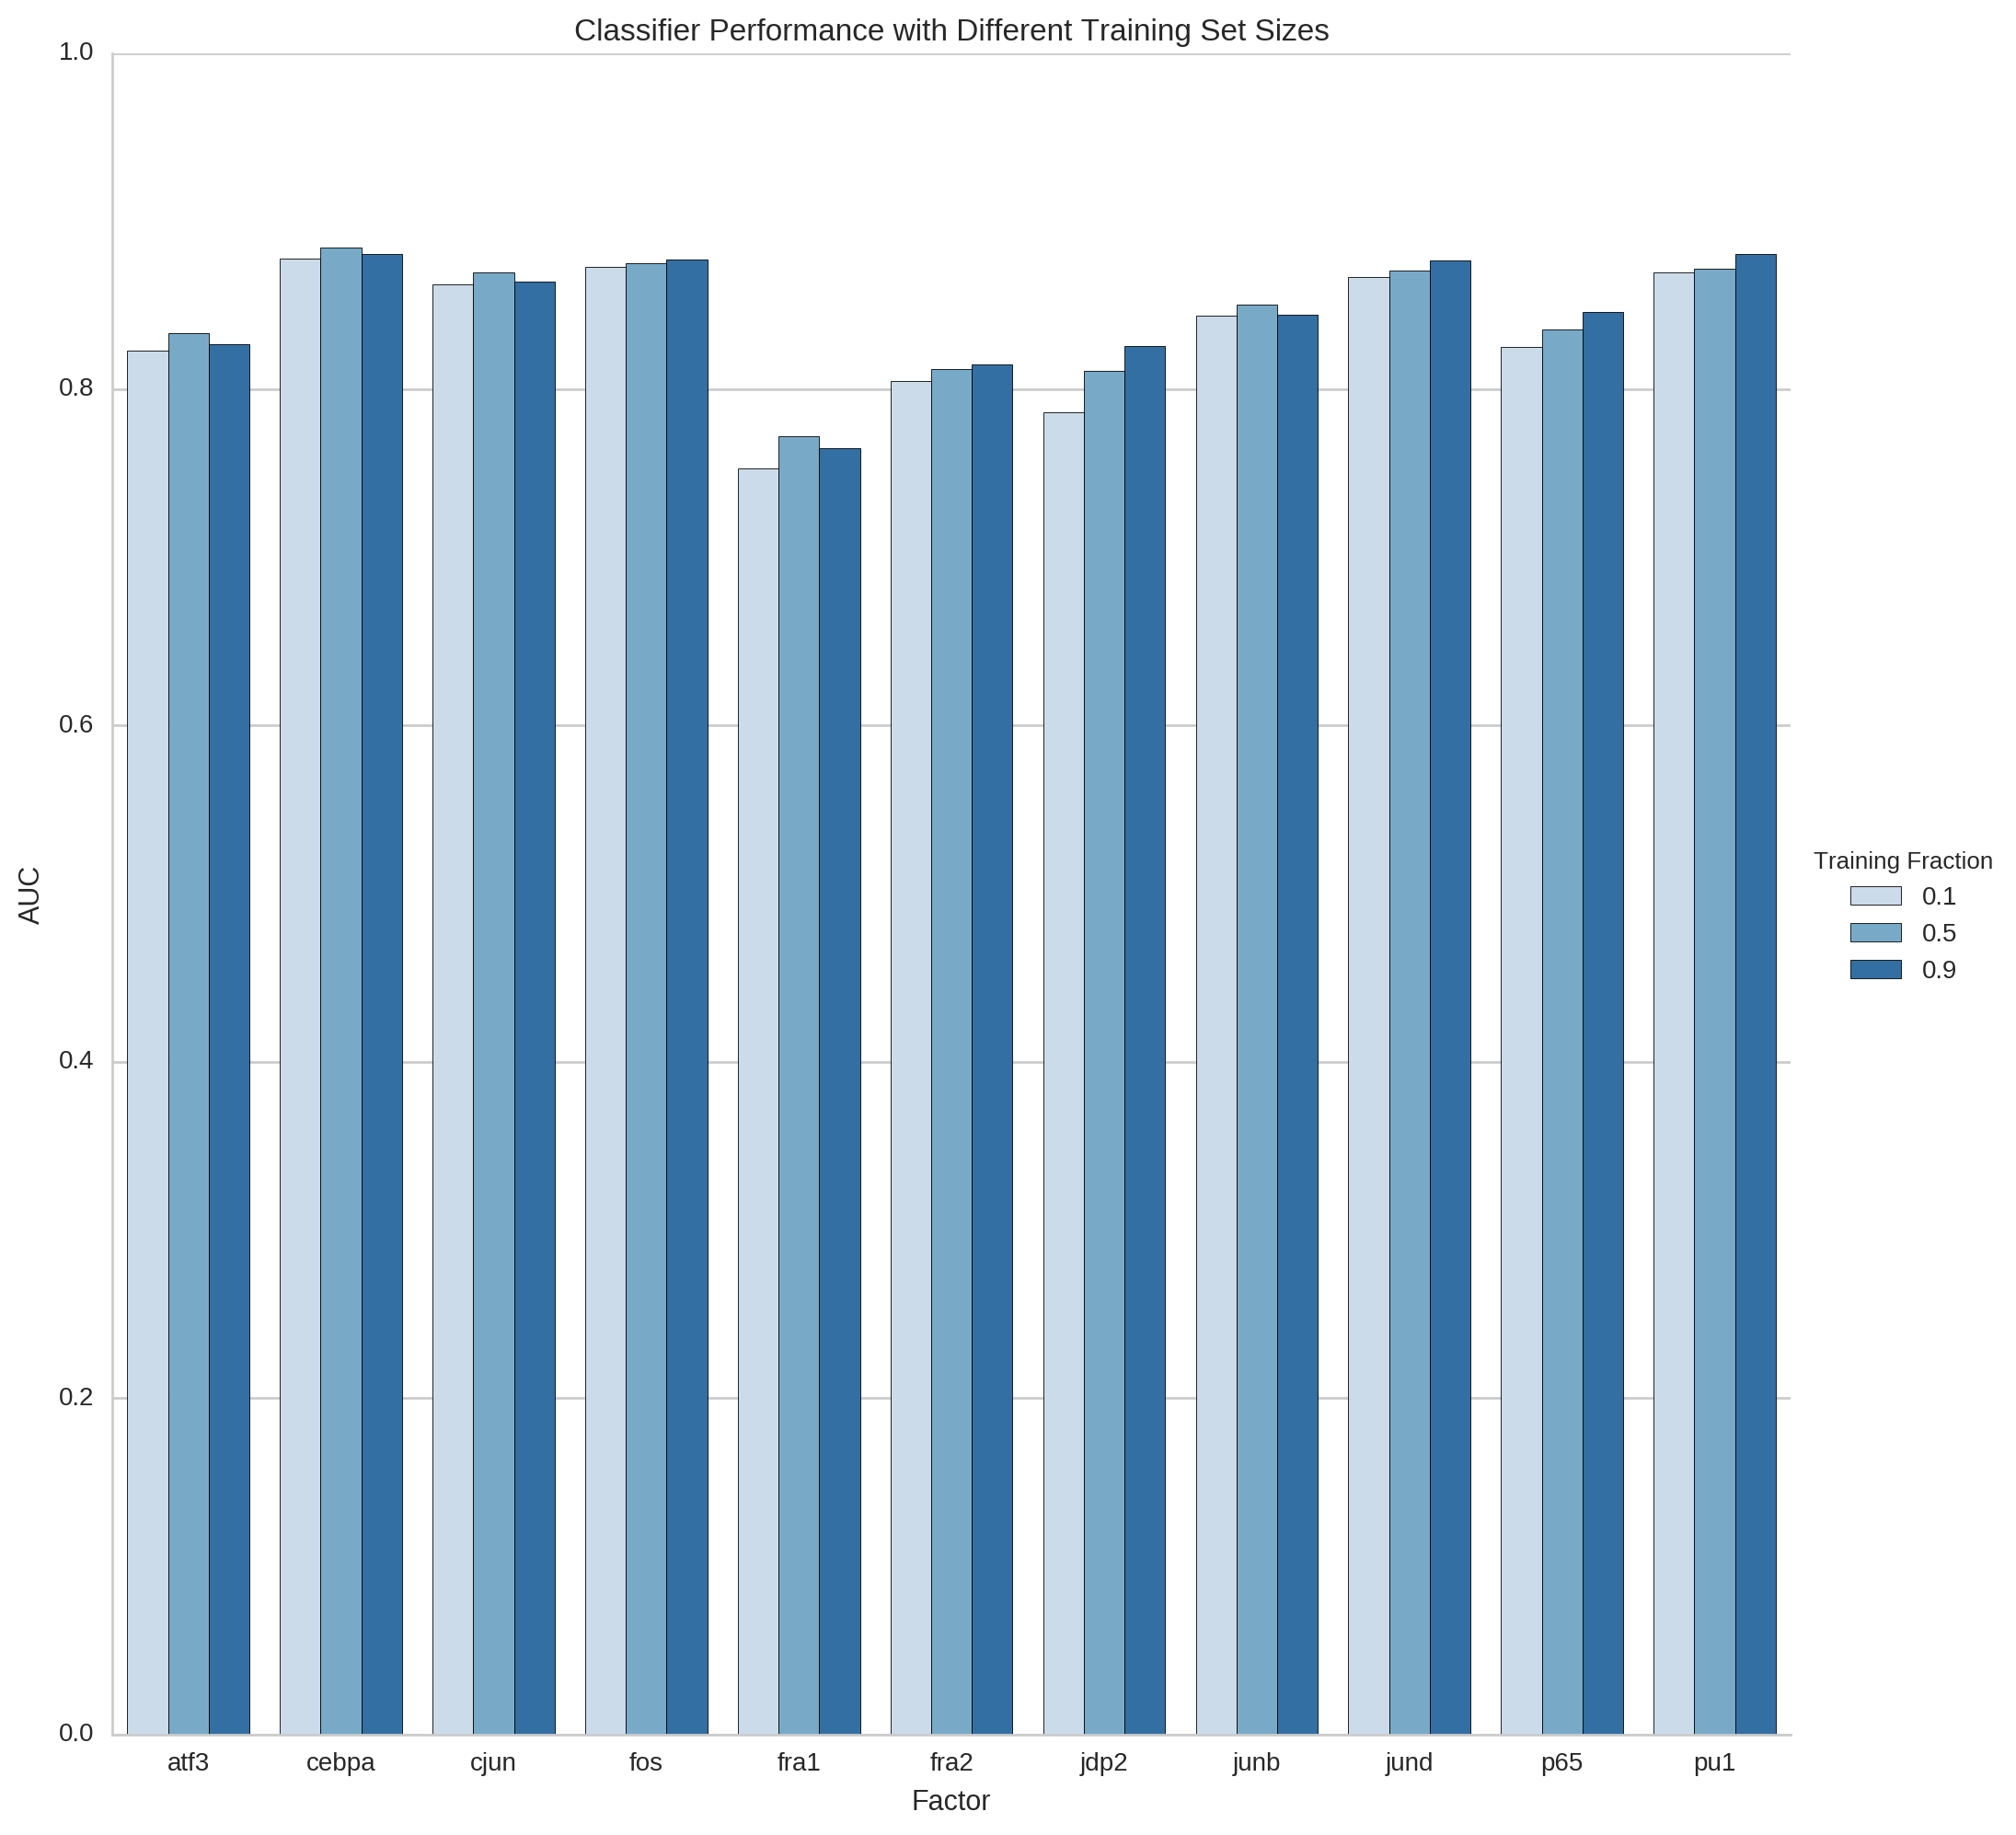

In [ ]:
stacked_frame = pd.DataFrame(auc_frame.stack())
stacked_frame['Factor'] = [x[1] for x in stacked_frame.index.values]
stacked_frame['Training Fraction'] = [np.round(1- x[0],3) for x in stacked_frame.index.values]
stacked_frame.columns = ['AUC', 'Factor', 'Training Fraction']
stacked_frame.index = range(stacked_frame.shape[0])
with sns.axes_style('whitegrid'):
    sns.factorplot(data=stacked_frame[stacked_frame['Training Fraction'].isin([0.1,0.5, 0.9])], 
                   x='Factor', y='AUC', hue='Training Fraction', size=10, kind='bar', palette='Blues')
    plt.ylim(0,1)
    plt.title('Classifier Performance with Different Training Set Sizes')

### Regressing on Individual Motifs

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
### for all peaks in vehicle and KLA
factor_coeff_dict = {}
factor_auc_dict = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values
motifs = sorted(normed_motif_frame.columns.values)
for factor in _factors:
    print(factor)
    factor_coeff_dict[factor] = []
    factor_auc_dict[factor] = []
    current_coeffs = factor_coeff_dict[factor]
    current_aucs = factor_auc_dict[factor]
    for motif in motifs:
        # get features and labels
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][motif]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)
        # split test and training data
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = 0.5, tolerance = 0.01)
        training_features = training_features.reshape(training_features.shape[0],1)
        test_features = test_features.reshape(test_features.shape[0],1)
        training_labels = training_labels.reshape(training_labels.shape[0],1)
        test_labels = test_labels.reshape(test_labels.shape[0],1)
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
        
        #  Run classifier        
        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve coefficient
        coefficient = lr_classifier.coef_[0][0]

        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc = auc(fpr, tpr)

        current_coeffs.append(coefficient)
        current_aucs.append(roc_auc)
        print(motif,coefficient,roc_auc)

coefficients_frame_ind = pd.DataFrame(factor_coeff_dict)
coefficients_frame_ind = coefficients_frame_ind[sorted(_factors)]
coefficients_frame_ind.index = motifs

auc_frame_ind = pd.DataFrame(factor_auc_dict)
auc_frame_ind = auc_frame_ind[sorted(_factors)]
auc_frame_ind.index = motifs

atac
total: 82848 filtered: 66539 true gc: 0.51584 false gc: 0.50585 difference: 0.00999
alx1_alx4_arx 0.845828650122 0.540571545177
total: 82848 filtered: 66626 true gc: 0.51584 false gc: 0.50584 difference: 0.01
ap-1 0.57800742362 0.543789659718
total: 82848 filtered: 66633 true gc: 0.51584 false gc: 0.50584 difference: 0.01
ar_nr3c1_nr3c2 -0.110085759145 0.501033713813
total: 82848 filtered: 66592 true gc: 0.51584 false gc: 0.50584 difference: 0.01
arid3a 0.177552128598 0.510079877258
total: 82848 filtered: 66622 true gc: 0.51584 false gc: 0.50584 difference: 0.01
arid3b 0.435095745483 0.520707477196
total: 82848 filtered: 66595 true gc: 0.51584 false gc: 0.50584 difference: 0.01
arid5a 0.46690797339 0.531117791177
total: 82848 filtered: 66583 true gc: 0.51584 false gc: 0.50585 difference: 0.01
arnt_mycn 0.306164243097 0.519931292275
total: 82848 filtered: 66571 true gc: 0.51584 false gc: 0.50584 difference: 0.01
arntl_mitf 0.873127042795 0.553031283387
total: 82848 filtered: 66578 

total: 82848 filtered: 66312 true gc: 0.4732 false gc: 0.4832 difference: 0.01


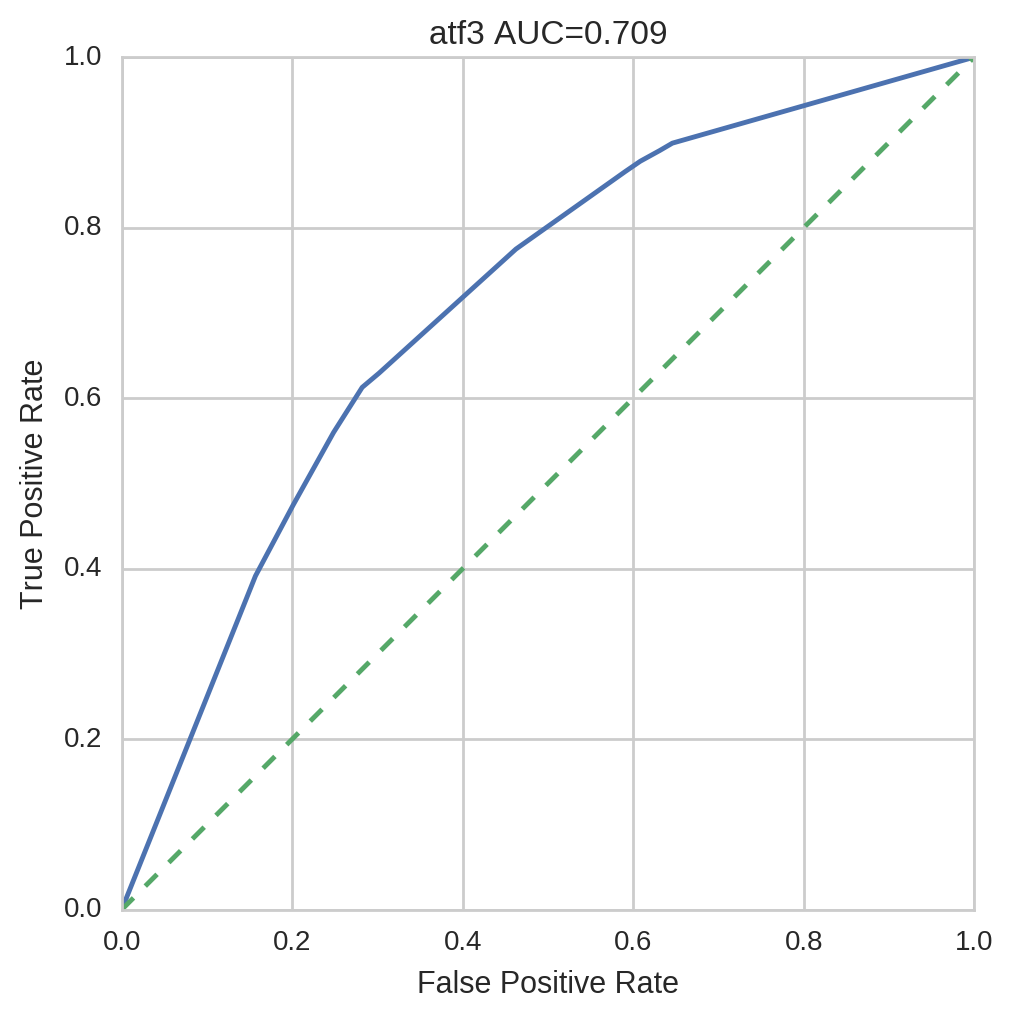

total: 82848 filtered: 63306 true gc: 0.46926 false gc: 0.47926 difference: 0.01


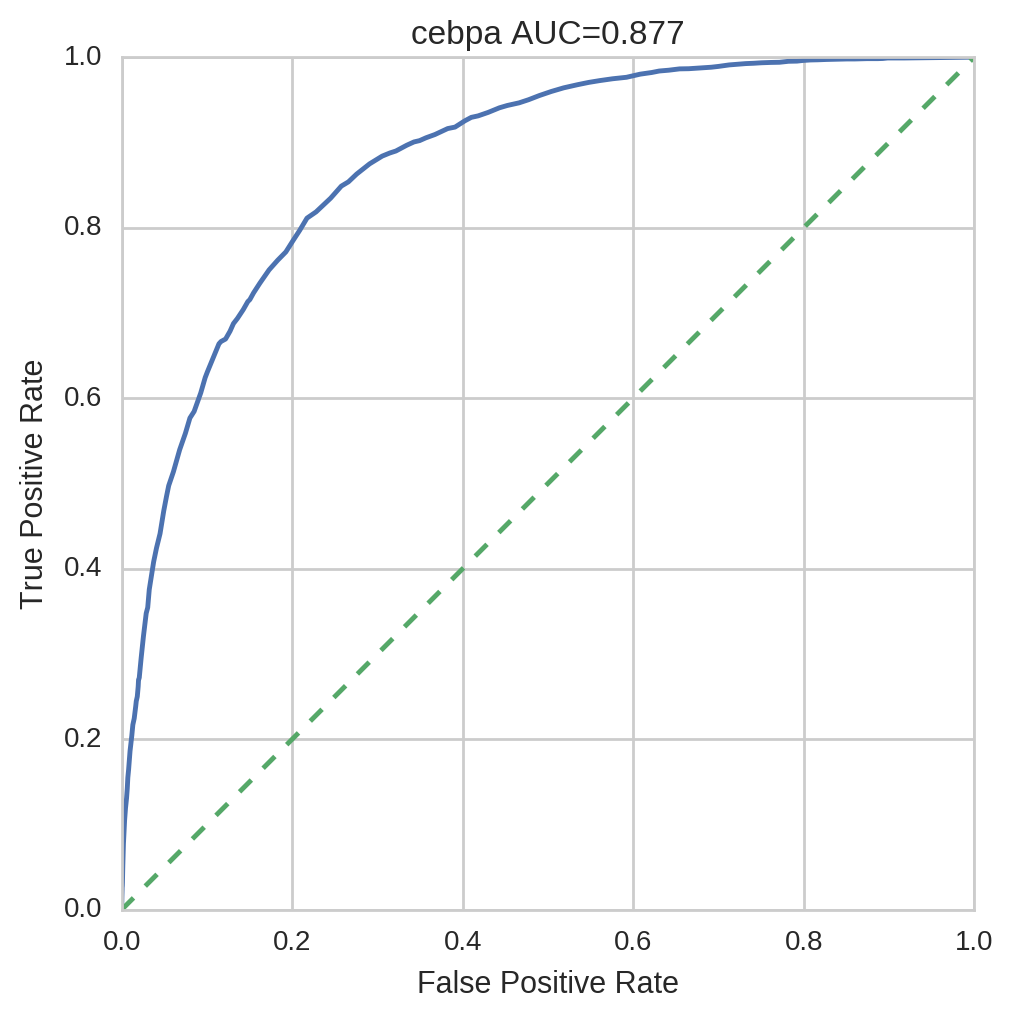

total: 82848 filtered: 81576 true gc: 0.49452 false gc: 0.50452 difference: 0.01


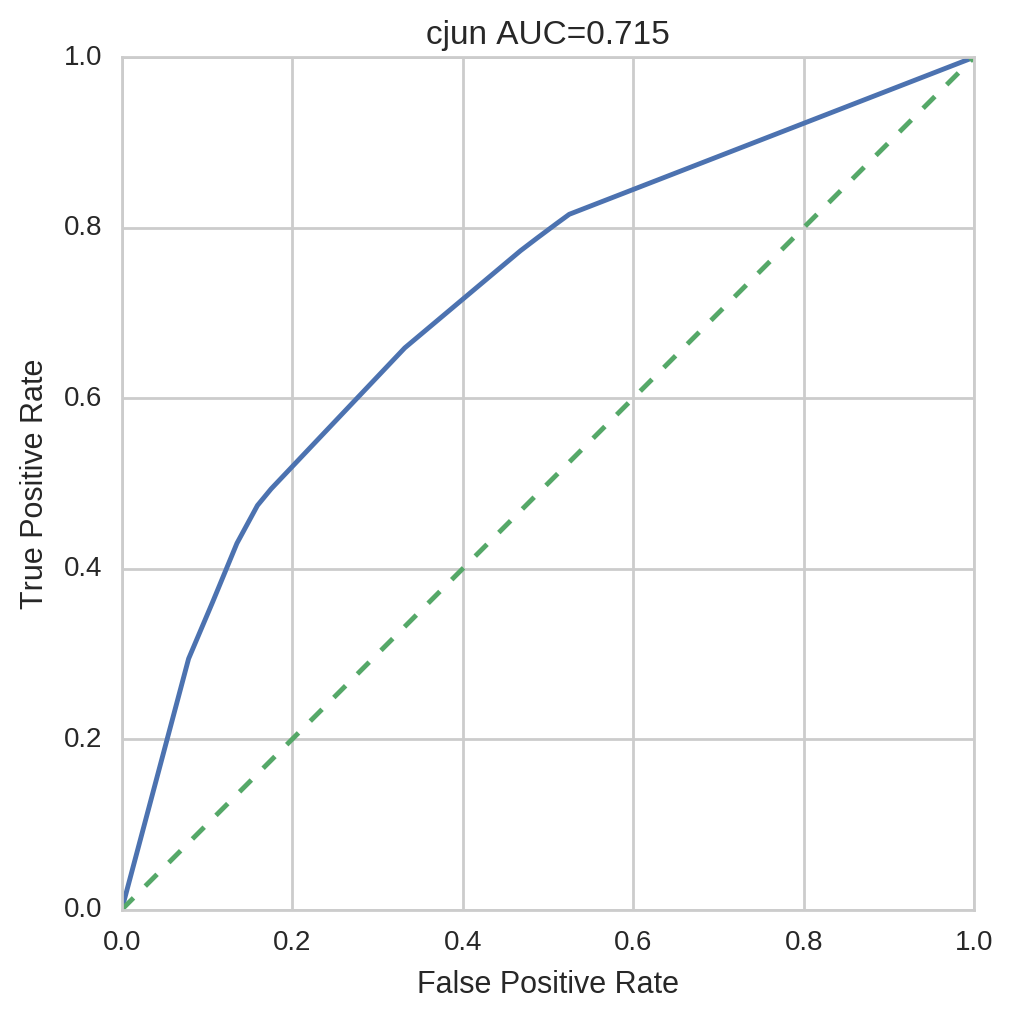

total: 82848 filtered: 79963 true gc: 0.49284 false gc: 0.50282 difference: 0.00999


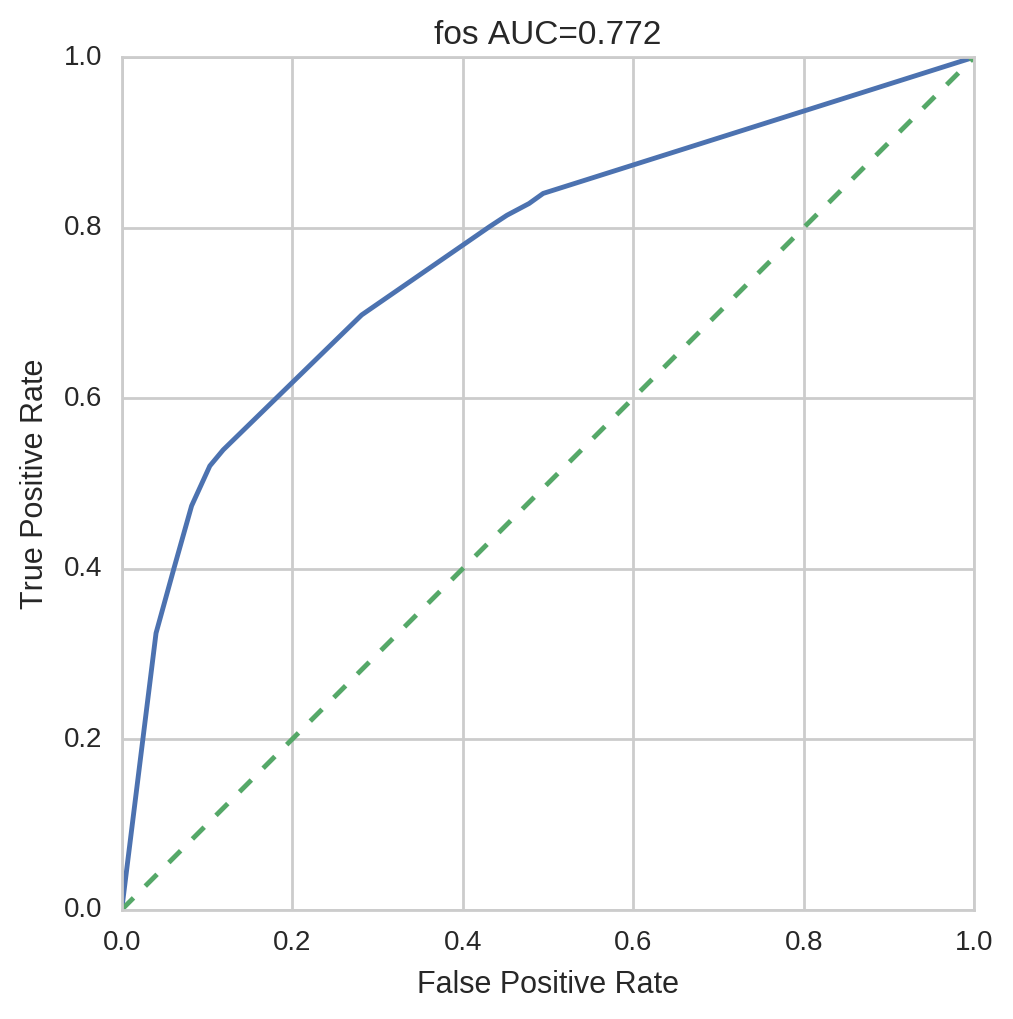

total: 82848 filtered: 59939 true gc: 0.52817 false gc: 0.51817 difference: 0.01


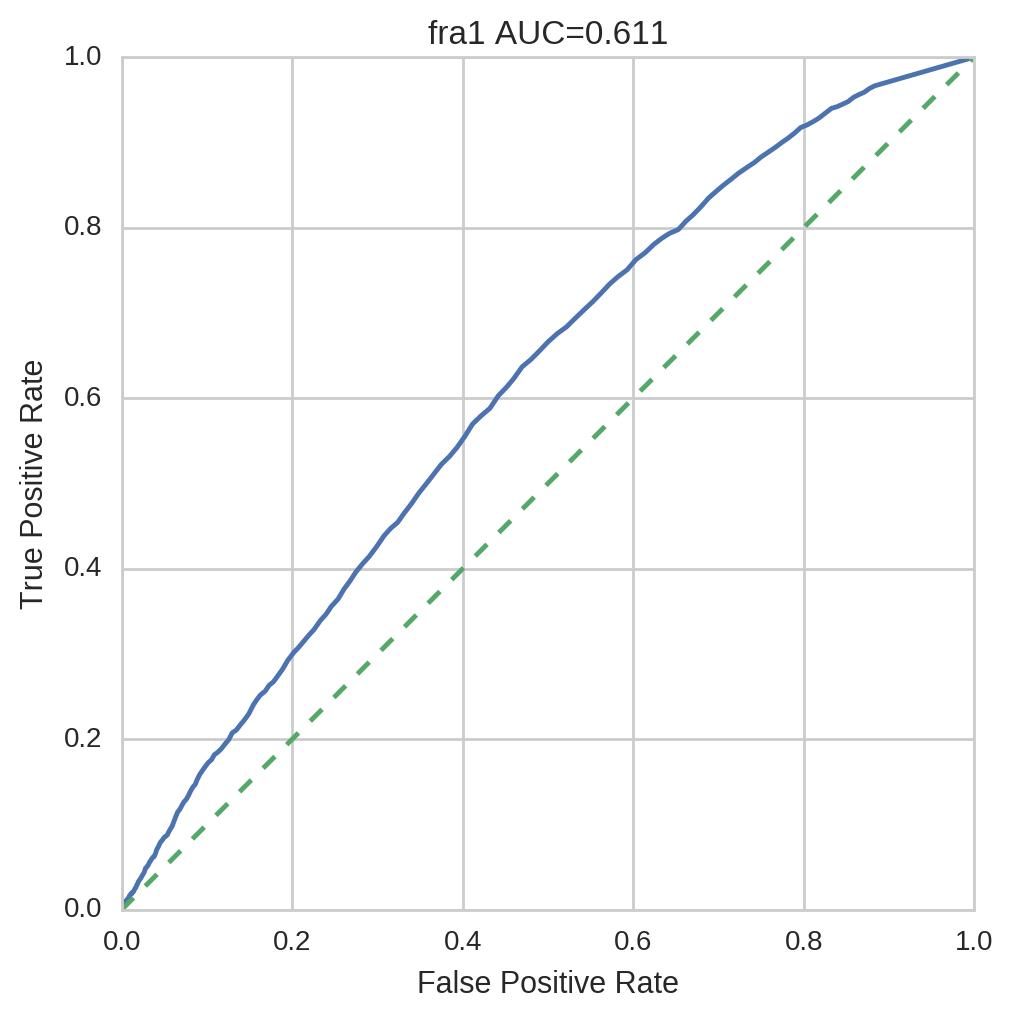

total: 82848 filtered: 82848 true gc: 0.50562 false gc: 0.49773 difference: 0.00789


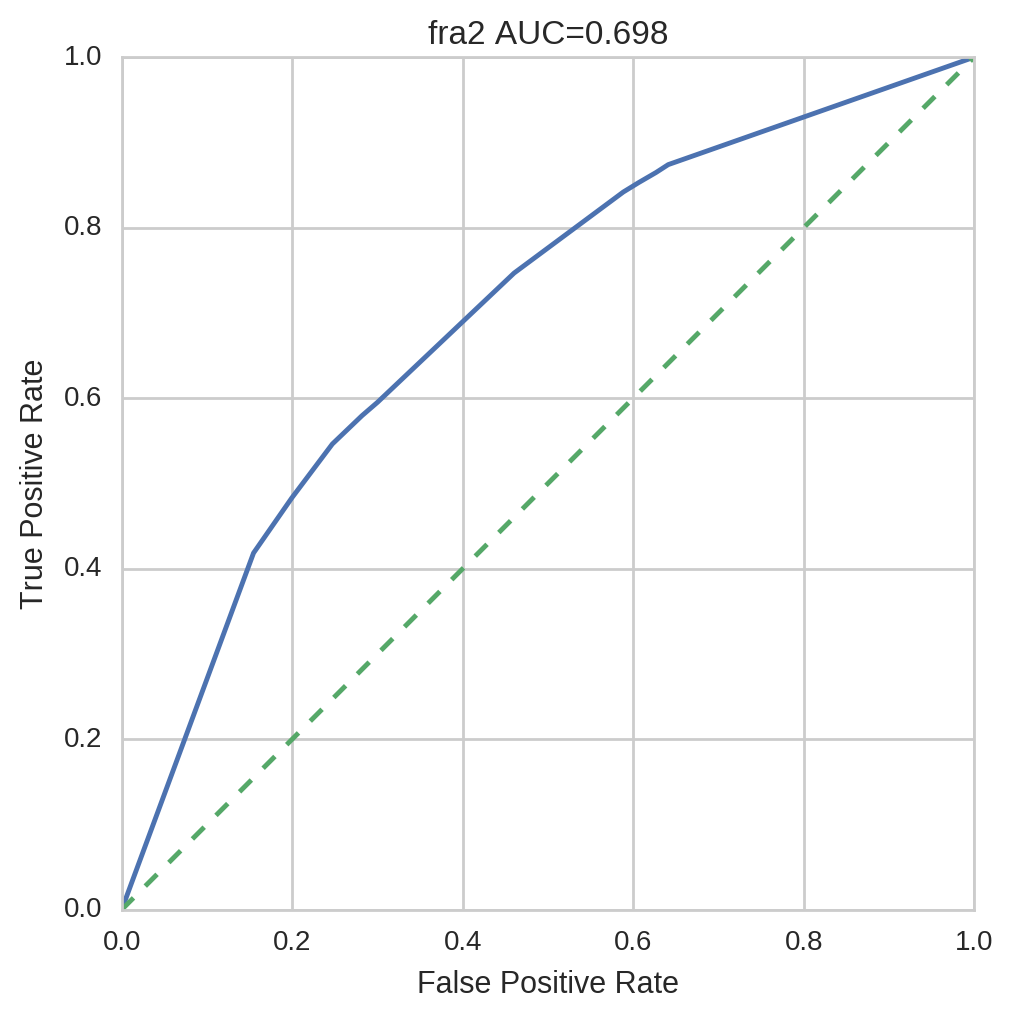

total: 82848 filtered: 82848 true gc: 0.49069 false gc: 0.49967 difference: 0.00898


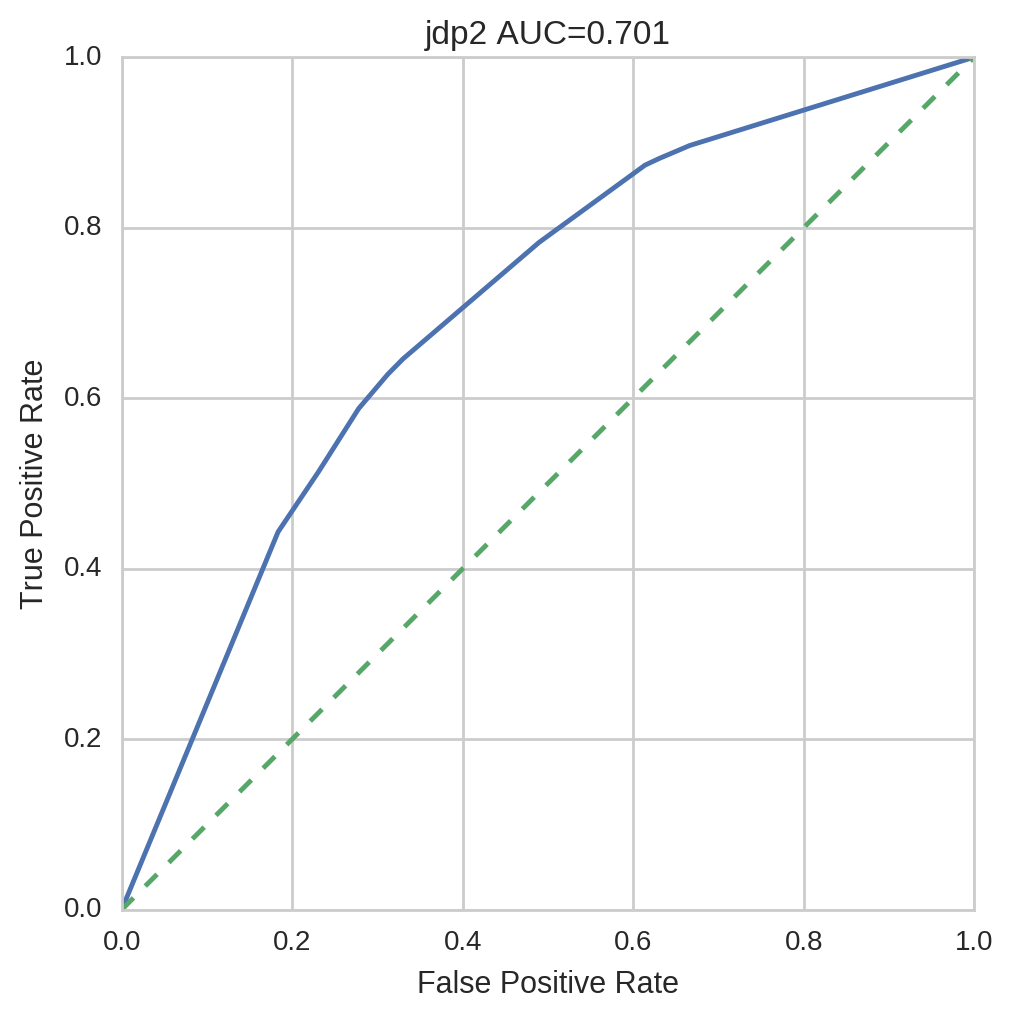

total: 82848 filtered: 75612 true gc: 0.48678 false gc: 0.49678 difference: 0.01


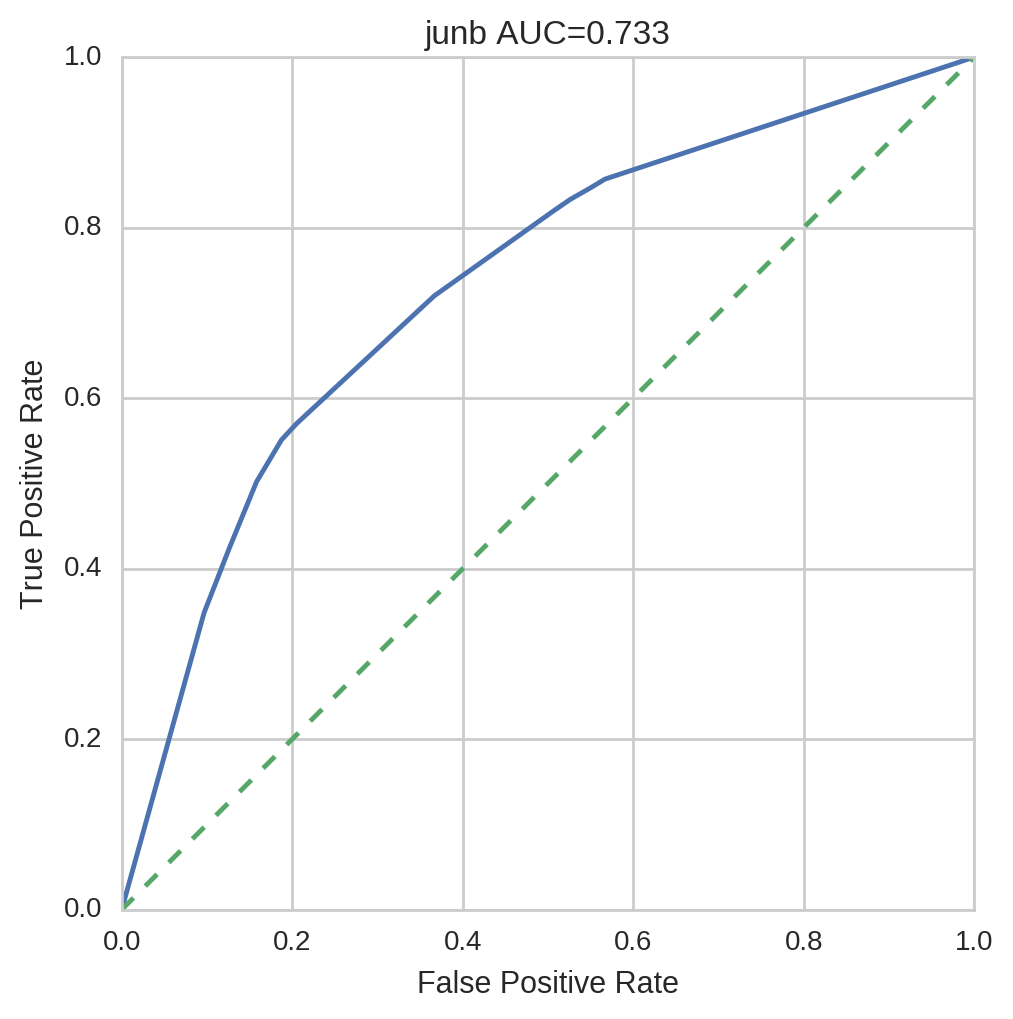

total: 82848 filtered: 82848 true gc: 0.50207 false gc: 0.49357 difference: 0.0085


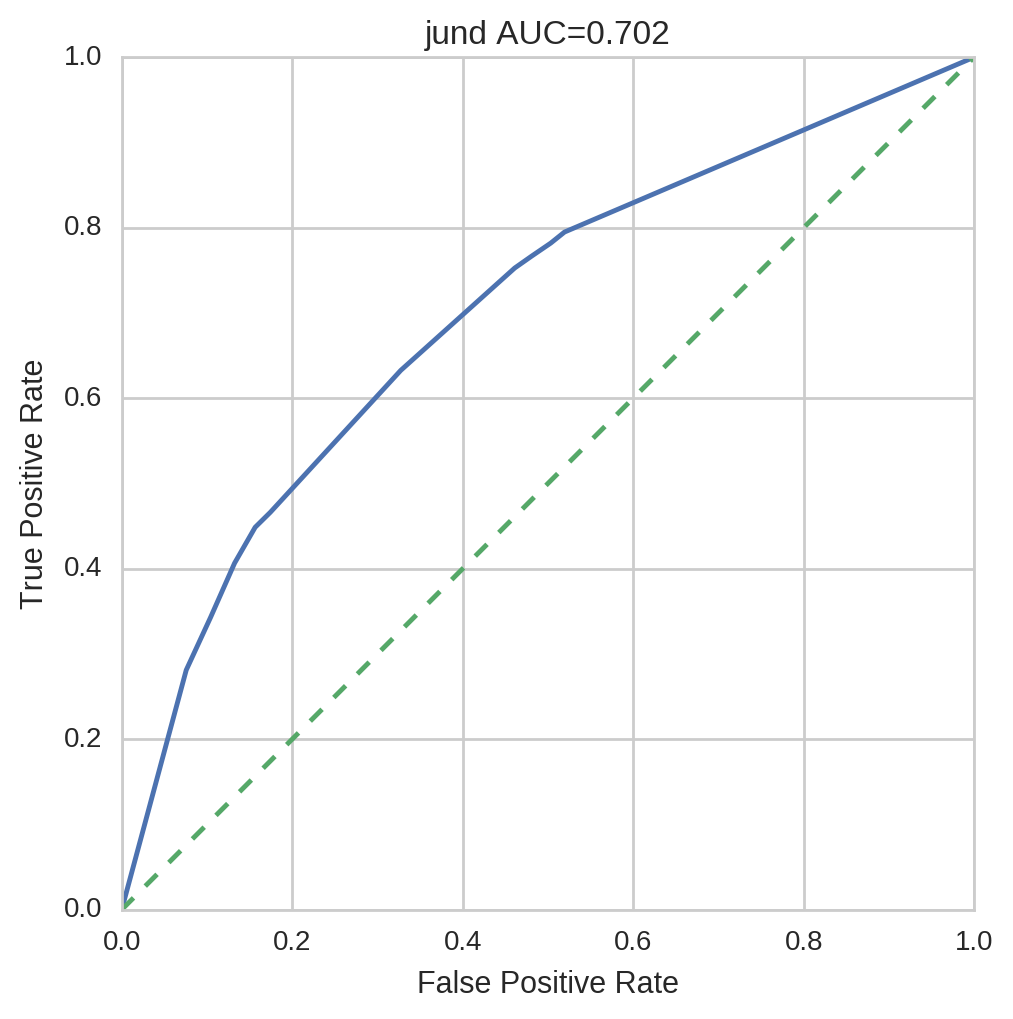

total: 82848 filtered: 77217 true gc: 0.51205 false gc: 0.50205 difference: 0.01


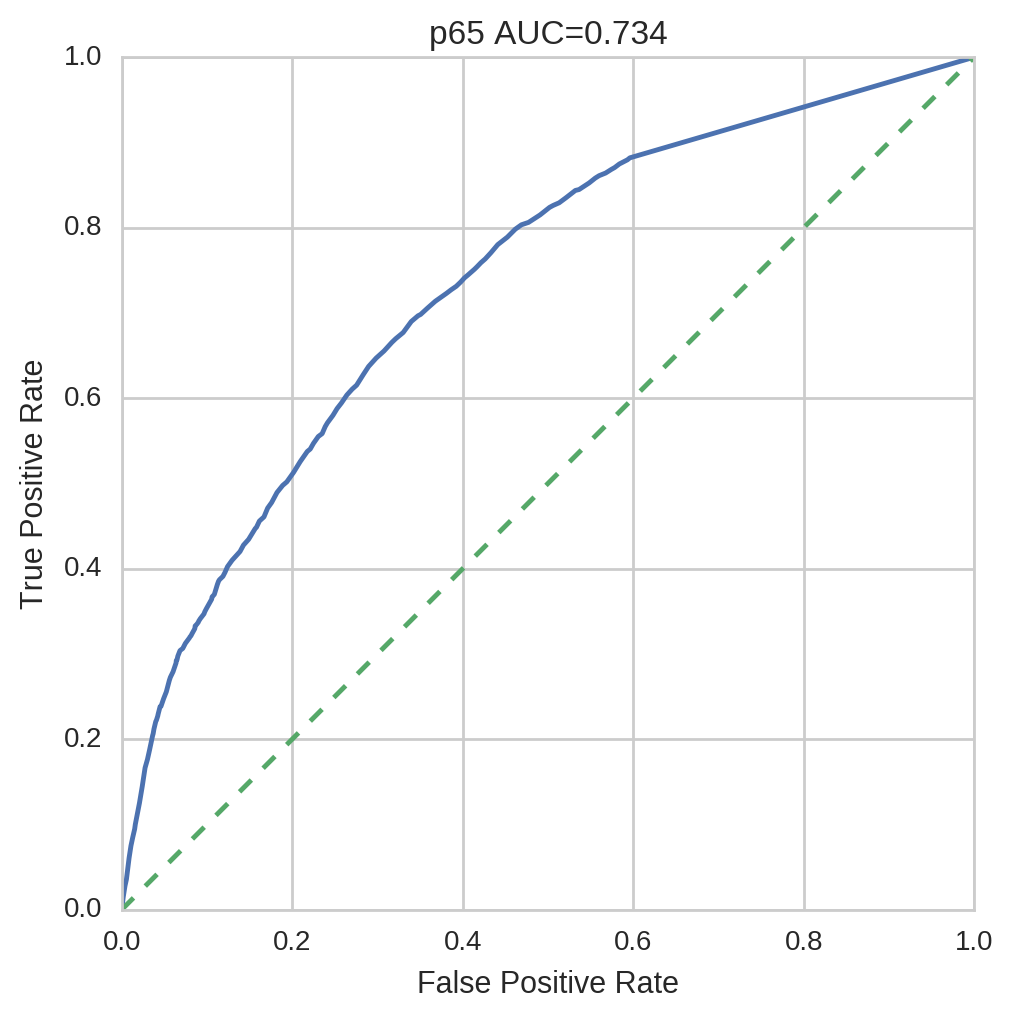

total: 82848 filtered: 79610 true gc: 0.49367 false gc: 0.50367 difference: 0.01


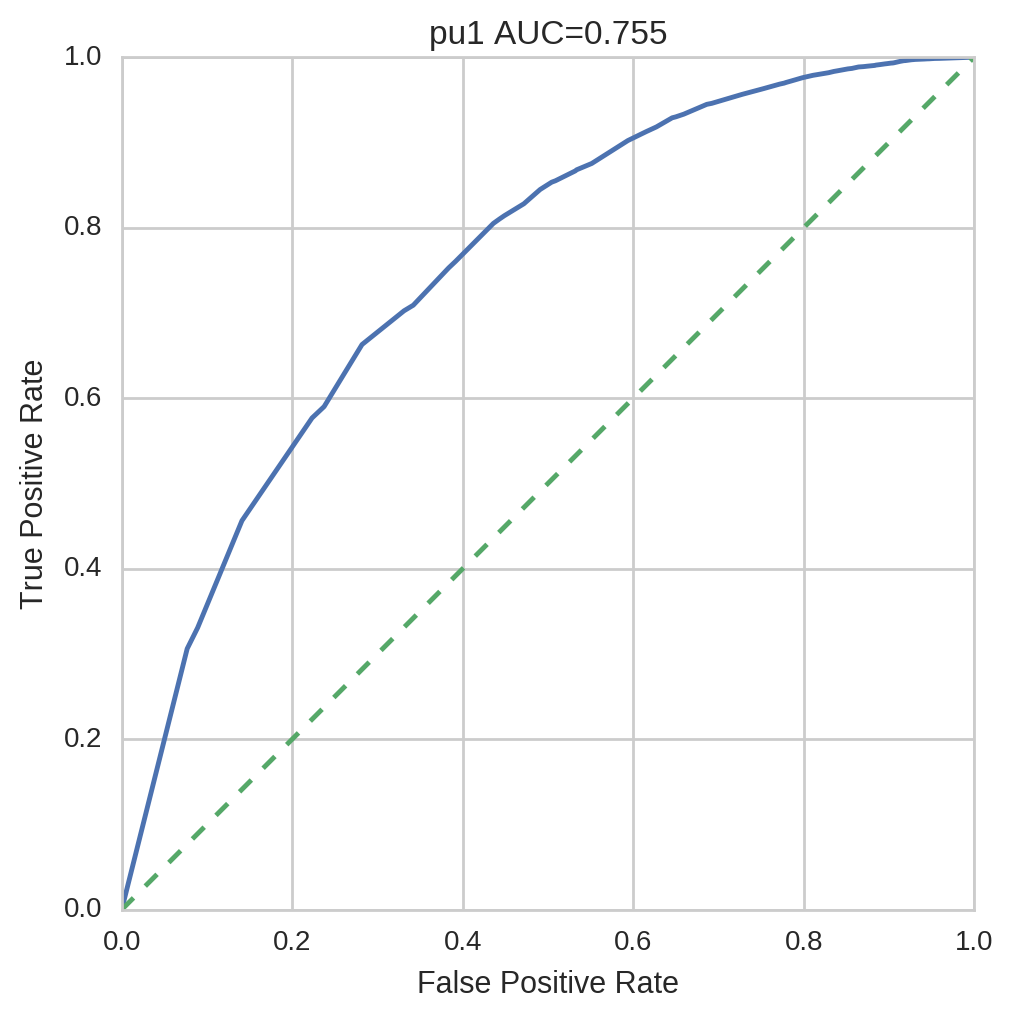

In [9]:
### roc curve for best motif ###
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor, motif in tuple(zip(auc_frame_ind.idxmax().index.values,auc_frame_ind.idxmax())):
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][motif]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    training_features = training_features.reshape(training_features.shape[0],1)
    test_features = test_features.reshape(test_features.shape[0],1)
    training_labels = training_labels.reshape(training_labels.shape[0],1)
    test_labels = test_labels.reshape(test_labels.shape[0],1)
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    with sns.axes_style('whitegrid'):
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1],linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(factor+' AUC='+str(np.round(roc_auc,3)))
        plt.gca().set_aspect('equal') 
        plt.show()

In [110]:
### for all peaks in vehicle and KLA
factor_coeff_dict = {}
factor_auc_dict_all = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values
_factors.remove('atac')
for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_all = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all = coefficients_frame_all[sorted(_factors)]
coefficients_frame_all.index = motif_score_frame.columns.values[3:]


total: 82848 filtered: 66295 true gc: 0.4732 false gc: 0.4832 difference: 0.01
atf3 0.833909897422
total: 82848 filtered: 63291 true gc: 0.46926 false gc: 0.47926 difference: 0.01
cebpa 0.883572411375
total: 82848 filtered: 81602 true gc: 0.49452 false gc: 0.50452 difference: 0.01
cjun 0.86811664055
total: 82848 filtered: 79980 true gc: 0.49284 false gc: 0.50283 difference: 0.01
fos 0.87560536671
total: 82848 filtered: 60013 true gc: 0.52817 false gc: 0.51818 difference: 0.01
fra1 0.766564746483
total: 82848 filtered: 82848 true gc: 0.50562 false gc: 0.49773 difference: 0.00789
fra2 0.813091690098
total: 82848 filtered: 82848 true gc: 0.49069 false gc: 0.49967 difference: 0.00898
jdp2 0.809467841482
total: 82848 filtered: 75655 true gc: 0.48678 false gc: 0.49678 difference: 0.01
junb 0.850427509
total: 82848 filtered: 82848 true gc: 0.50207 false gc: 0.49357 difference: 0.0085
jund 0.870334276263
total: 82848 filtered: 77192 true gc: 0.51205 false gc: 0.50205 difference: 0.01
p65 0.837

In [111]:
### for all peaks in vehicle and KLA using significant motifs
threshold = 2
# mean = np.mean(coefficients_frame_all.values)
# std = np.std(coefficients_frame_all.values)
factor_motifs_dict = {}
significant_motifs = set()
for factor in coefficients_frame_all.columns.values:
    weights = coefficients_frame_all[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    for m in motif_hits:
        significant_motifs.add(m)
    print(factor, mean-threshold*std, mean+threshold*std, len(negative_hits), len(positive_hits))

    factor_motifs_dict[factor] = motif_hits
significant_motifs = sorted(significant_motifs)
    
factor_coeff_dict = {}
factor_auc_dict_all_best = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][significant_motifs]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all_best[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_all_best = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_best = coefficients_frame_all_best[sorted(_factors)]
coefficients_frame_all_best.index = significant_motifs



atf3 -0.491005680105 0.716843627865 2 6
cebpa -1.23972805923 1.36996763249 0 2
cjun -0.473334610408 0.843028443443 3 7
fos -0.565967715814 0.874326004585 2 6
fra1 -0.41981475649 0.59637027211 4 6
fra2 -0.418795597679 0.610735205188 1 5
jdp2 -0.459919229812 0.643124039105 4 7
junb -0.50128541116 0.772700970251 1 7
jund -0.455776164544 0.857408145035 2 7
p65 -0.614205219369 0.789792446588 2 5
pu1 -0.799203096811 1.09324663761 1 5
total: 82848 filtered: 66186 true gc: 0.4732 false gc: 0.4832 difference: 0.01
atf3 0.814126186871
total: 82848 filtered: 63306 true gc: 0.46926 false gc: 0.47926 difference: 0.01
cebpa 0.883805455584
total: 82848 filtered: 81684 true gc: 0.49452 false gc: 0.50452 difference: 0.01
cjun 0.84870071096
total: 82848 filtered: 79945 true gc: 0.49284 false gc: 0.50283 difference: 0.01
fos 0.859830198171
total: 82848 filtered: 59888 true gc: 0.52817 false gc: 0.51817 difference: 0.01
fra1 0.737753010955
total: 82848 filtered: 82848 true gc: 0.50562 false gc: 0.49773 di

In [112]:
auc_frame_ind.idxmax()

atac     tcfl5
atf3      ap-1
cebpa     cebp
cjun      ap-1
fos       ap-1
fra1     nr2f1
fra2      ap-1
jdp2      ap-1
junb      ap-1
jund      ap-1
p65        rel
pu1       spib
dtype: object

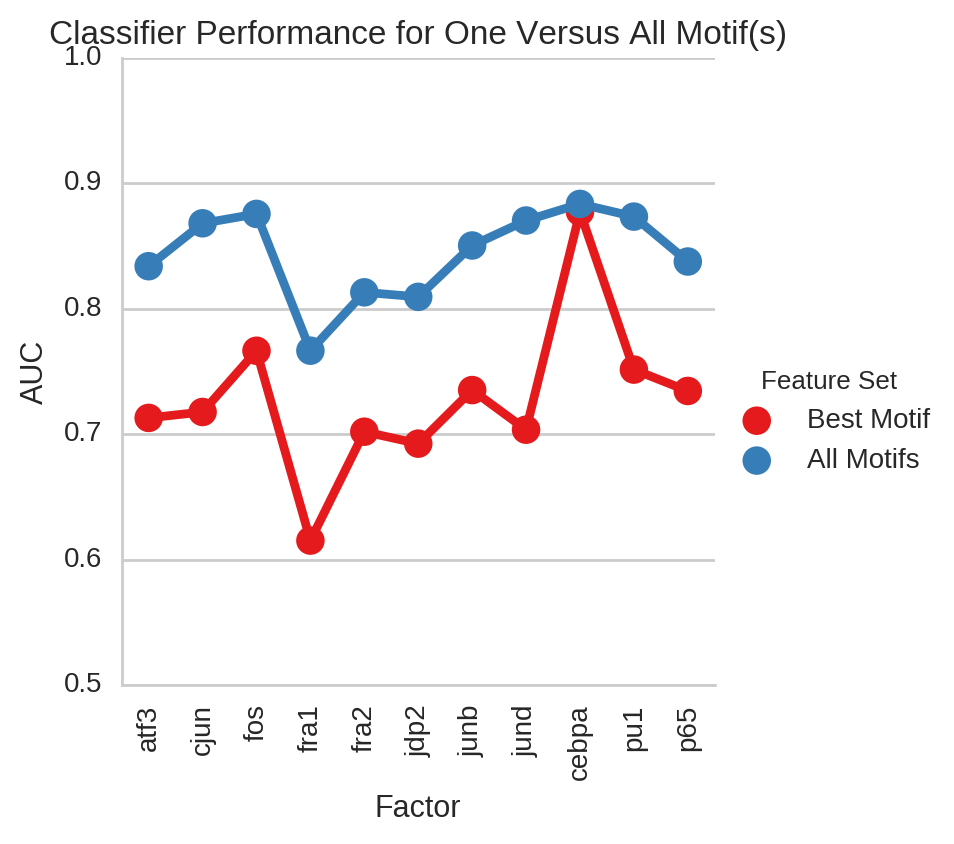

In [123]:
ind_max_aucs = auc_frame_ind.max()
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_all.keys()):
    factors = factors + 2 * [factor]
    features = features + ['Best Motif', 'All Motifs']
    aucs.append(ind_max_aucs[factor])
    aucs.append(factor_auc_dict_all[factor])
with sns.axes_style('whitegrid'):
    plottingFrame = sns.factorplot(data = pd.DataFrame({'Factor':factors,
                                                         'AUC':aucs,
                                                         'Feature Set':features}),
                                    x='Factor',
                                    y='AUC',
                                    hue='Feature Set',
                                    palette='Set1',
                                    size=4,
                                    order = ['atf3', 'cjun', 'fos', 'fra1', 'fra2', 'jdp2', 'junb','jund','cebpa','pu1','p65']
                                  )
    plt.xticks(rotation=90)
    plt.ylim(0.5,1)
    plt.title('Classifier Performance for One Versus All Motif(s)')

(-2, 2)

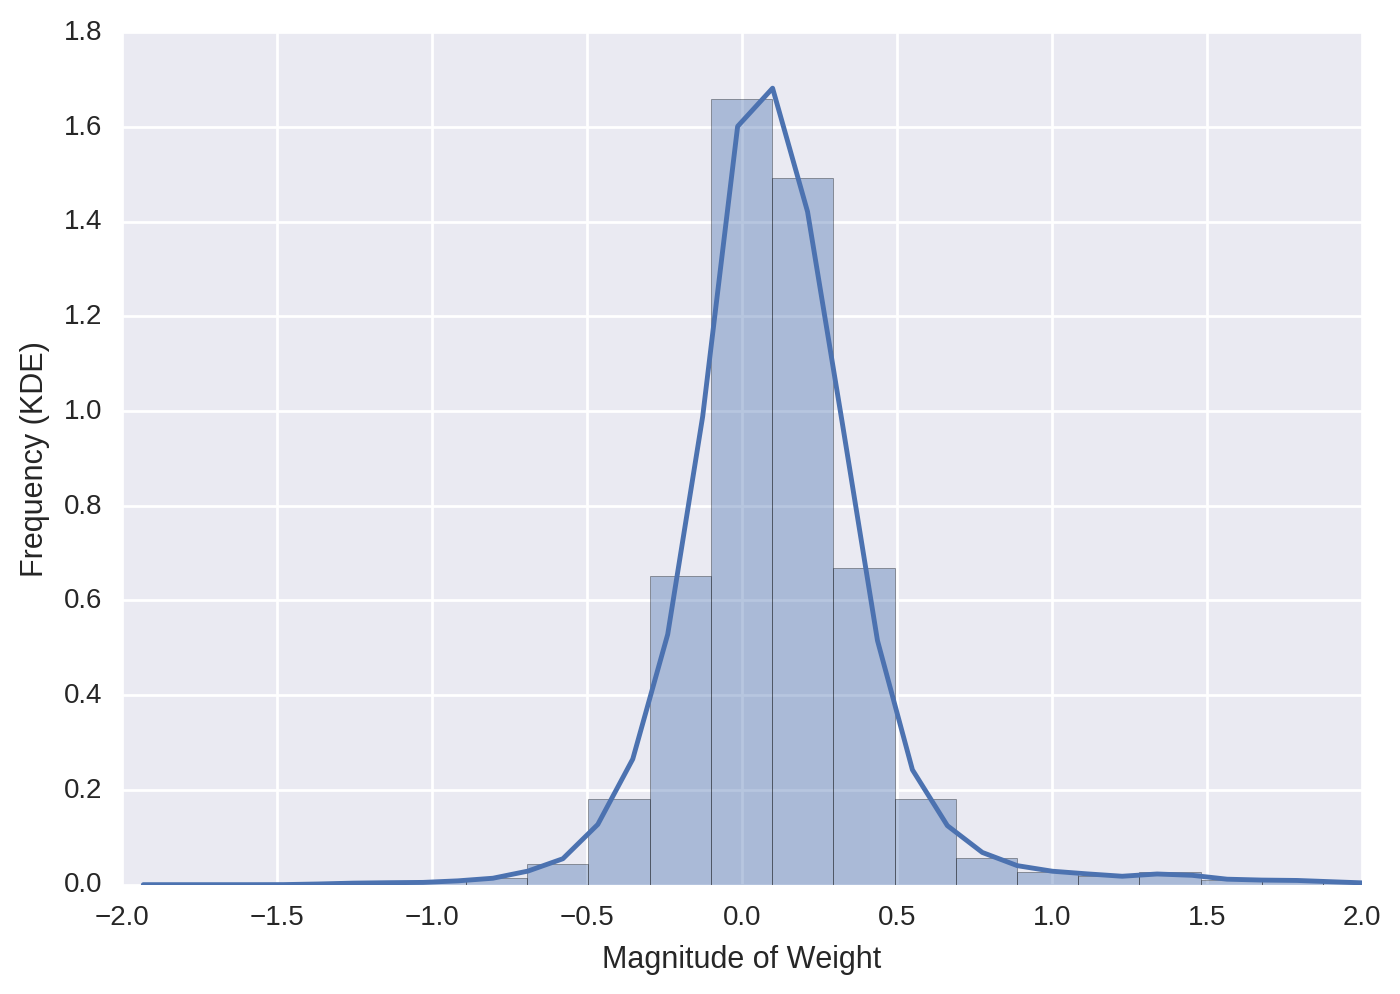

In [128]:
sns.distplot(coefficients_frame_all.values.flatten())
plt.xlabel('Magnitude of Weight')
plt.ylabel('Frequency (KDE)')
plt.xlim(-2,2)

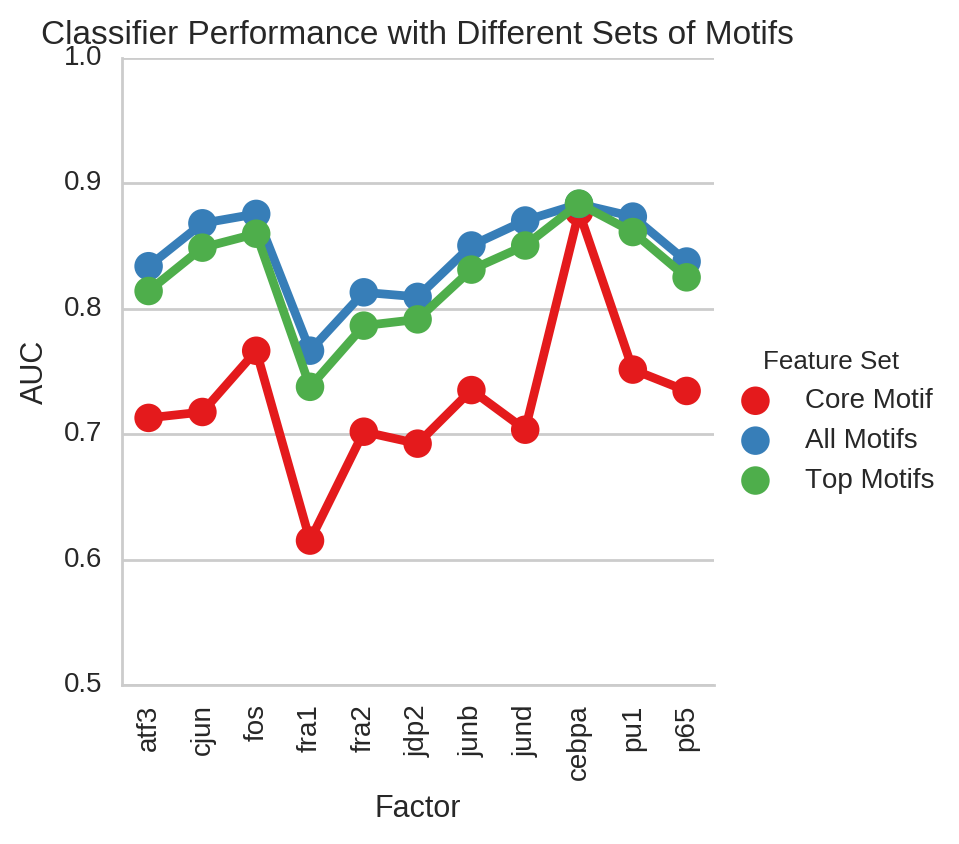

In [125]:
ind_max_aucs = auc_frame_ind.max()
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_all.keys()):
    factors = factors + 3 * [factor]
    features = features + ['Core Motif', 'All Motifs', 'Top Motifs']
    aucs.append(ind_max_aucs[factor])
    aucs.append(factor_auc_dict_all[factor])
    aucs.append(factor_auc_dict_all_best[factor])
with sns.axes_style('whitegrid'):
    plottingFrame = sns.factorplot(data = pd.DataFrame({'Factor':factors,
                                                         'AUC':aucs,
                                                         'Feature Set':features}),
                                x='Factor',
                                y='AUC',
                                hue='Feature Set',
                                palette='Set1',
                                size=4,
                                order = ['atf3', 'cjun', 'fos', 'fra1', 'fra2', 'jdp2', 'junb','jund','cebpa','pu1','p65'])
    plt.xticks(rotation=90)
    plt.ylim(0.5,1)
    plt.title('Classifier Performance with Different Sets of Motifs')

In [115]:
### for all vehicle peaks
factor_coeff_dict = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_veh')
    
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_lr = lr_classifier.predict(test_features)
    
    coefficients = lr_classifier.coef_
    intercept = lr_classifier.intercept_
    
    factor_coeff_dict[factor] = coefficients.flatten()
coefficients_frame_veh = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh = coefficients_frame_veh[sorted(_factors)]
coefficients_frame_veh.index = motif_score_frame.columns.values[3:]



total: 82848 filtered: 65807 true gc: 0.47195 false gc: 0.48195 difference: 0.01
total: 82848 filtered: 64736 true gc: 0.47079 false gc: 0.48079 difference: 0.01
total: 82848 filtered: 82848 true gc: 0.49457 false gc: 0.50132 difference: 0.00675
total: 82848 filtered: 46805 true gc: 0.54461 false gc: 0.53461 difference: 0.01
total: 82848 filtered: 51529 true gc: 0.53831 false gc: 0.52831 difference: 0.01
total: 82848 filtered: 66315 true gc: 0.52163 false gc: 0.51163 difference: 0.01
total: 82848 filtered: 81767 true gc: 0.50975 false gc: 0.49975 difference: 0.01
total: 82848 filtered: 82848 true gc: 0.49352 false gc: 0.4994 difference: 0.00587
total: 82848 filtered: 75631 true gc: 0.51008 false gc: 0.50008 difference: 0.01
total: 82848 filtered: 32202 true gc: 0.5717 false gc: 0.5617 difference: 0.01
total: 82848 filtered: 78999 true gc: 0.49131 false gc: 0.5013 difference: 0.01


In [116]:
### for all KLA peaks
factor_coeff_dict = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_lr = lr_classifier.predict(test_features)
    
    coefficients = lr_classifier.coef_
    intercept = lr_classifier.intercept_
    
    factor_coeff_dict[factor] = coefficients.flatten()
coefficients_frame_kla = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla = coefficients_frame_kla[sorted(_factors)]
coefficients_frame_kla.index = motif_score_frame.columns.values[3:]




total: 82848 filtered: 66719 true gc: 0.47357 false gc: 0.48357 difference: 0.01
total: 82848 filtered: 62475 true gc: 0.46796 false gc: 0.47796 difference: 0.01
total: 82848 filtered: 82471 true gc: 0.4947 false gc: 0.5047 difference: 0.01
total: 82848 filtered: 79227 true gc: 0.49209 false gc: 0.50209 difference: 0.01
total: 82848 filtered: 82848 true gc: 0.50722 false gc: 0.49894 difference: 0.00827
total: 82848 filtered: 82848 true gc: 0.49411 false gc: 0.49995 difference: 0.00584
total: 82848 filtered: 72551 true gc: 0.47922 false gc: 0.48922 difference: 0.01
total: 82848 filtered: 75458 true gc: 0.48655 false gc: 0.49655 difference: 0.01
total: 82848 filtered: 82848 true gc: 0.50038 false gc: 0.49745 difference: 0.00293
total: 82848 filtered: 78983 true gc: 0.51069 false gc: 0.5007 difference: 0.01
total: 82848 filtered: 81416 true gc: 0.49471 false gc: 0.50471 difference: 0.01


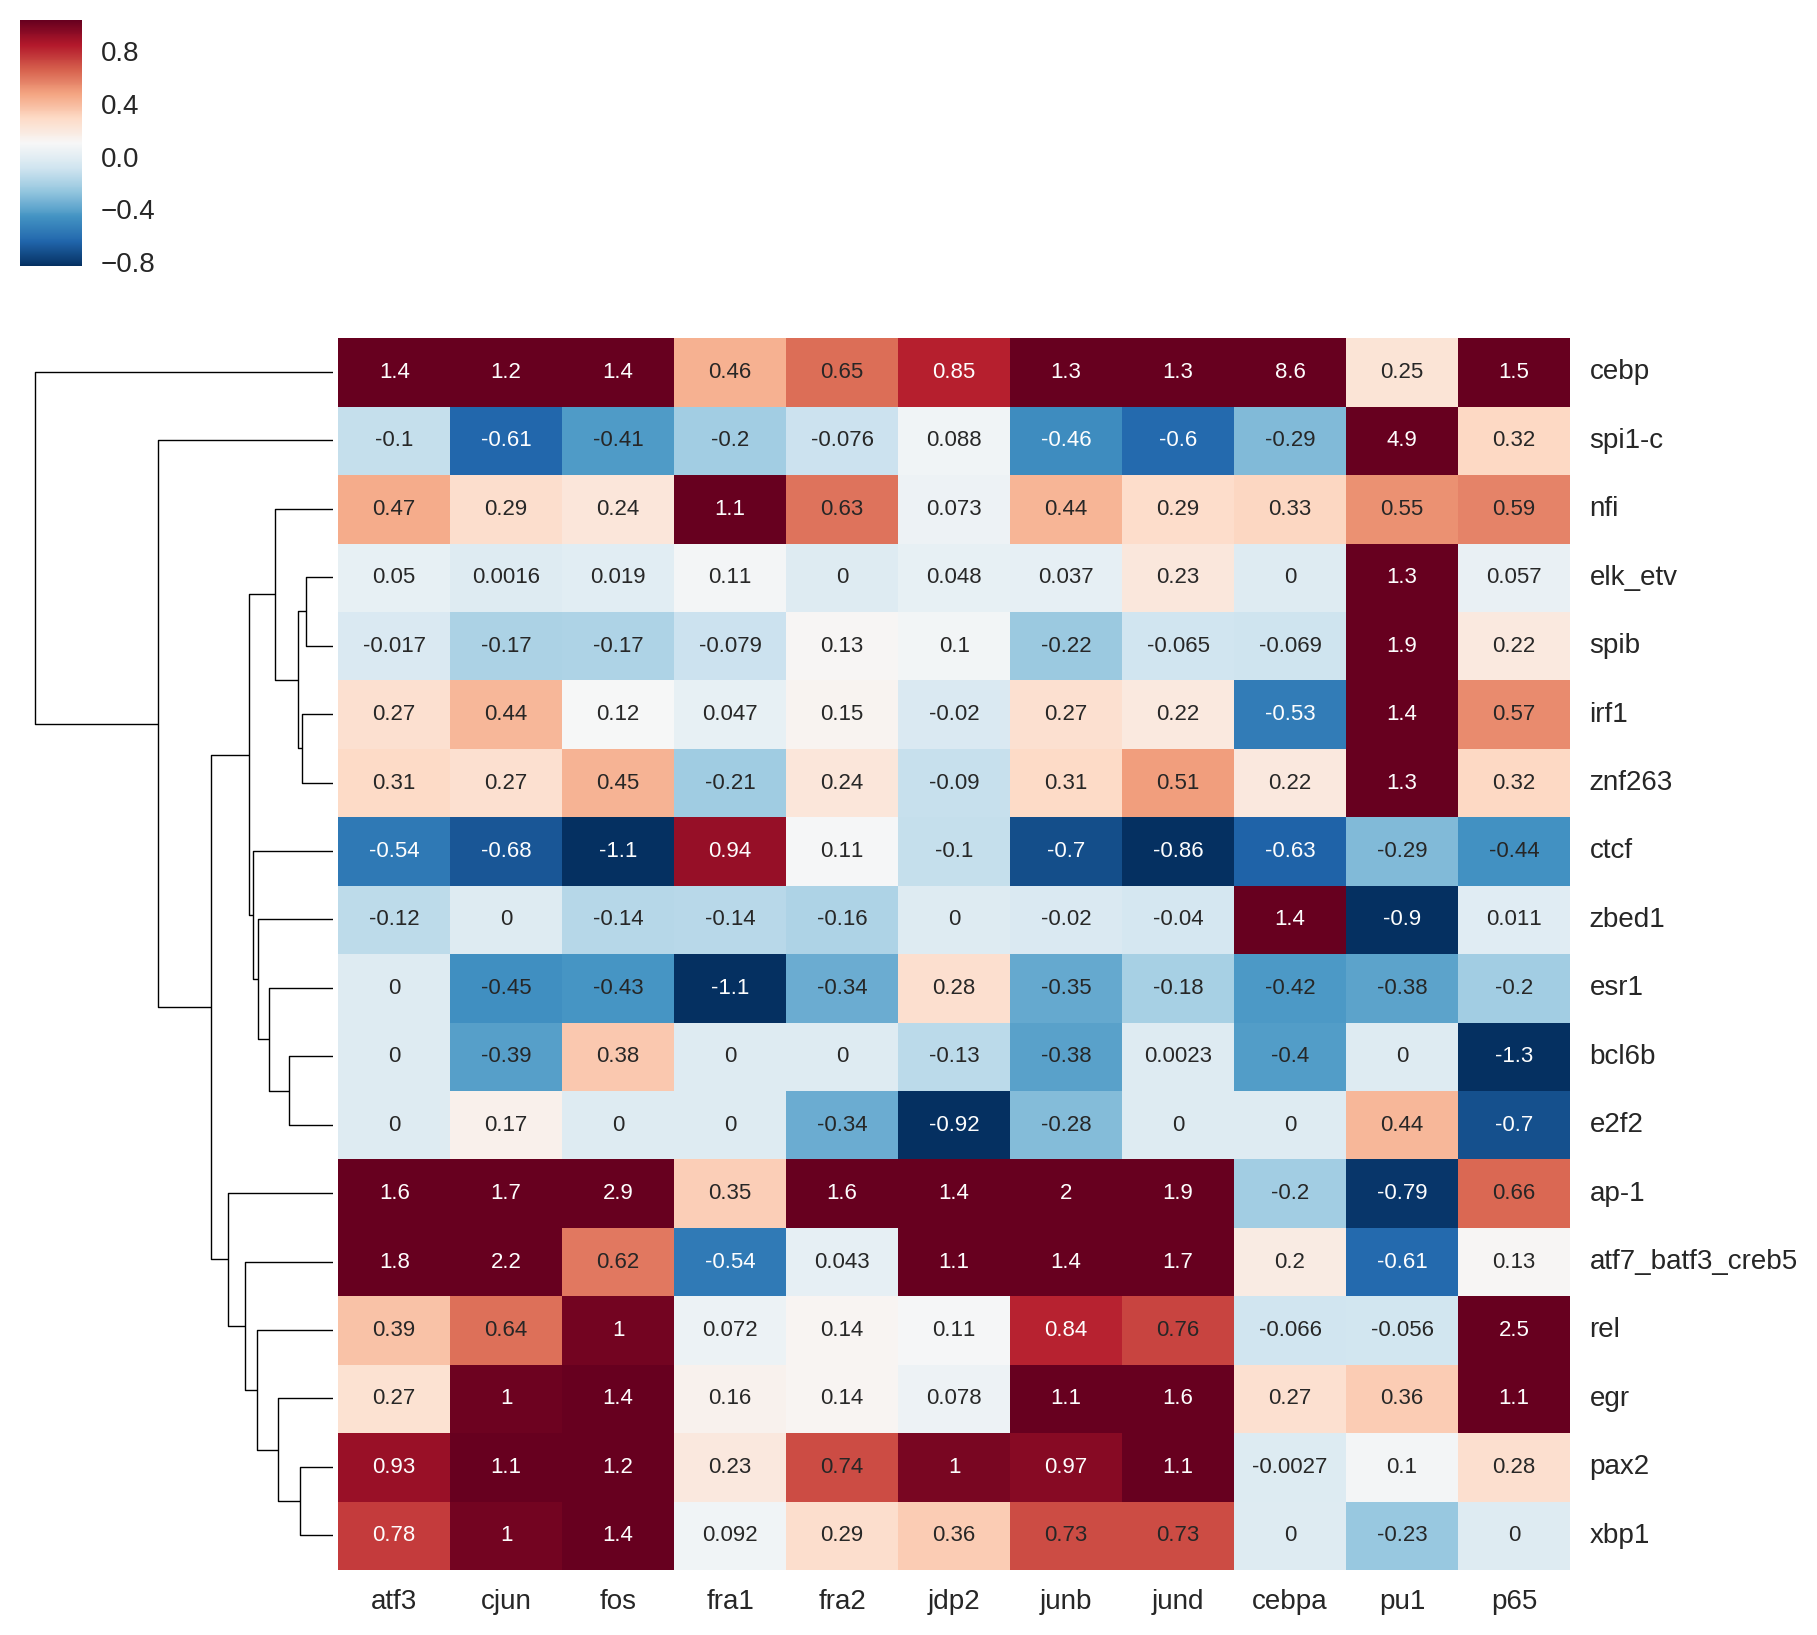

In [145]:
### plot coefficents for both vehicle and kla
threshold = 2.5
coeff_std = np.std(coefficients_frame_all.values.flatten())
coeff_mean = np.mean(coefficients_frame_all.values.flatten())

cg = sns.clustermap(coefficients_frame_all[(coefficients_frame_all.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_all.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ][['atf3', 'cjun', 'fos', 'fra1', 'fra2', 'jdp2', 'junb','jund','cebpa','pu1','p65']],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8},
                    col_cluster = False
                   )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);



[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

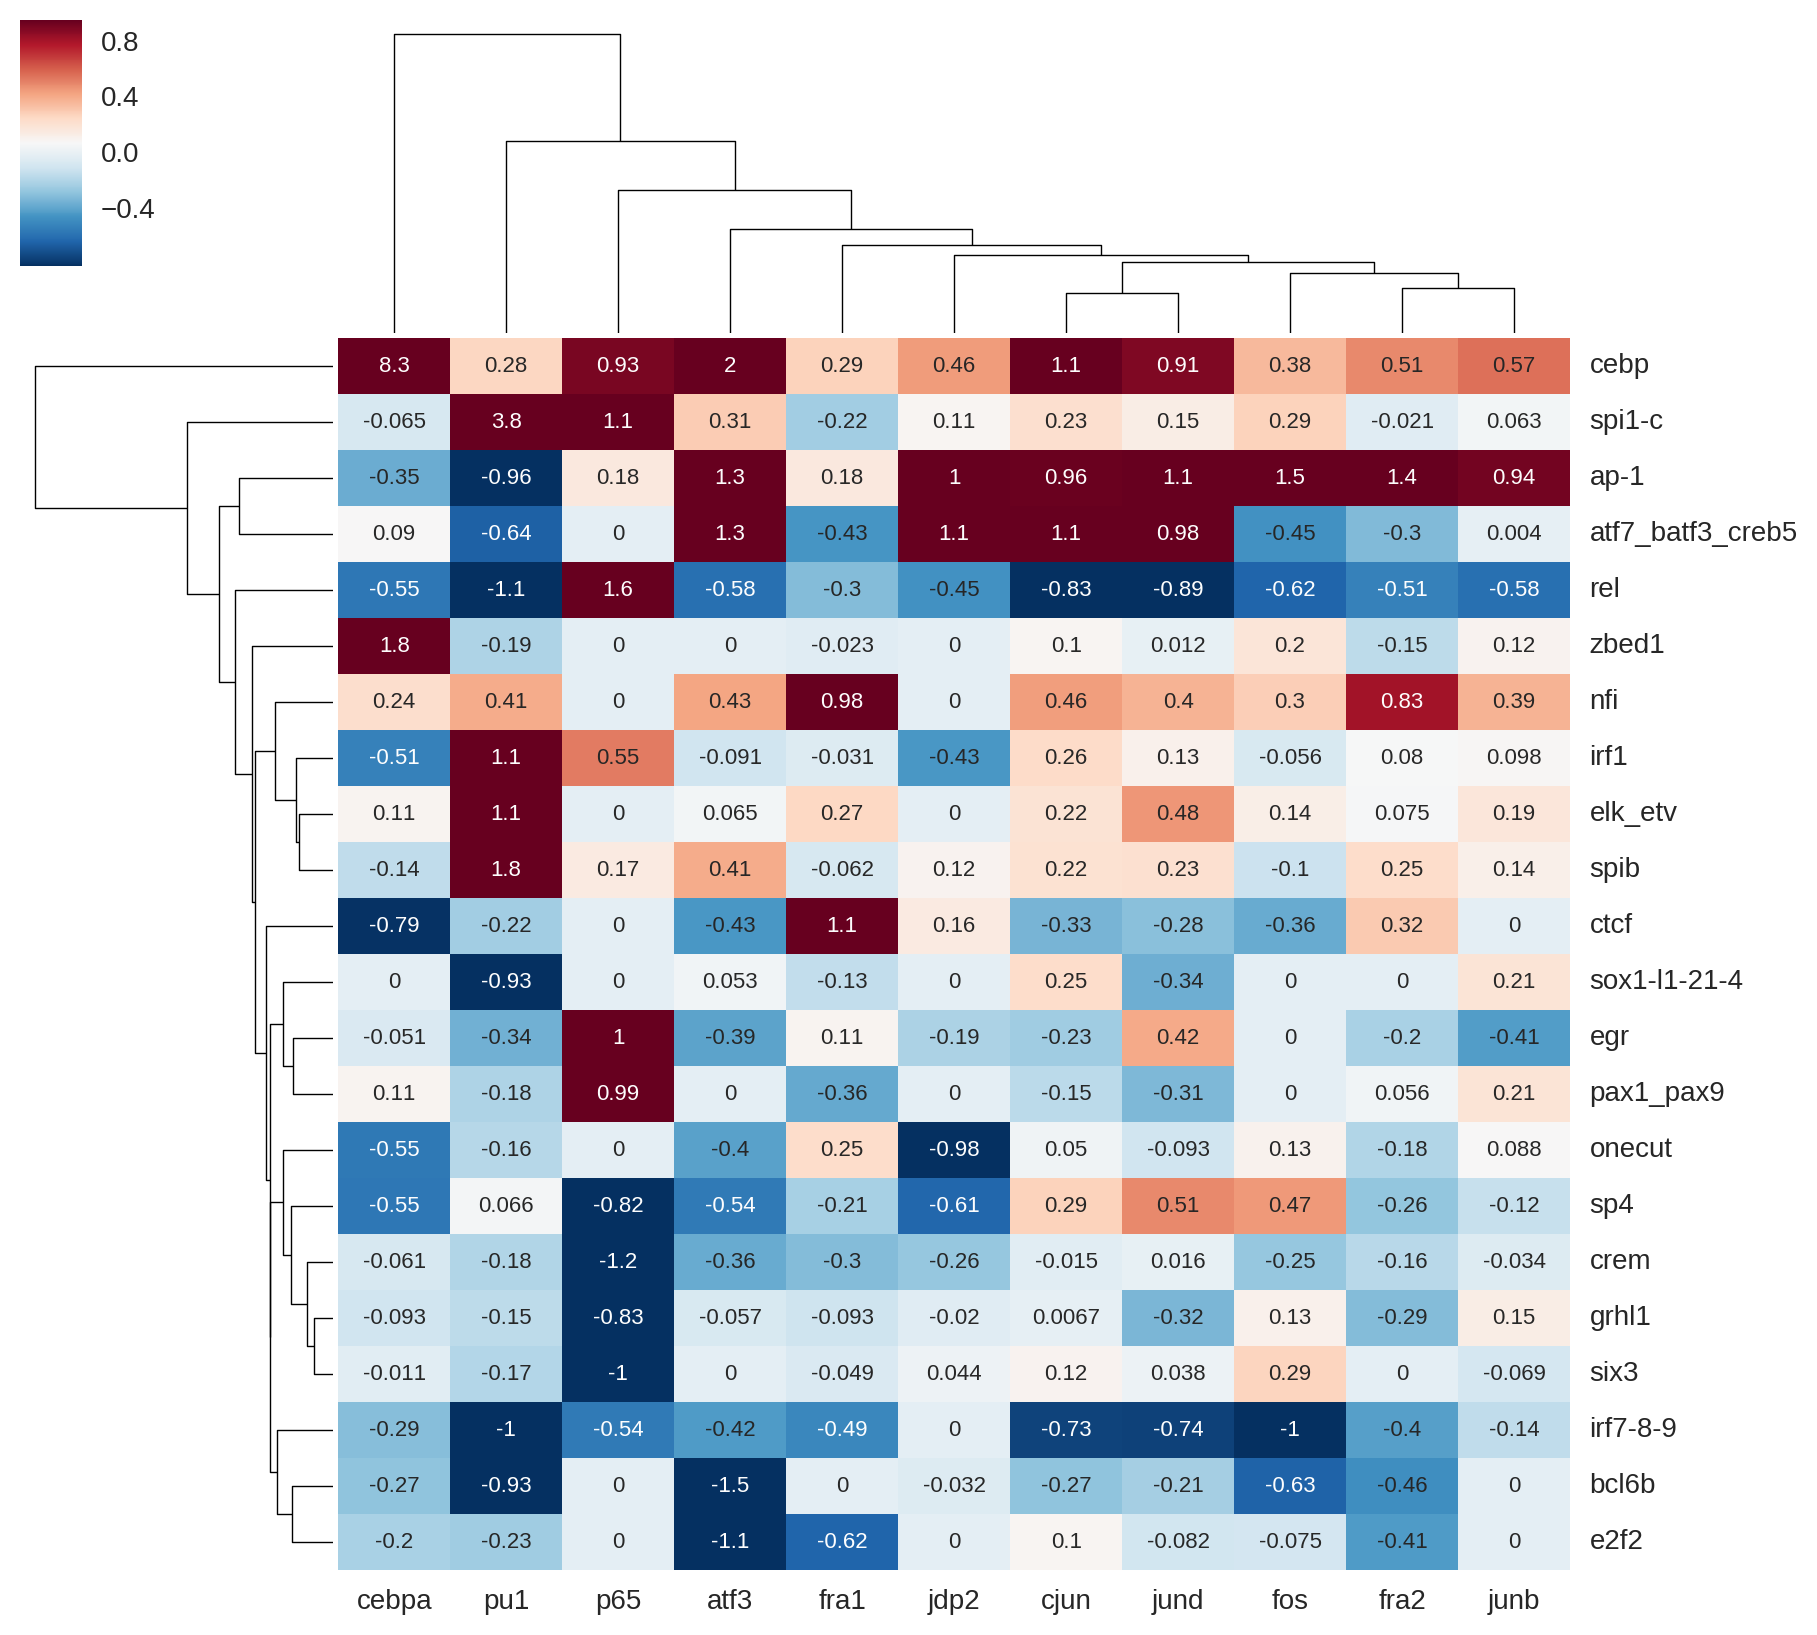

In [22]:
coeff_std = np.std(coefficients_frame_veh.values.flatten());
coeff_mean = np.mean(coefficients_frame_veh.values.flatten());
toExclude = ['jund', 'fos', 'junb'];
threshold =2.5;

cg = sns.clustermap(coefficients_frame_veh[
                                       (coefficients_frame_veh[[x for x in _factors if not x in toExclude]].max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_veh[[x for x in _factors if not x in toExclude]].min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8});

plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
# plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=0);

# hm = cg.ax_heatmap.get_position()
# cg.ax_heatmap.set_position([hm.x0, hm.y0, hm.width, hm.height*2])

# rd_pos = cg.ax_row_dendrogram.get_position()
# cg.ax_row_dendrogram.set_position([rd_pos.x0, rd_pos.y0, rd_pos.width, rd_pos.height*2])

# cd_pos = cg.ax_col_dendrogram.get_position()
# cg.ax_col_dendrogram.set_position([cd_pos.x0, cd_pos.y0+0.62, cd_pos.width, cd_pos.height])



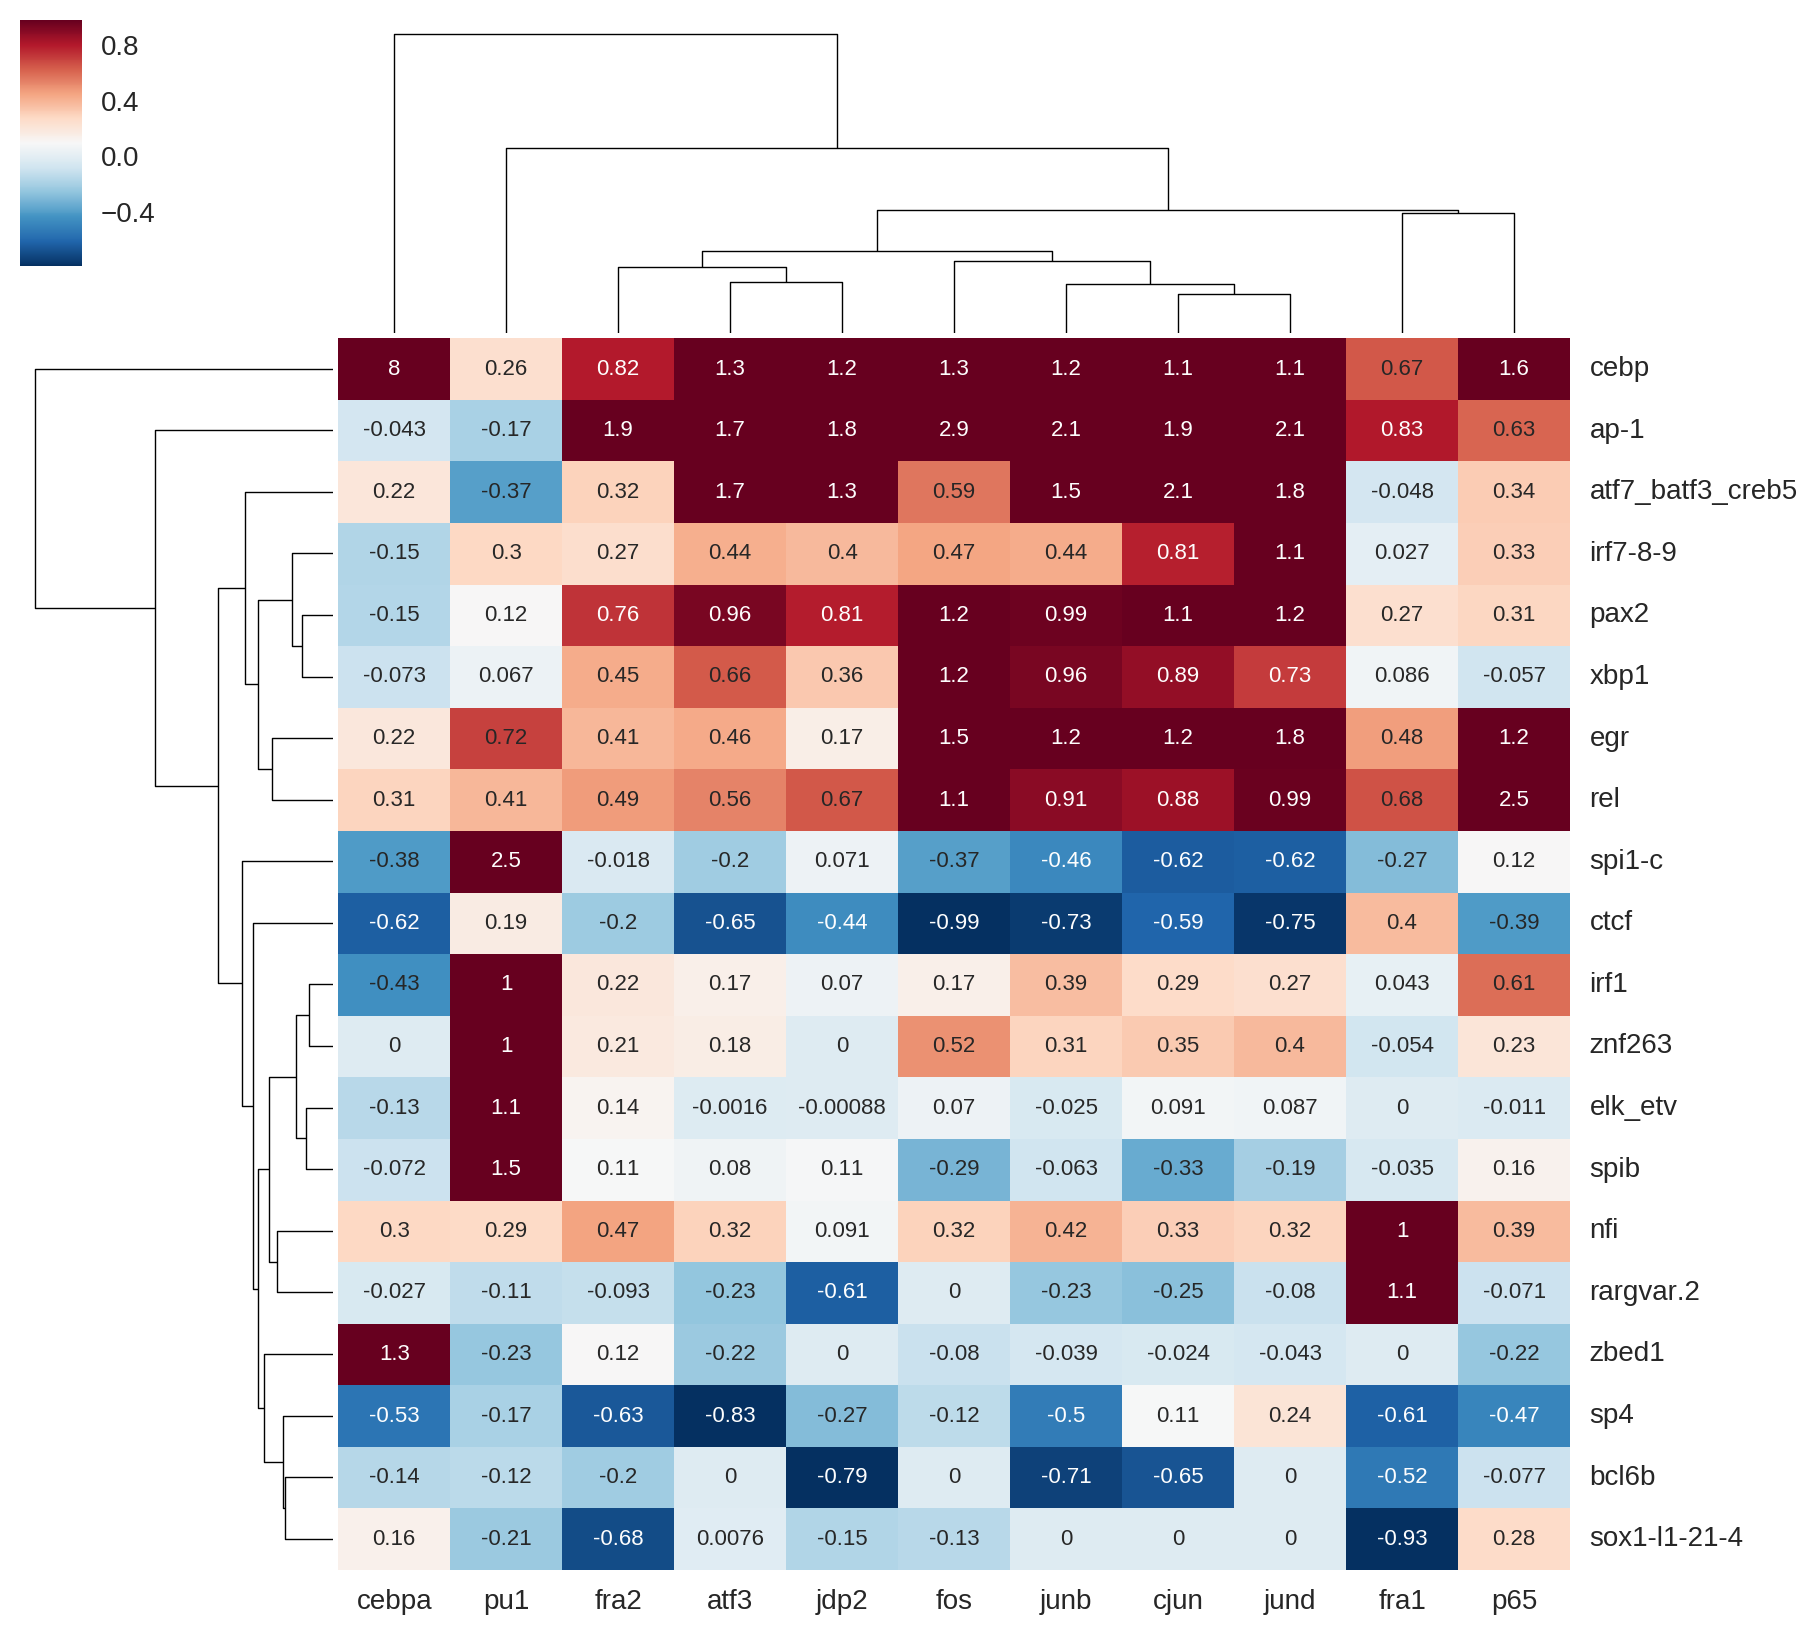

In [23]:
### plot coefficients for KLA treatment ###
coeff_std = np.std(coefficients_frame_kla.values.flatten())
coeff_mean = np.mean(coefficients_frame_kla.values.flatten())
threshold = 2.5

cg = sns.clustermap(coefficients_frame_kla[(coefficients_frame_kla.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_kla.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8})
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);




## Pairs of transcription factors

In [24]:
factorPairs = []
ap1_members = ['atf3','cjun', 'fra1','fra2', 'fos', 'jdp2', 'junb','jund']

# for i in range(len(_factors)-1):
#     for j in range(i+1, len(_factors)):
#         factorPairs.append(('c57bl6_'+_factors[i],'c57bl6_'+ _factors[j]))
        
        
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [ ]:
aucs = []
classifiers = []
metrics = []
factors = []

c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
    
for factorPair in factorPairs:
    print(factorPair)
    
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0]) & summary_frame['Factors'].str.contains(factorPair[1])

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)

    # Run classifier
    svm_classifier = svm.SVC(kernel='linear', probability=True)
    rf_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=50)
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    svm_classifier.fit(training_features, training_labels)
    rf_classifier.fit(training_features, training_labels)
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_svm = svm_classifier.predict_proba(test_features)
    probas_rf = rf_classifier.predict_proba(test_features)
    probas_lr = lr_classifier.predict_proba(test_features)
    
    # roc curv for svm
    fpr_svm, tpr_svm, thresholds_roc_svm = sklearn.metrics.roc_curve(test_labels, probas_svm[:, 1])
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    aucs.append(roc_auc_svm)
    
    # roc curv for rf
    fpr_rf, tpr_rf, thresholds_roc_rf = sklearn.metrics.roc_curve(test_labels, probas_rf[:, 1])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    aucs.append(roc_auc_rf)
   
    # roc curv for lr
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    aucs.append(roc_auc_lr)
       
    print('training set|', 'num samples:', len(training_labels), 'num True:', np.sum(training_labels))
    print('test set    |', 'num samples:', len(test_labels), 'num True:', np.sum(test_labels))
    print('lr_auc', roc_auc_lr)
    
    classifiers = classifiers + ['svm', 'rf', 'lr']
    factors = factors + ['_'.join(factorPair)] * 3
classifier_frame = pd.DataFrame({'factor':factors, 
                                 'AUC':aucs,
                                'classifier':classifiers})


In [ ]:
sns.factorplot(data = classifier_frame, 
               x='factor', 
               y='AUC', 
               hue='classifier',
              kind='point', size =10)
plt.xticks(rotation=90);
plt.title('ROC AUC')
plt.show()

In [136]:
### for all peaks in vehicle and KLA for all motifs



factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] +'_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_all_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs.index = motif_score_frame.columns.values[3:]

total: 82848 filtered: 68137 true gc: 0.47508 false gc: 0.48508 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.835519735005
total: 82848 filtered: 82848 true gc: 0.49645 false gc: 0.49928 difference: 0.00283
('c57bl6_atf3', 'c57bl6_fra1') 0.847643310406
total: 82848 filtered: 80416 true gc: 0.48764 false gc: 0.49764 difference: 0.01
('c57bl6_atf3', 'c57bl6_fra2') 0.849814821186
total: 82848 filtered: 69118 true gc: 0.47636 false gc: 0.48635 difference: 0.01
('c57bl6_atf3', 'c57bl6_fos') 0.836904773798
total: 82848 filtered: 69271 true gc: 0.47559 false gc: 0.48559 difference: 0.01
('c57bl6_atf3', 'c57bl6_jdp2') 0.84063016847
total: 82848 filtered: 75465 true gc: 0.48306 false gc: 0.49306 difference: 0.01
('c57bl6_atf3', 'c57bl6_junb') 0.849439446164
total: 82848 filtered: 66863 true gc: 0.47391 false gc: 0.48391 difference: 0.01
('c57bl6_atf3', 'c57bl6_jund') 0.829297096048
total: 82848 filtered: 82848 true gc: 0.50476 false gc: 0.49907 difference: 0.00568
('c57bl6_cjun', 'c57bl6_fr

In [137]:
coefficients_frame_all_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs = coefficients_frame_all_pairs[sorted(coefficients_frame_all_pairs.columns.values)]
coefficients_frame_all_pairs.index = motif_score_frame.columns.values[3:]

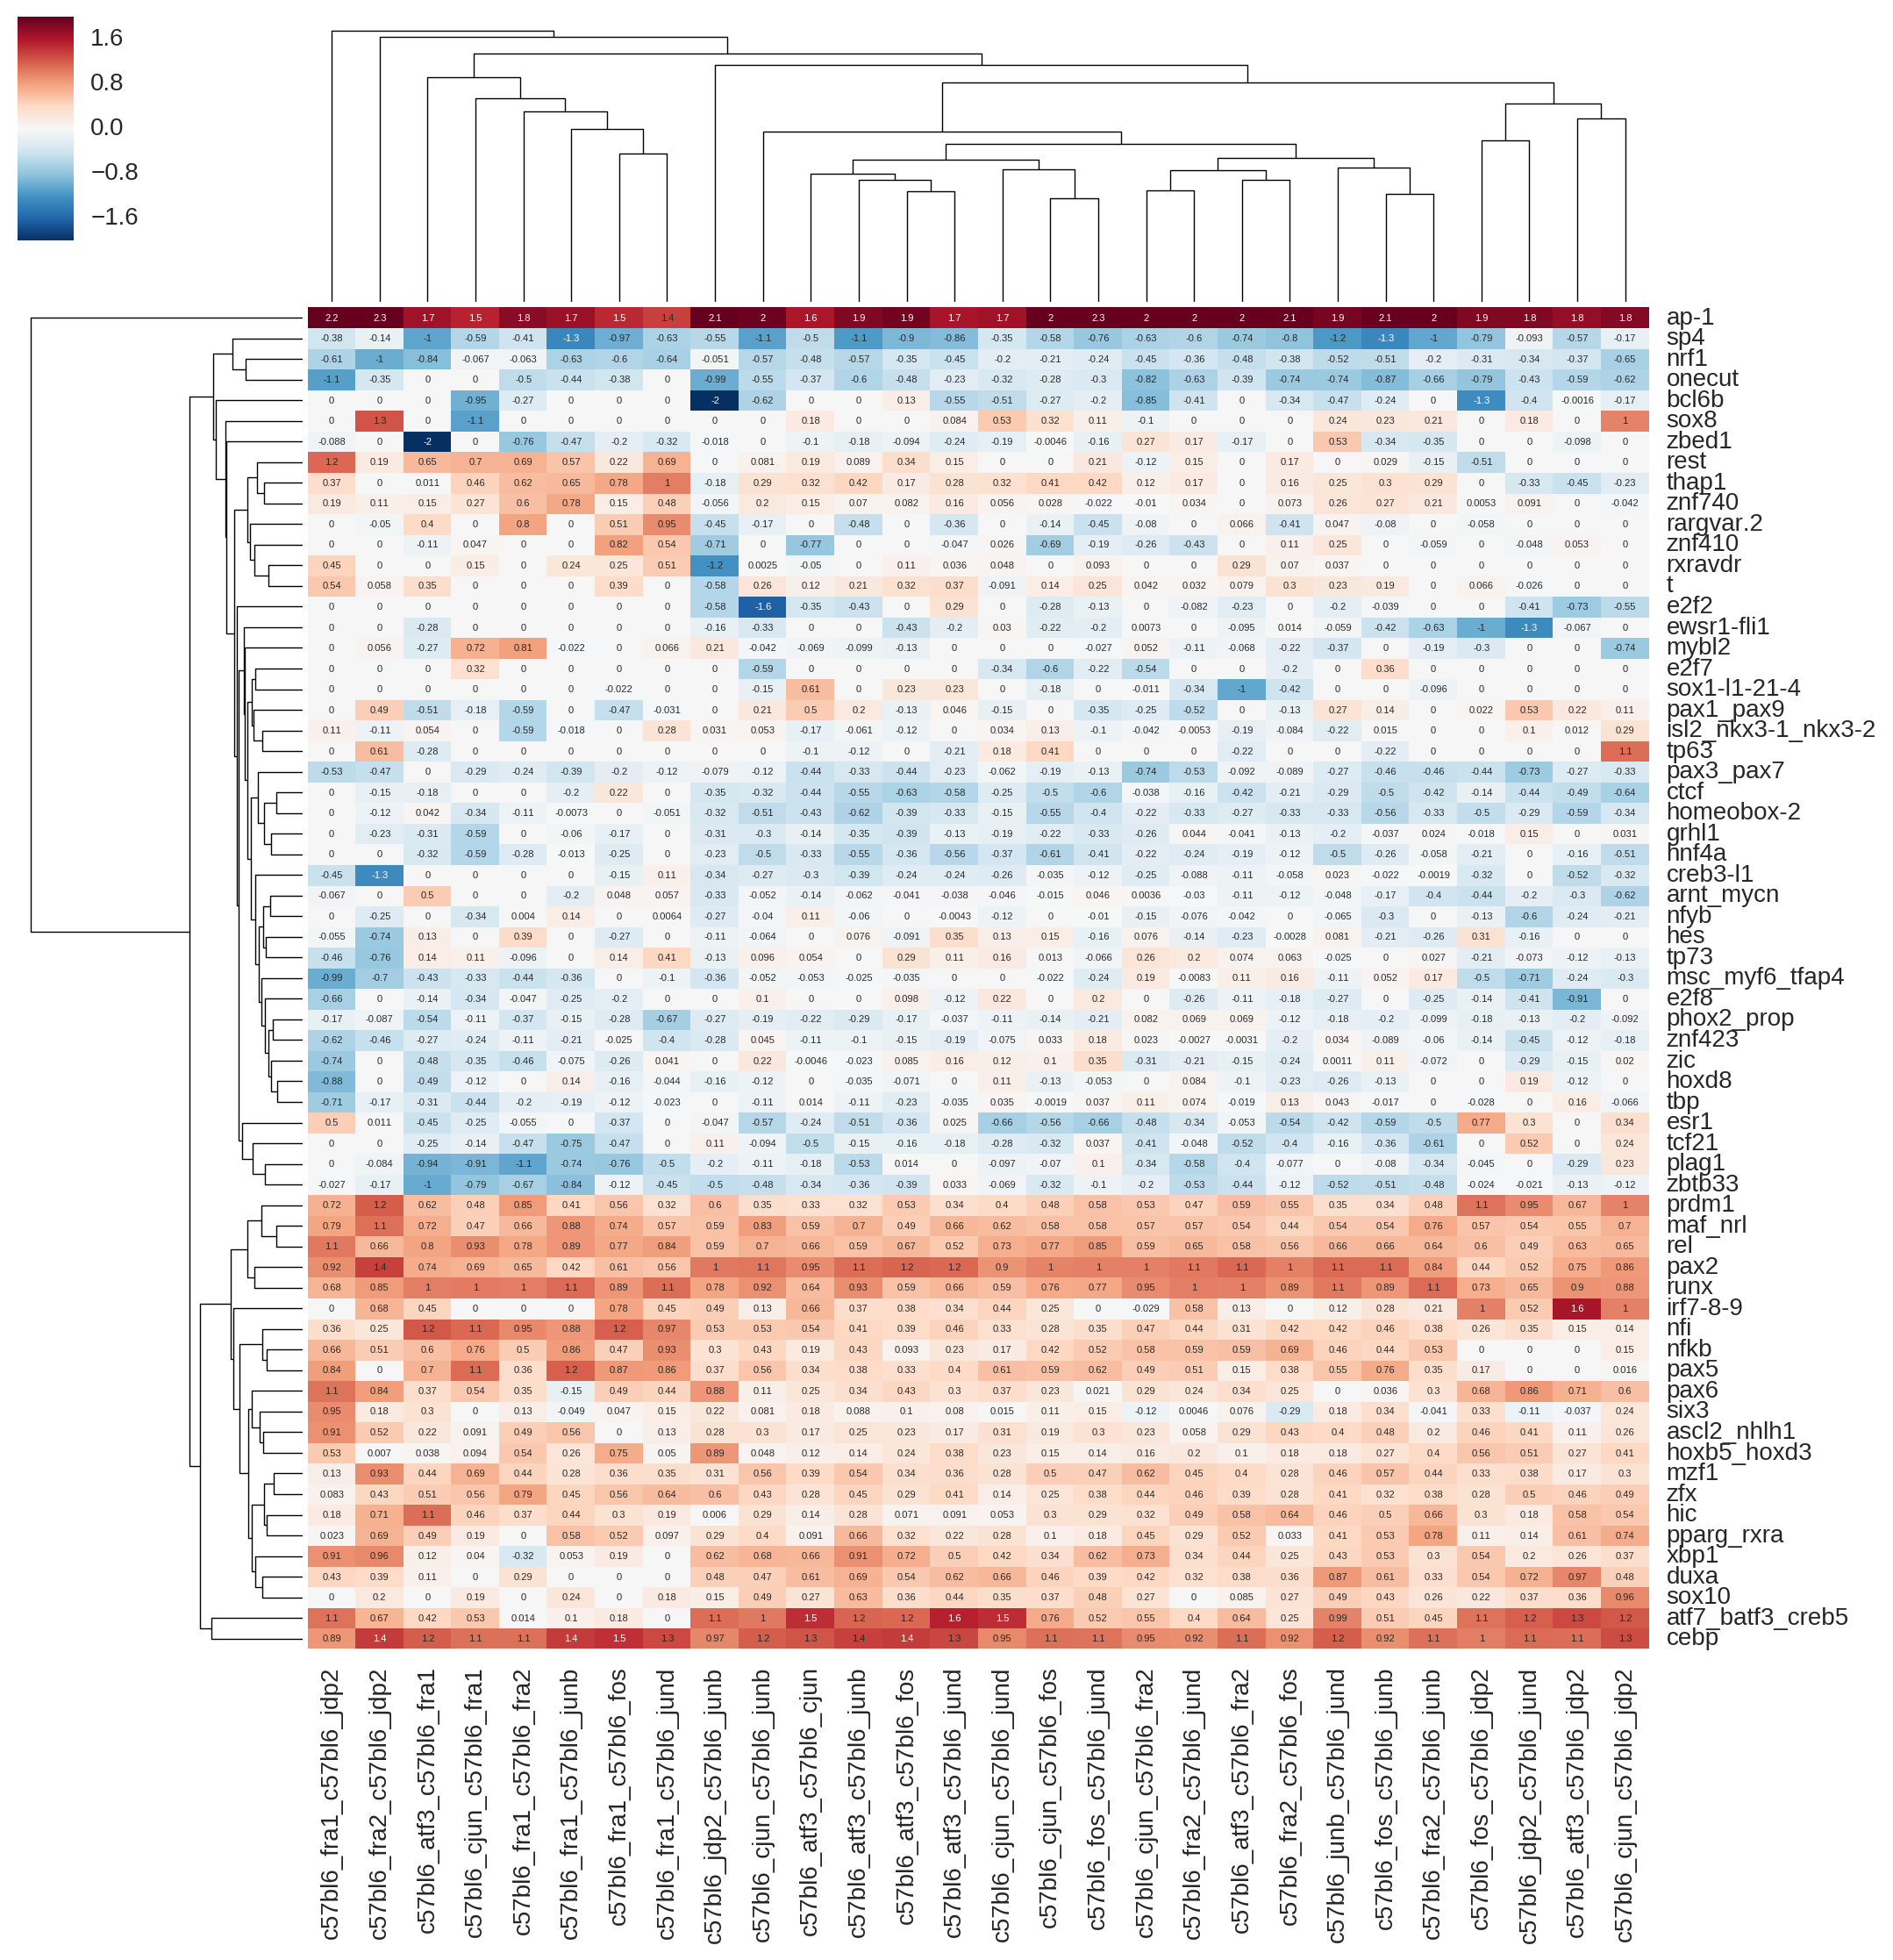

In [138]:
### plot coefficents for both vehicle and kla
threshold = 2.0
coeff_std = np.std(coefficients_frame_all_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_all_pairs.values.flatten())

cg = sns.clustermap(coefficients_frame_all_pairs[(coefficients_frame_all_pairs.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_all_pairs.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=-2,
                   vmin=2,
                   center = 0.0,
                   annot=True,annot_kws={"size": 4},
                   figsize=(12,12))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);




In [28]:
### for all peaks in vehicle and KLA for top motifs
factor_coeff_dict = {}
factor_auc_dict_pairs_top = {}
# motifs = ['ap-1','cebp','rel','spi1-c']
motifs = ['ap-1']
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][motifs]

    
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1]+'_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs_top['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)


coefficients_frame_all_pairs_top = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs_top.index = motifs

total: 82848 filtered: 68188 true gc: 0.47508 false gc: 0.48508 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.726584620788
total: 82848 filtered: 82848 true gc: 0.49645 false gc: 0.49928 difference: 0.00283
('c57bl6_atf3', 'c57bl6_fra1') 0.735802623314
total: 82848 filtered: 80311 true gc: 0.48764 false gc: 0.49764 difference: 0.01
('c57bl6_atf3', 'c57bl6_fra2') 0.751058953573
total: 82848 filtered: 69165 true gc: 0.47636 false gc: 0.48636 difference: 0.01
('c57bl6_atf3', 'c57bl6_fos') 0.742914997519
total: 82848 filtered: 69246 true gc: 0.47559 false gc: 0.48559 difference: 0.01
('c57bl6_atf3', 'c57bl6_jdp2') 0.754673407374
total: 82848 filtered: 75513 true gc: 0.48306 false gc: 0.49306 difference: 0.01
('c57bl6_atf3', 'c57bl6_junb') 0.745755995213
total: 82848 filtered: 66909 true gc: 0.47391 false gc: 0.48391 difference: 0.01
('c57bl6_atf3', 'c57bl6_jund') 0.724586613835
total: 82848 filtered: 82848 true gc: 0.50476 false gc: 0.49907 difference: 0.00568
('c57bl6_cjun', 'c57bl6_f

In [141]:
### for all peaks in vehicle and KLA using significant motifs

threshold  = 2.0
factor_motifs_dict = {}
significant_motifs = set()
# std = np.std(coefficients_frame_all_pairs.values)
# mean = np.mean(coefficients_frame_all_pairs.values)

for factor in coefficients_frame_all_pairs.columns.values:
    weights = coefficients_frame_all_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    for m in motif_hits:
        significant_motifs.add(m)
    print(factor, mean-threshold*std, mean+threshold*std)

    factor_motifs_dict[factor] = motif_hits
significant_motifs = sorted(significant_motifs)
    
factor_coeff_dict = {}
factor_auc_dict_all_pairs_best = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][significant_motifs]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] +'_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_all_pairs_best['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_all_pairs_best = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs_best.index = significant_motifs




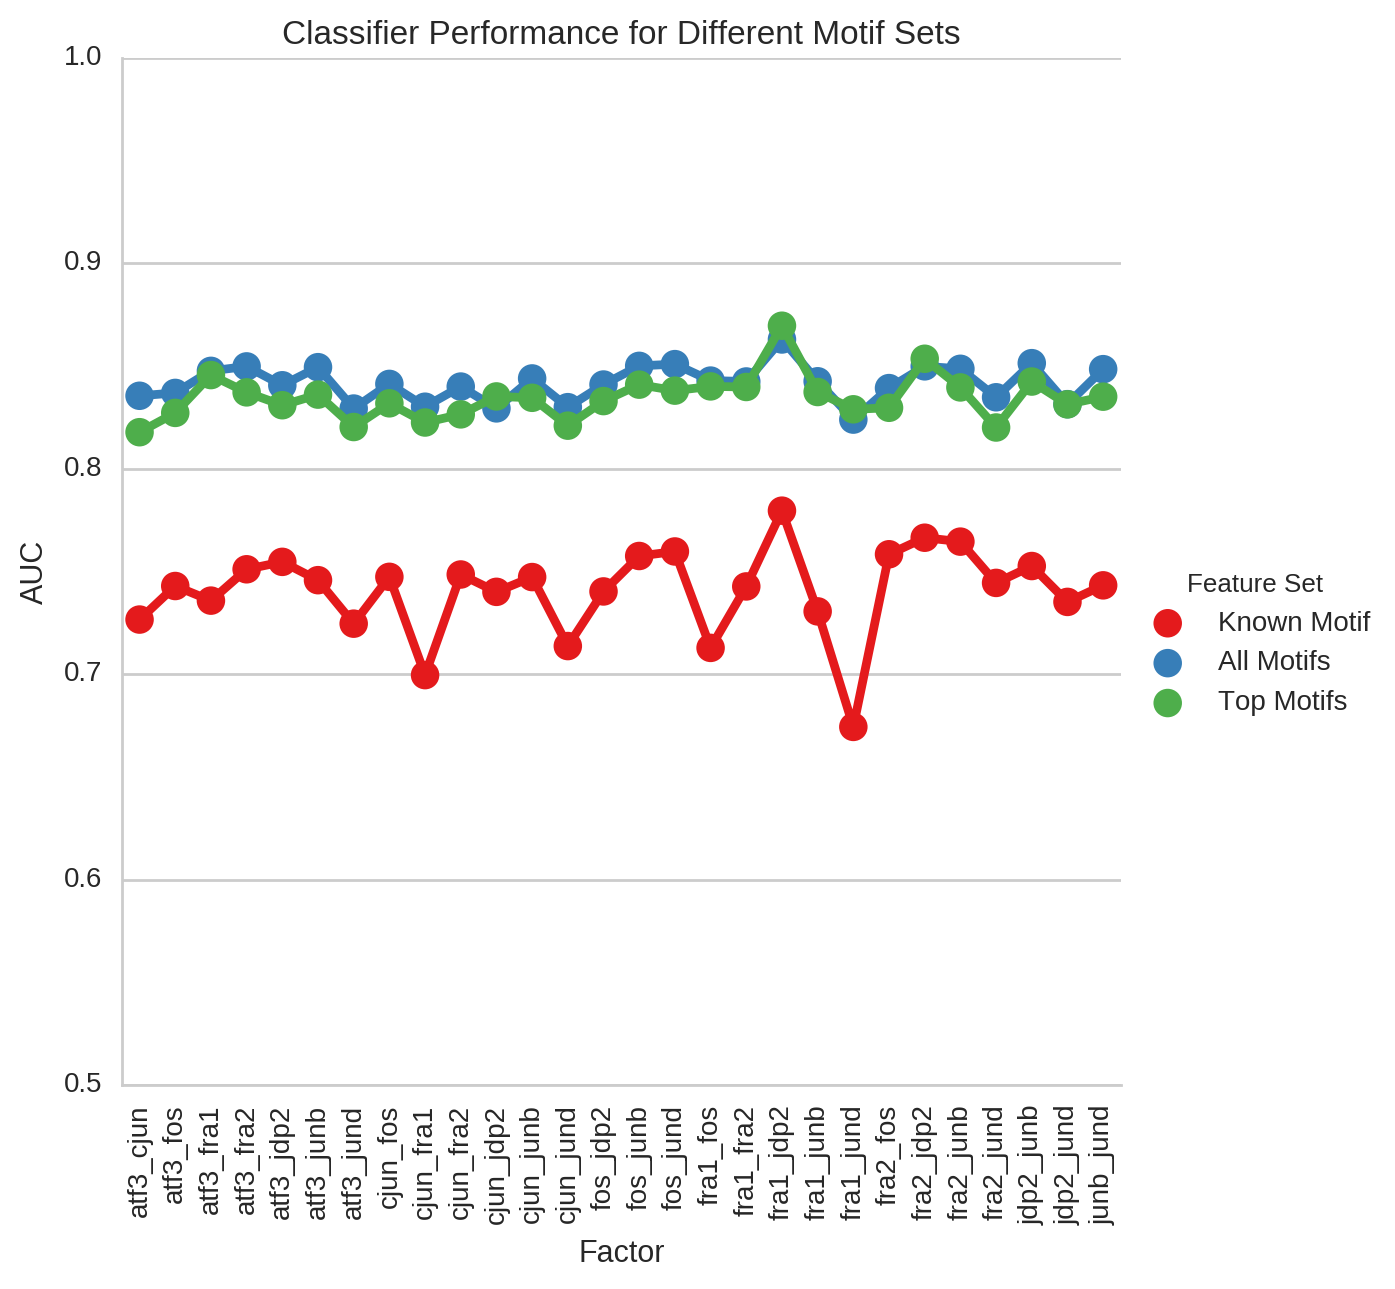

In [142]:
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_pairs.keys()):
#     if factor.split('_')[0] in ap1_members and factor.split('_')[1] in ap1_members:
    if True:
        factors = factors + 3 * [factor]
        features = features + ['Known Motif', 'All Motifs', 'Top Motifs']
        aucs.append(factor_auc_dict_pairs_top[factor])
        aucs.append(factor_auc_dict_pairs[factor])
        aucs.append(factor_auc_dict_all_pairs_best[factor])
with sns.axes_style('whitegrid'):
    plottingFrame = sns.factorplot(data = pd.DataFrame({'Factor':factors,
                                                         'AUC':aucs,
                                                         'Feature Set':features}),
                                x='Factor',
                                y='AUC',
                                hue='Feature Set',
                                palette='Set1',
                                size=6)
    plt.xticks(rotation=90)
    plt.ylim(0.5,1)
    plt.title('Classifier Performance for Different Motif Sets')

In [131]:
### for all peaks in vehicle for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_veh_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_pairs.index = motif_score_frame.columns.values[3:]

total: 82848 filtered: 67808 true gc: 0.47411 false gc: 0.48411 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.832998201018
total: 82848 filtered: 82848 true gc: 0.50377 false gc: 0.49913 difference: 0.00464
('c57bl6_atf3', 'c57bl6_fra1') 0.840532189411
total: 82848 filtered: 82848 true gc: 0.49942 false gc: 0.49921 difference: 0.00022
('c57bl6_atf3', 'c57bl6_fra2') 0.856455856663
total: 82848 filtered: 66227 true gc: 0.52246 false gc: 0.51246 difference: 0.01
('c57bl6_atf3', 'c57bl6_fos') 0.893327878705
total: 82848 filtered: 82848 true gc: 0.49635 false gc: 0.49925 difference: 0.00291
('c57bl6_atf3', 'c57bl6_jdp2') 0.845505714322
total: 82848 filtered: 77799 true gc: 0.51286 false gc: 0.50286 difference: 0.01


KeyboardInterrupt: 

In [ ]:
### for all peaks in KLA for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] + '_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_kla_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla_pairs.index = motif_score_frame.columns.values[3:]

### Investingating PU1 and CEBP

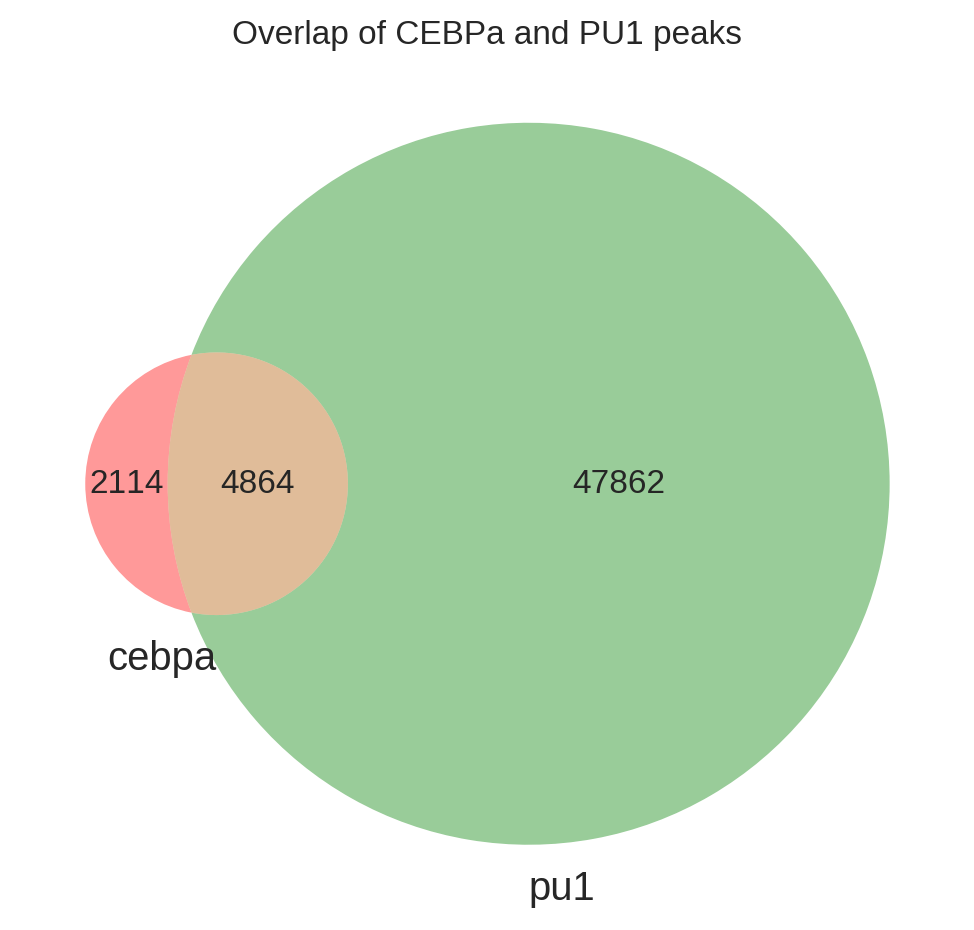

In [33]:
matplotlib_venn.venn2(
[set(summary_frame[summary_frame['Factors'].str.contains('cebpa_veh')].index.values),
 set(summary_frame[summary_frame['Factors'].str.contains('pu1_veh')].index.values)
],
set_labels=['cebpa', 'pu1'])
plt.title('Overlap of CEBPa and PU1 peaks')

In [34]:
factor_coeff_dict = {}
fraction =0.5
lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

feature_frame = normed_motif_frame

### for cebpa only ###
features = feature_frame.copy()
labels = summary_frame['Factors'].str.contains('cebpa_veh') & \
    [not x for x in summary_frame['Factors'].str.contains('pu1_veh')]
training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
lr_classifier.fit(training_features, training_labels)
coefficients = lr_classifier.coef_
factor_coeff_dict['cebpa only'] = coefficients.flatten()


### for pu1 only ###
features = feature_frame.copy()
labels = summary_frame['Factors'].str.contains('pu1_veh') & \
    [not x for x in summary_frame['Factors'].str.contains('cebpa_veh')]
training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
lr_classifier.fit(training_features, training_labels)
coefficients = lr_classifier.coef_
factor_coeff_dict['pu1 only'] = coefficients.flatten()

### for cebpa and pu1 ###
features = feature_frame.copy()
labels = summary_frame['Factors'].str.contains('pu1_veh') & \
    summary_frame['Factors'].str.contains('cebpa_veh')    
training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
lr_classifier.fit(training_features, training_labels)
coefficients = lr_classifier.coef_
factor_coeff_dict['cebpa_pu1'] = coefficients.flatten()

### all cebpa ###
features = feature_frame.copy()
labels = summary_frame['Factors'].str.contains('cebpa_veh')
training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
lr_classifier.fit(training_features, training_labels)
coefficients = lr_classifier.coef_
factor_coeff_dict['all cebpa'] = coefficients.flatten()

### all pu1 ###
features = feature_frame.copy()
labels = summary_frame['Factors'].str.contains('pu1_veh')
training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
lr_classifier.fit(training_features, training_labels)
coefficients = lr_classifier.coef_
factor_coeff_dict['all pu1'] = coefficients.flatten()
frame = pd.DataFrame(factor_coeff_dict)
frame.index = features.columns.values




total: 126891 filtered: 118782 true gc: 0.47229 false gc: 0.48229 difference: 0.01
total: 126891 filtered: 126891 true gc: 0.48996 false gc: 0.48495 difference: 0.00501
total: 126891 filtered: 115488 true gc: 0.47035 false gc: 0.48035 difference: 0.01
total: 126891 filtered: 116066 true gc: 0.47079 false gc: 0.48079 difference: 0.01
total: 126891 filtered: 126891 true gc: 0.48787 false gc: 0.48641 difference: 0.00147


1.216009362 -1.06554681903


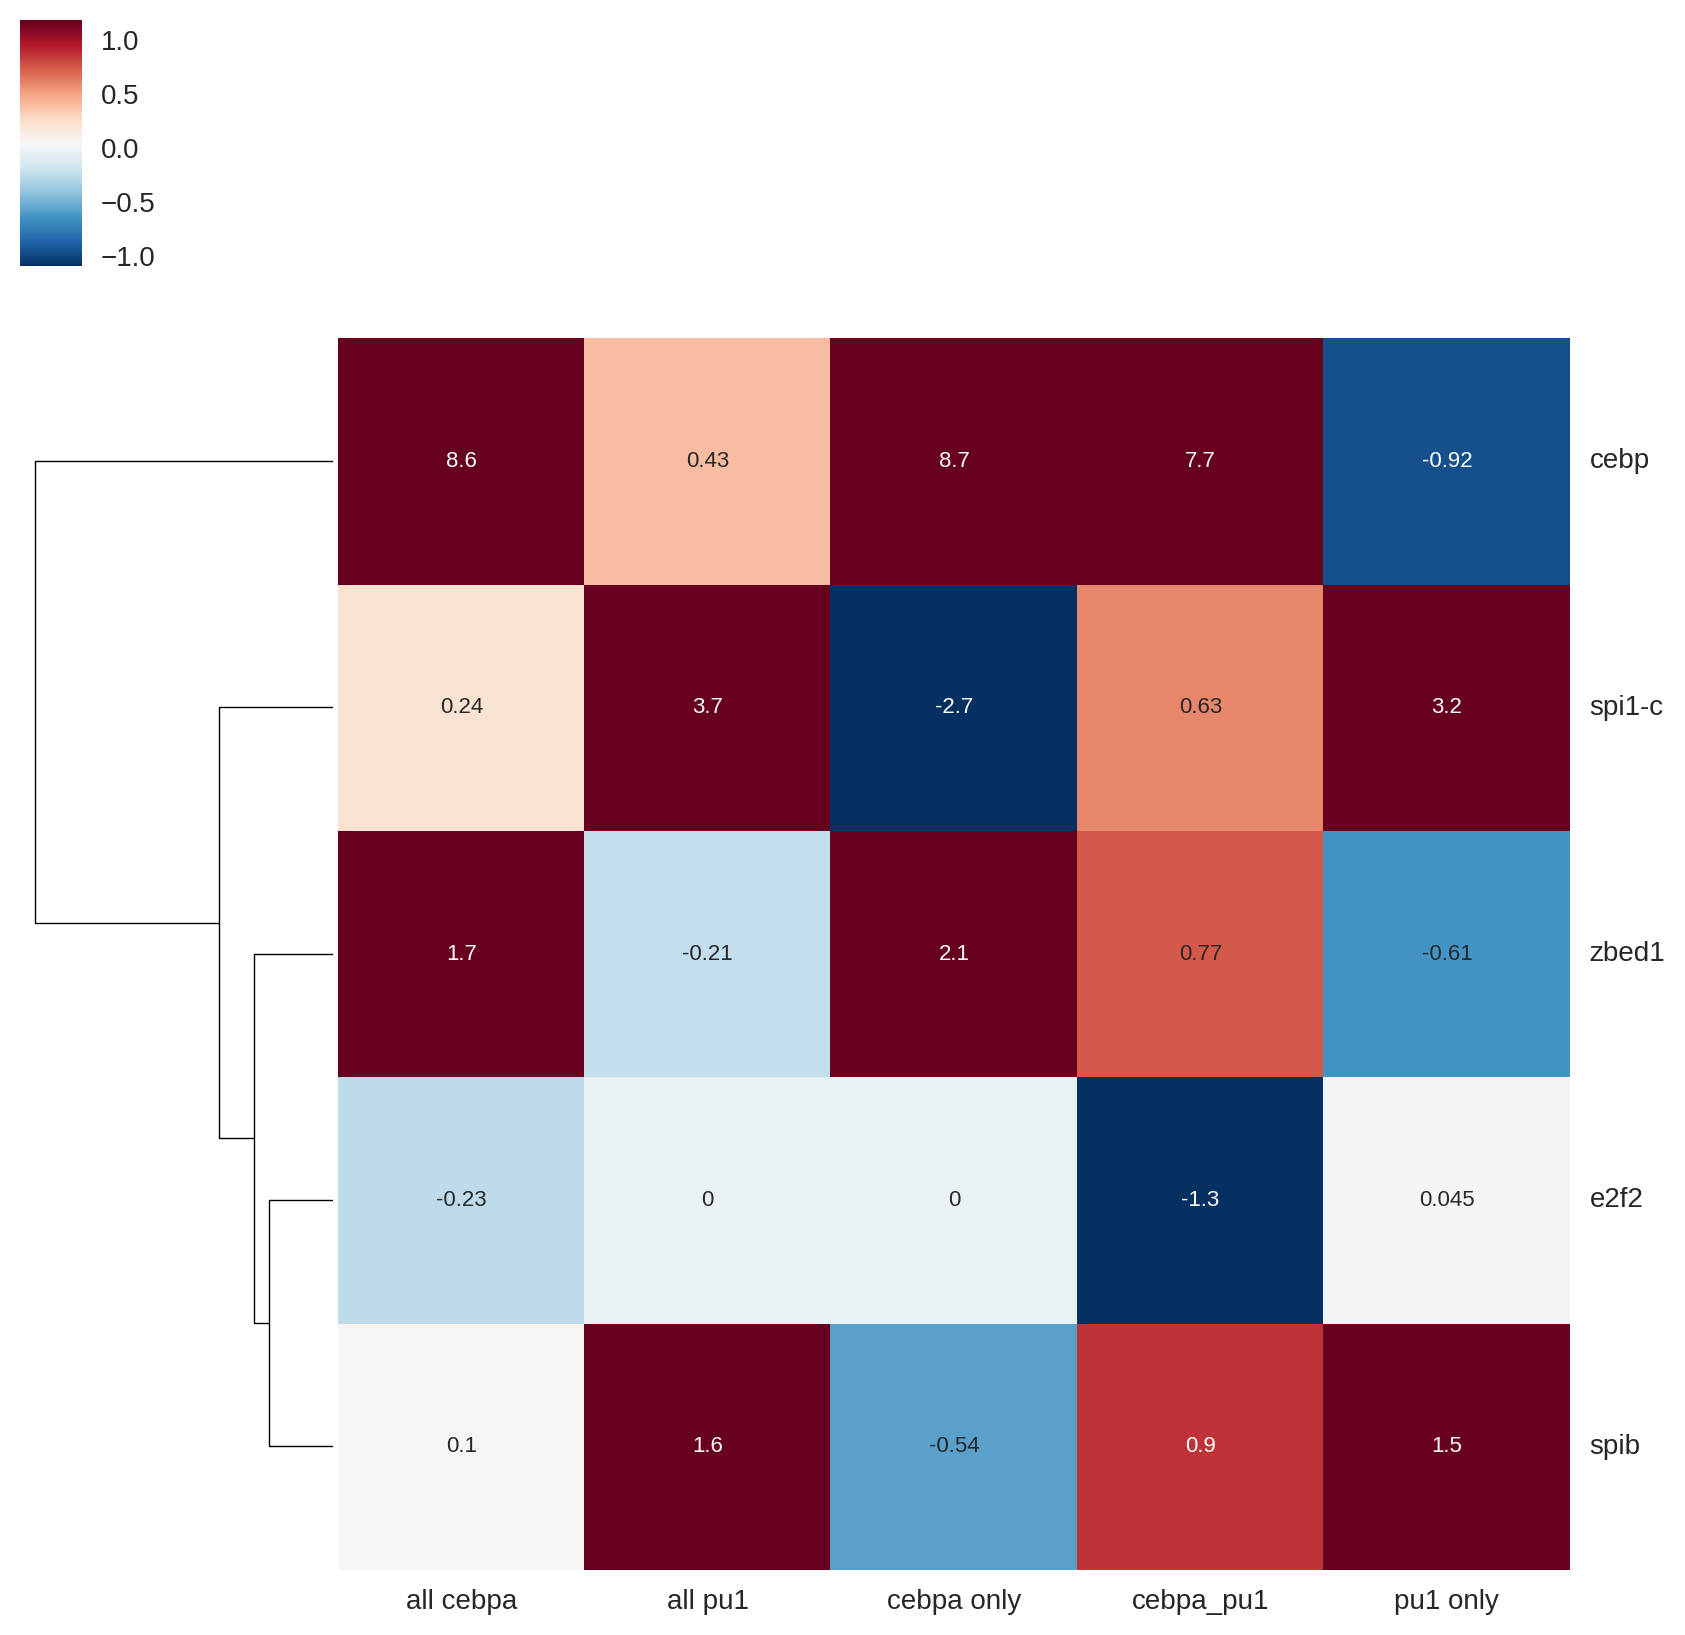

In [ ]:
### plot coefficents for both vehicle and kla
threshold = 2
coeff_std = np.std(frame.values.flatten())
coeff_mean = np.mean(frame.values.flatten())
print(coeff_mean + threshold* coeff_std,
       coeff_mean - threshold* coeff_std)
significant_indices = (frame.max(axis=1) > coeff_mean + threshold* coeff_std) | \
                                       (frame.min(axis=1) < coeff_mean - threshold* coeff_std)
significant_motifs = frame[significant_indices].index.values
cg = sns.clustermap(frame[significant_indices],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8},
#                    figsize=(6,6),
                   col_cluster=False)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);

In [ ]:
### plot distribution of motif scores
# for motif in significant_motifs:
factors = []
motifs = []
scores = []

for motif in significant_motifs:
    print(motif)
    ### all cebpa ###
    currentScores = list(motif_score_frame[motif_score_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('cebpa_veh')
                                                                ].index.values)][motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['all cebpa']
    
    ### all pu1 ###
    currentScores = list(motif_score_frame[motif_score_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('pu1_veh')
                                                                ].index.values)][motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['all pu1']
    
    ### for cebpa only ###
    currentScores = list(motif_score_frame[motif_score_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('cebpa_veh') & \
        [not x for x in summary_frame['Factors'].str.contains('pu1_veh')]].index.values)][motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['cebpa only']
    
    ### for pu1 only ###
    currentScores = list(motif_score_frame[motif_score_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('pu1_veh') & \
        [not x for x in summary_frame['Factors'].str.contains('cebpa_veh')]].index.values)][motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['pu1 only']

    ### for cebpa and pu1 ###
    currentScores = list(motif_score_frame[motif_score_frame.index.isin(summary_frame[summary_frame['Factors'].str.contains('pu1_veh') & \
        summary_frame['Factors'].str.contains('cebpa_veh')].index.values)][motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['cebpa and pu1']
    
    
    ### all ###
    currentScores = list(motif_score_frame[motif].values)
    scores = scores + currentScores
    motifs = motifs + len(currentScores) * [motif]
    factors = factors + len(currentScores) * ['all sites']
current_frame = pd.DataFrame({'motif':motifs,
                             'score':scores,
                             'factors':factors})
for motif in significant_motifs:

    sns.factorplot(data=current_frame[current_frame['motif']==motif], y='score', x='factors', kind='box', 
              sharey=True,
              showfliers=False  
#               cut=0,
#               inner='quartile'
                   
              )
    plt.title(motif)
    plt.xticks(rotation=90);
    plt.show()

### Pairs of AP-1 Members

In [ ]:
factorPairs = []
ap1_members = ['atf3','cjun']
for i in range(len(ap1_members)):
    for j in range(i, len(ap1_members)):
        print(ap1_members[i], ap1_members[j])
        factorPairs.append((ap1_members[i], ap1_members[j]))
        labels = summary_frame['Factors'].str.contains(ap1_members[i] + '_veh') & \
        summary_frame['Factors'].str.contains(ap1_members[j] + '_veh')
        print(np.sum(labels))


In [ ]:
### for all peaks in vehicle and KLA
factor_coeff_dict = {}
for factorPair in factorPairs:
    print(factorPair)
    features = normed_motif_frame
#     features = motif_score_frame.ix[:,3:]
    labels = summary_frame['Factors'].str.contains(factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression()
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_lr = lr_classifier.predict(test_features)
    
    coefficients = lr_classifier.coef_
    intercept = lr_classifier.intercept_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
coefficients_frame_ap1_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_ap1_pairs.index = motif_score_frame.columns.values[3:]

In [ ]:
### plot coefficents for both vehicle and kla
threshold = 2.0
coeff_std = np.std(coefficients_frame_ap1_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_ap1_pairs.values.flatten())
print(coeff_mean + threshold* coeff_std,
       coeff_mean - threshold* coeff_std)
significant_indices = (coefficients_frame_ap1_pairs.max(axis=1) > coeff_mean + threshold* coeff_std) | \
                                       (coefficients_frame_ap1_pairs.min(axis=1) < coeff_mean - threshold* coeff_std)
significant_motifs = coefficients_frame_ap1_pairs[significant_indices].index.values
cg = sns.clustermap(coefficients_frame_ap1_pairs.ix[significant_motifs,['atf3_atf3','atf3_cjun','cjun_cjun']],
                   vmax=coeff_mean + threshold* coeff_std,
                   vmin=coeff_mean - threshold* coeff_std,
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8},
                   figsize=(8,8),
                   col_cluster=False)
            
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);

In [ ]:
matplotlib_venn.venn3(
[set(summary_frame[summary_frame['Factors'].str.contains('cebpa_veh')].index.values),
 set(summary_frame[summary_frame['Factors'].str.contains('atf3_veh')].index.values),
 set(summary_frame[summary_frame['Factors'].str.contains('cjun_veh')].index.values)
],
set_labels=['cebpa', 'atf3', 'cebpa'])
plt.title('Overlap of CEBPa and PU1 peaks')

## Visualization of Overlaps

In [ ]:
import networkx as nx
current_palette = sns.color_palette()


In [ ]:
### create network representation for VEH ###
cols = [x for x in bool_frame.columns if 'veh' in x]
veh_frame = bool_frame[cols]
network = nx.Graph()
for g in cols:
    factor = g.split('_')[0]
    network.add_node(factor, factor=factor)
#     network.add_node(g, environment=environmentDict[g], expression_veh=expressionDict_veh[g], expression_kla = expressionDict_kla[g])

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs)) + 1
        network.add_edge(factor1, factor2, sharedMotifs=num_shared_motifs)
# nx.draw_circular(network, edges=edges, width=weights)
edgewidth=[]
for (u,v,d) in network.edges(data=True):
    edgewidth.append(network.get_edge_data(u,v)['sharedMotifs'])
edgewidth = np.array(edgewidth)/15
  
nx.draw_circular(network, 
                node_size=2000, 
                node_color=current_palette[0],
                width=edgewidth,
                )

plt.gca().set_aspect('equal')
nx.write_graphml(network,'veh_graphml.xml')


In [ ]:
### create network representation for KLA ###
cols = [x for x in bool_frame.columns if 'kla' in x]
veh_frame = bool_frame[cols]
network = nx.Graph()
for g in cols:
    factor = g.split('_')[0]
    network.add_node(factor, factor=factor)
#     network.add_node(g, environment=environmentDict[g], expression_veh=expressionDict_veh[g], expression_kla = expressionDict_kla[g])

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs)) + 1
        network.add_edge(factor1, factor2, sharedMotifs=num_shared_motifs)
# nx.draw_circular(network, edges=edges, width=weights)
edgewidth=[]
for (u,v,d) in network.edges(data=True):
    edgewidth.append(network.get_edge_data(u,v)['sharedMotifs'])
edgewidth = np.array(edgewidth)/25
  
nx.draw_circular(network, 
                node_size=2000, 
                node_color=current_palette[1],
                width=edgewidth,
                )

plt.gca().set_aspect('equal')
nx.write_graphml(network,'kla_graphml.xml')



In [ ]:
### plot how significant motifs overlap with one another

cols = [x for x in bool_motif_frame.columns if 'veh' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_motif_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
#     sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', mask=mask, vmax=100)
    sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', vmax=100)

    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for Vehicle Peaks')
    plt.show()
    
# for KLA
cols = [x for x in bool_motif_frame.columns if 'kla' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_motif_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
#     sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', mask=mask, vmax=100)
    sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', vmax=100)
    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for KLA Peaks')

In [ ]:
### plot how significant motifs overlap with one another

cols = [x for x in bool_frame.columns if 'veh' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs

with sns.axes_style("white"):
    sns.heatmap(np.log2(matrix+1), xticklabels = cols, yticklabels=cols, cmap='Greens', square=True)
    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for Vehicle Peaks')
    plt.show()
    
# for KLA
cols = [x for x in bool_frame.columns if 'kla' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs
with sns.axes_style("white"):
    sns.heatmap(np.log2(matrix+1), xticklabels = cols, yticklabels=cols, cmap='Greens', square = True)
    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for KLA Peaks')

## Strains Stuff

In [46]:
### read in strains SNPs ###

# filter away SNPS that didn't pass all qc metrics
!grep PASS ./strains_snps/BALB_cJ.mgp.v5.snps.dbSNP142.vcf  > ./strains_snps/balbcj_passed_snps.txt
!grep PASS ./strains_snps/BALB_cJ.mgp.v5.snps.dbSNP142.vcf  > ./strains_snps/nod_passed_snps.txt

In [77]:
chrom_size_dict = {
    '1':196,
'2':182,
'3':160,
'4':157,
'5':152,
'6':150,
'7':145,
'8':129,
'9':125,
'10':131,
'11':122,
'12':120,
'13':120,
'14':125,
'15':104,
'16':91,
'17':95,
'18':91,
'19':61,
'X':10,
'Y':10,
'MT':10,
}

In [ ]:
balbcj_chr_snp_dict = {}
for chr in [str(x) for x in range(1,20)] + ['X','Y','MT']:
#     balb_chr_snp_dict[chr] = np.array([False] * (chrom_size_dict[chr]*100000))
    balbcj_chr_snp_dict[chr] = np.array([False] * (200*1000000))

print('reading balbcj snps')
with open('./strains_snps/balbcj_passed_snps.txt') as f:
    data = f.readlines()
for line in data:

    tokens = line.split('\t')
    chr = tokens[0]
    position = int(tokens[1])
    
    balbcj_chr_snp_dict[chr][position] = True

    


In [ ]:
motif_balbcj_snp_frame = motif_start_frame[['ID', 'Factors', 'chr']]
motif_balbcj_snp_frame.index = motif_balbcj_snp_frame['ID'].values
for motif in motif_start_frame.columns[3:]:
    print(motif)
    starts = motif_start_frame[motif]
    ends = motif_end_frame[motif]
    chromosomes = motif_balbcj_snp_frame['chr']
    num_snp_list =  []
    for i in range(len(starts)):
        current_start = starts[i]
        current_end = ends[i]
        current_chr = chromosomes[i].replace('chr','')
        if current_start * current_end > 0:
            num_snp_list.append(np.sum(balbcj_chr_snp_dict[current_chr][current_start:current_end+1]))
        else:
            num_snp_list.append(0)
    motif_balbcj_snp_frame[motif] = num_snp_list

In [102]:
motif_balbcj_snp_frame.to_pickle('./motif_balbcj_snp_frame.pickle')

In [178]:
nod_chr_snp_dict = {}
for chr in [str(x) for x in range(1,20)] + ['X','Y','MT']:

    nod_chr_snp_dict[chr] = np.array([False] * (200*1000000))

print('reading nod snps')
with open('./strains_snps/nod_passed_snps.txt') as f:
    data = f.readlines()
for line in data:
    counter +=1
    tokens = line.split('\t')
    chr = tokens[0]
    position = int(tokens[1])
    
    nod_chr_snp_dict[chr][position] = True

reading nod snps


In [ ]:
motif_nod_snp_frame = motif_start_frame[['ID', 'Factors', 'chr']]
motif_nod_snp_frame.index = motif_balbcj_snp_frame['ID'].values
for motif in motif_start_frame.columns[3:]:
    print(motif)
    starts = motif_start_frame[motif]
    ends = motif_end_frame[motif]
    chromosomes = motif_nod_snp_frame['chr']
    num_snp_list =  []
    for i in range(len(starts)):
        current_start = starts[i]
        current_end = ends[i]
        current_chr = chromosomes[i].replace('chr','')
        if current_start * current_end > 0:
            num_snp_list.append(np.sum(nod_chr_snp_dict[current_chr][current_start:current_end+1]))
        else:
            num_snp_list.append(0)
    motif_nod_snp_frame[motif] = num_snp_list

In [180]:
motif_nod_snp_frame.to_pickle('./motif_nod_snp_frame.pickle')

balbc junb kla


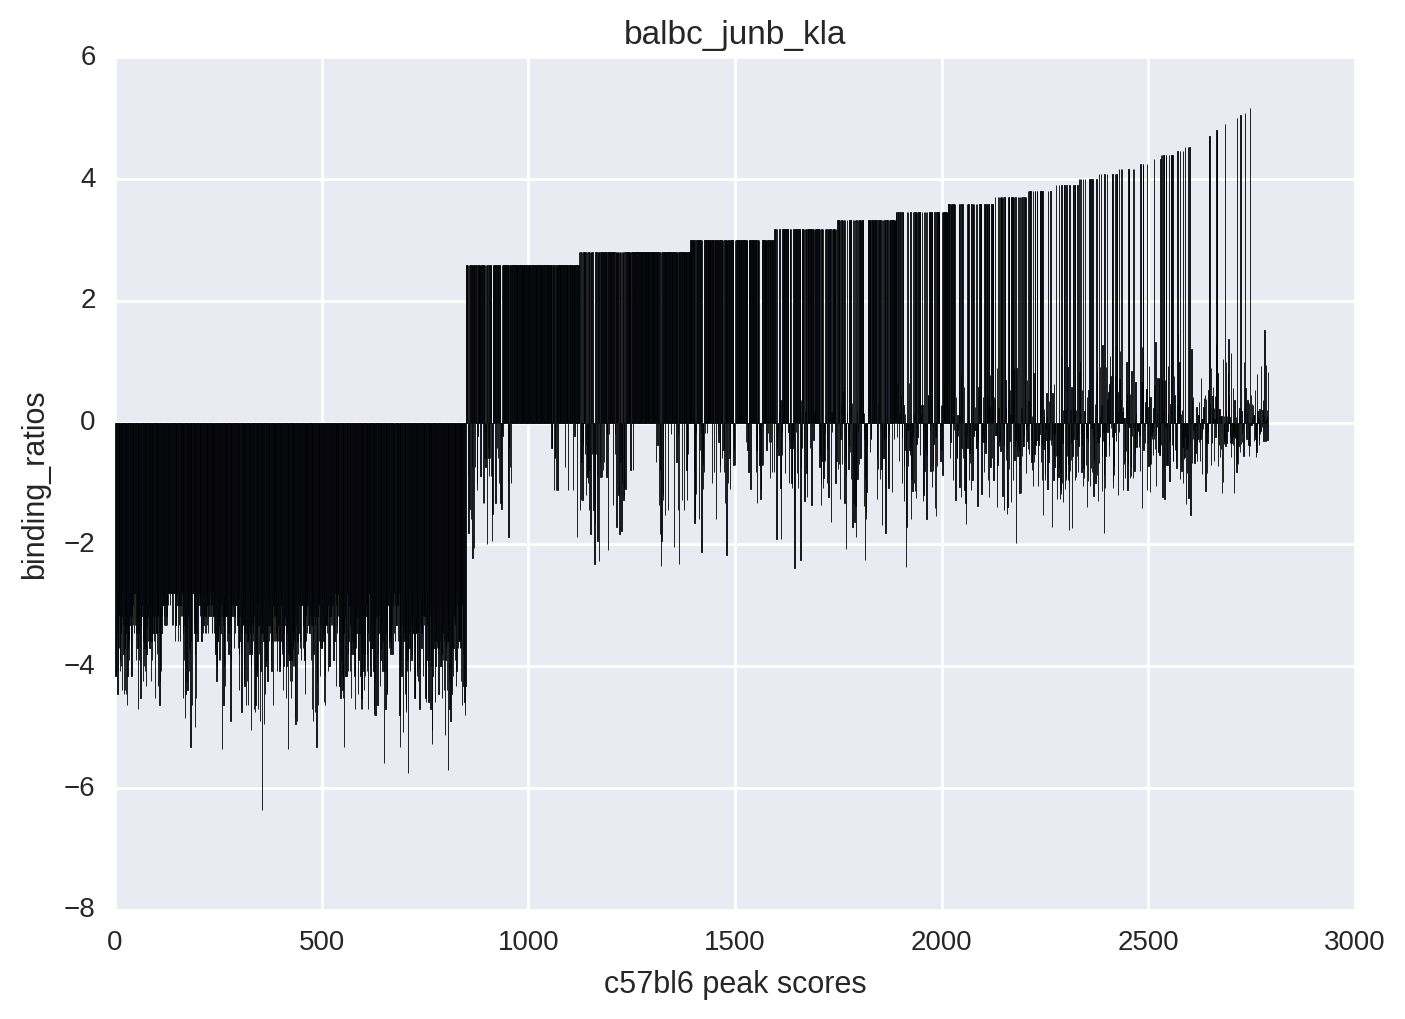

In [155]:
# strains_factors = ['pu1',
# 'fos',
# 'cjun',
# 'junb',
# 'jund']
strains_factors = ['junb']
# strains = ['balbc', 'nod']
strains=['balbc']
# treatments = ['veh','kla']
treatments=['kla']
for strain in strains:
    for factor in strains_factors:
        for treatment in treatments:
            print(strain, factor, treatment)
            strain_factor_treatment_1 = 'c57bl6'+'_'+factor+'_'+treatment
            strain_factor_treatment_2 = strain+'_'+factor+'_'+treatment
            indices = summary_frame[(summary_frame['Factors'].str.contains(strain_factor_treatment_1)) |
                                   (summary_frame['Factors'].str.contains(strain_factor_treatment_2))].index.values
            
            snp_indices = motif_balbcj_snp_frame[(motif_balbcj_snp_frame.sum(axis=1) > 0)
                                                ].index.values
#             snp_indices = motif_balbcj_snp_frame[motif_balbcj_snp_frame.sum(axis=1) >0].index.values
            indices = [x for x in indices if x in snp_indices]
            
            peakScores_1 = summary_frame.ix[indices,strain_factor_treatment_1]
            peakScores_2 = summary_frame.ix[indices,strain_factor_treatment_2]
            binding_ratios = (peakScores_1 + 1)/(peakScores_2+1)
            motif_scores = normed_motif_frame.ix[indices, 'ap-1'] + \
                normed_motif_frame.ix[indices, 'spib'] +\
                normed_motif_frame.ix[indices, 'cebp']
            
#             plt.scatter(np.log2(binding_ratios), motif_scores)
#             plt.ylabel('Motif Score')
#             plt.xlabel('c57bl6/'+strain+' binding')
            plt.bar(scipy.stats.rankdata(peakScores_1, method='ordinal'), np.log2(binding_ratios))
            plt.xlabel('c57bl6 peak scores')
            plt.ylabel('binding_ratios')
            plt.title(strain_factor_treatment_2)

            plt.show()

In [251]:
motif_1 = 'spi1-c'
motif_2 = 'ap-1'
factor_1 = 'c57bl6_pu1_veh'
factor_2 = 'c57bl6_cjun_veh'

motif_state_1s = []
motif_state_2s = []
peak_state_1s = []
peak_state_2s = []
counts = []
for peak_state_1 in [True, False]:
    for peak_state_2 in [True, False]:
        for motif_state_1 in [True, False]:
            for motif_state_2 in [True, False]:
#                 if np.sum([peak_state_1, peak_state_2]) > 0:
                if True:
                    motif_state_1s.append(motif_state_1)
                    motif_state_2s.append(motif_state_2)
                    peak_state_1s.append(peak_state_1)
                    peak_state_2s.append(peak_state_2)
                    peak_indices = summary_frame[(summary_frame['Factors'].str.contains(factor_1) == peak_state_1) &
                                                 (summary_frame['Factors'].str.contains(factor_2) == peak_state_2)].index.values
                    current_motif_frame = motif_score_frame[motif_score_frame.index.isin(peak_indices)]
                    motif_indices = current_motif_frame[((current_motif_frame[motif_1] > 0) == motif_state_1) &
                                                        ((current_motif_frame[motif_2] > 0) == motif_state_2)].index.values                   
                    count = len(motif_indices)
                    counts.append(count)
current_count_frame = pd.DataFrame({factor_1 +' binding':peak_state_1s,
                                   factor_2 +' binding':peak_state_2s,
                                   motif_1 + ' motif':motif_state_1s,
                                   motif_2 + ' motif':motif_state_2s,
                                   'num peaks': counts})               
current_count_frame = current_count_frame[[factor_1 +' binding',
                                   factor_2 +' binding',
                                   motif_1 + ' motif',
                                   motif_2 + ' motif',
                                   'num peaks']]

In [244]:
motif_1 = 'spi1-c'
motif_2 = 'ap-1'
factor_1 = 'c57bl6_pu1_kla'
factor_2 = 'c57bl6_cjun_kla'

motif_state_1s = []
motif_state_2s = []
peak_state_1s = []
peak_state_2s = []
snp_state_1s = []
snp_state_2s = []
counts = []
for peak_state_1 in [True, False]:
    for peak_state_2 in [True, False]:
        for motif_state_1 in [True, False]:
            for motif_state_2 in [True, False]:
                for snp_state_1 in [True, False]:
                    for snp_state_2 in [True, False]:
                        motif_state_1s.append(motif_state_1)
                        motif_state_2s.append(motif_state_2)
                        peak_state_1s.append(peak_state_1)
                        peak_state_2s.append(peak_state_2)
                        snp_state_1s.append(snp_state_1)
                        snp_state_2s.append(snp_state_2)
                        
                        peak_indices = summary_frame[(summary_frame['Factors'].str.contains(factor_1) == peak_state_1) &
                                                     (summary_frame['Factors'].str.contains(factor_2) == peak_state_2)].index.values

                        current_motif_frame = motif_score_frame[motif_score_frame.index.isin(peak_indices)]
                        motif_indices = current_motif_frame[((current_motif_frame[motif_1] > 0) == motif_state_1) &
                                                            ((current_motif_frame[motif_2] > 0) == motif_state_2)].index.values                   
                        current_snp_frame = motif_balbcj_snp_frame[motif_balbcj_snp_frame.index.isin(motif_indices)]
                        snp_indices = current_snp_frame[((current_snp_frame[motif_1] > 0) == snp_state_1) &
                                                            ((current_snp_frame[motif_2] > 0) == snp_state_2)].index.values   
                        
                        count = len(snp_indices)
                        counts.append(count)
current_count_frame = pd.DataFrame({factor_1 +' binding':peak_state_1s,
                                   factor_2 +' binding':peak_state_2s,
                                   motif_1 + ' motif':motif_state_1s,
                                   motif_2 + ' motif':motif_state_2s,
                                   motif_1 + ' snp':snp_state_1s,
                                   motif_2 + ' snp':snp_state_2s,
                                   'num peaks': counts})               
current_count_frame = current_count_frame[[factor_1 +' binding',
                                   factor_2 +' binding',
                                   motif_1 + ' motif',
                                   motif_2 + ' motif',
                                   motif_1 + ' snp',
                                   motif_2 + ' snp',
                                   'num peaks']]